In [4]:
import pathlib

import yaml

import numpy as np

import itertools

In [5]:
from pixell import enmap, utils as putils

In [6]:
import utilities as u

In [7]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'Latin Modern Roman'}
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 8)


In [8]:
import best
import re

In [9]:
paperplots = pathlib.Path('paperplots')

### Some general settings

In [11]:
values_file = 'configurations/config.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [12]:
plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [13]:
C = u.Converting()

In [14]:
noisetag = data['noisekey']
trispectrumtag = data['trispectrumkey']
primarytag = data['primarykey']
secondarytag = data['secondarykey']
primarycrosstag = data['primarycrosskey']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [15]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']

In [16]:
colors_ests['kk'] = 'black'
colors_ests['kg'] = 'yellow'

labels_ests['kk'] = 'Signal'
labels_ests['kg'] = 'Cross signal'

In [17]:
PP

PosixPath('output')

## Plot noises for lmax = 3500 vs signal

In [18]:
lmax_fixed = 3500

In [19]:
fsky = 1.

In [20]:
changemap = lambda x: enmap.enmap(x, wcs)
mapsObjA = u.mapNamesObj(nu)
LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft)

In [22]:
shape = LoadA.read_shape()
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
modlmap = enmap.modlmap(shape, wcs)
field_names_A = ['A1', 'A2']
feed_dict = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A, field_names_A, modlmap)

In [23]:
lmin_A, lmax_A = 30, 3500
Lmin, Lmax = 20, 6000

In [24]:
Binner = u.Binner(shape, wcs, lmin = 10, lmax = 6000, deltal = 30, log = False, nBins = 20)

In [19]:
lmaxes = lmaxes_configs[0] 
lmaxes_dict = {}
lmax_directory = ''

noise_dict = {}

for e_index, e in enumerate(estimators):
    l = lmax_fixed #lmaxes[e_index]
    lmaxes_dict[e] = l
    lmax_directory += f'{names[e]}{l}'
    hardening = estimators_dictionary[e]['hardening']
    A = u.Estimator(shape, wcs, feed_dict, e, lmin_A, lmax_A,
            field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
            hardening = hardening, XY = 'TT')
    NAB_cross = A.get_Nl_cross(A)
    el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
    noise_dict[e] = NAB_cross_binned

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:301: RuntimeWarning: overflow encountered in multiply
  val += ot2d*ffft
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: overflow encountered in multiply
  return val * mul
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: invalid value encountered in multiply
  return val * mul


In [20]:
P = PP/lmax_directory

getoutname = lambda key: f'{key}_{nu}.npy'

noises = np.load(P/getoutname(noisetag))
ells = np.load(P/getoutname('ells'))
kk = np.load(P/getoutname('kk'))
kg = np.load(P/getoutname('kg'))
gg = np.load(P/getoutname('gg'))

In [21]:
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 15)

findfont: Font family ['Latin Modern Roan'] not found. Falling back to DejaVu Sans.


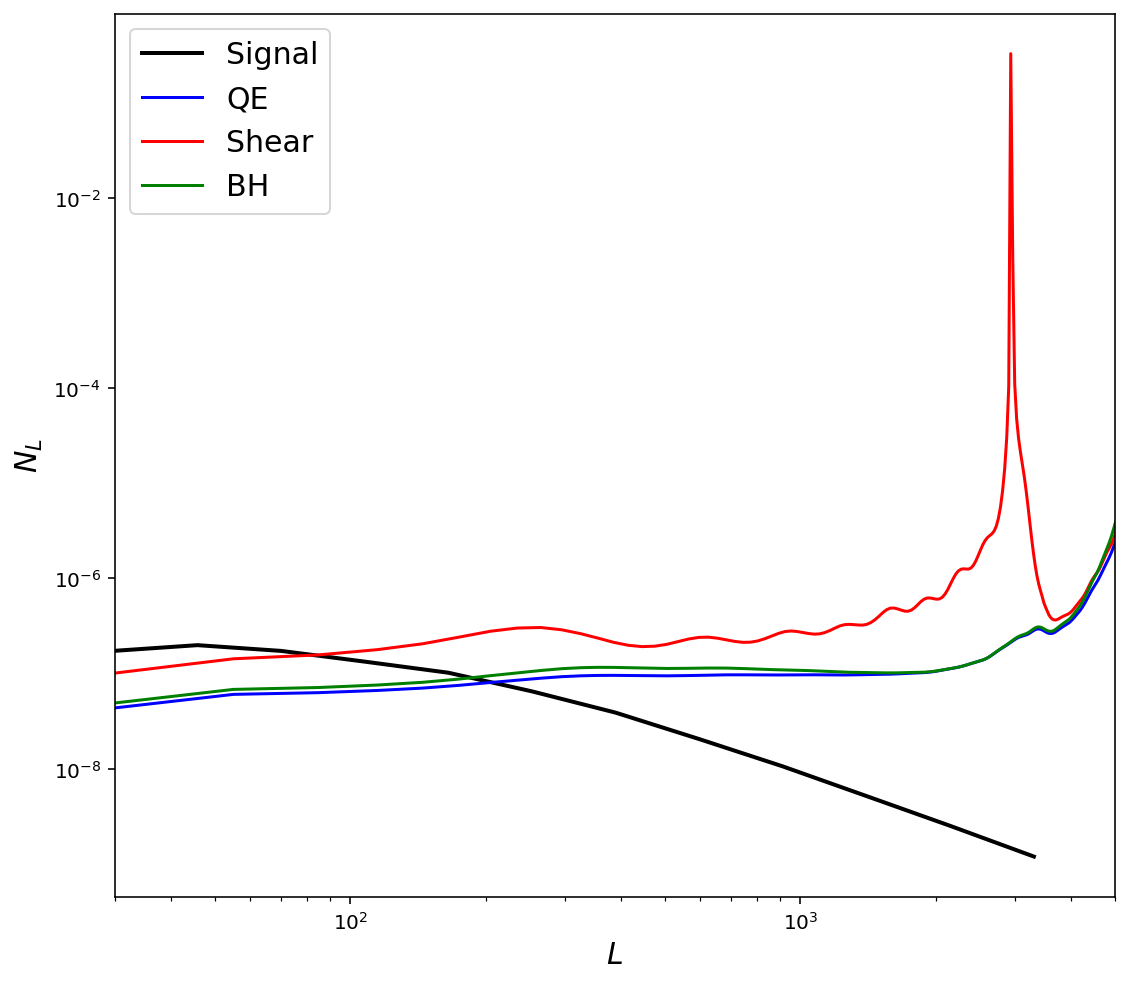

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (8, 7))
ax.plot(ells, kk, color = colors_ests['kk'], lw = 2, label = labels_ests['kk'])

for e_index, e in enumerate(estimators):
    ax.plot(el, noise_dict[e], color = colors_ests[e], label = labels_ests[e])
    
#for e_index, e in enumerate(estimators):
#    ax.plot(ells, noises[e_index, e_index], color = colors_ests[e], label = labels_ests[e])
    
    
ax.set_ylabel('$N_L$', size = 15)
ax.set_xlabel('$L$', size = 15)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(30, 5000)

ax.legend(prop = font)

fig.tight_layout()

fig.savefig(paperplots/'noises_3500.png', dpi = 300)
plt.show()

In [380]:
#ax[0].set_title(f'Best {names[i]}, h{h}_s{s}_b{b}', **csfont)
#fig.tight_layout()

In [25]:
lEdges = np.logspace(np.log10(10), np.log10(4000), 15, 10.)

In [26]:
deltal = lEdges[1:]-lEdges[:-1]

## Foregrounds biases

### Auto

In [94]:
fgnamefiles = ['tsz', 'cib', 'radiops', 'ksz', 'total']

In [95]:
lmax_fixed = 3500

In [96]:
foreground = {}
foreground['tsz'] = 'tSZ'
foreground['cib'] = 'CIB'
foreground['ksz'] = 'kSZ'
foreground['radiops'] = 'Radio'
foreground['total'] = 'Sum'

In [97]:
tri = 'Trispectrum'
pri = 'Primary'
pricross = 'Primary Cross'
sec = 'Secondary'
titles = [tri, pri, sec, pricross]

titles_tags = {}
titles_tags[tri] = trispectrumtag
titles_tags[pri] = primarytag
titles_tags[pricross] = primarycrosstag
titles_tags[sec] = secondarytag

In [98]:
ylims = {}

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.01
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.025
ylim['ksz']['ymax'] = 0.025

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.025
ylim['radiops']['ymax'] = 0.025

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[tri] = ylim

#######

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.1
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.025
ylim['ksz']['ymax'] = 0.025

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.025
ylim['radiops']['ymax'] = 0.1

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[pri] = ylim

#######

ylim = {}

ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.05
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.01
ylim['ksz']['ymax'] = 0.01

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.01
ylim['radiops']['ymax'] = 0.01

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[pricross] = ylim

#######

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.05
ylim['tsz']['ymax'] = 0.05

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.05
ylim['ksz']['ymax'] = 0.05

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.05
ylim['radiops']['ymax'] = 0.05

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[sec] = ylim

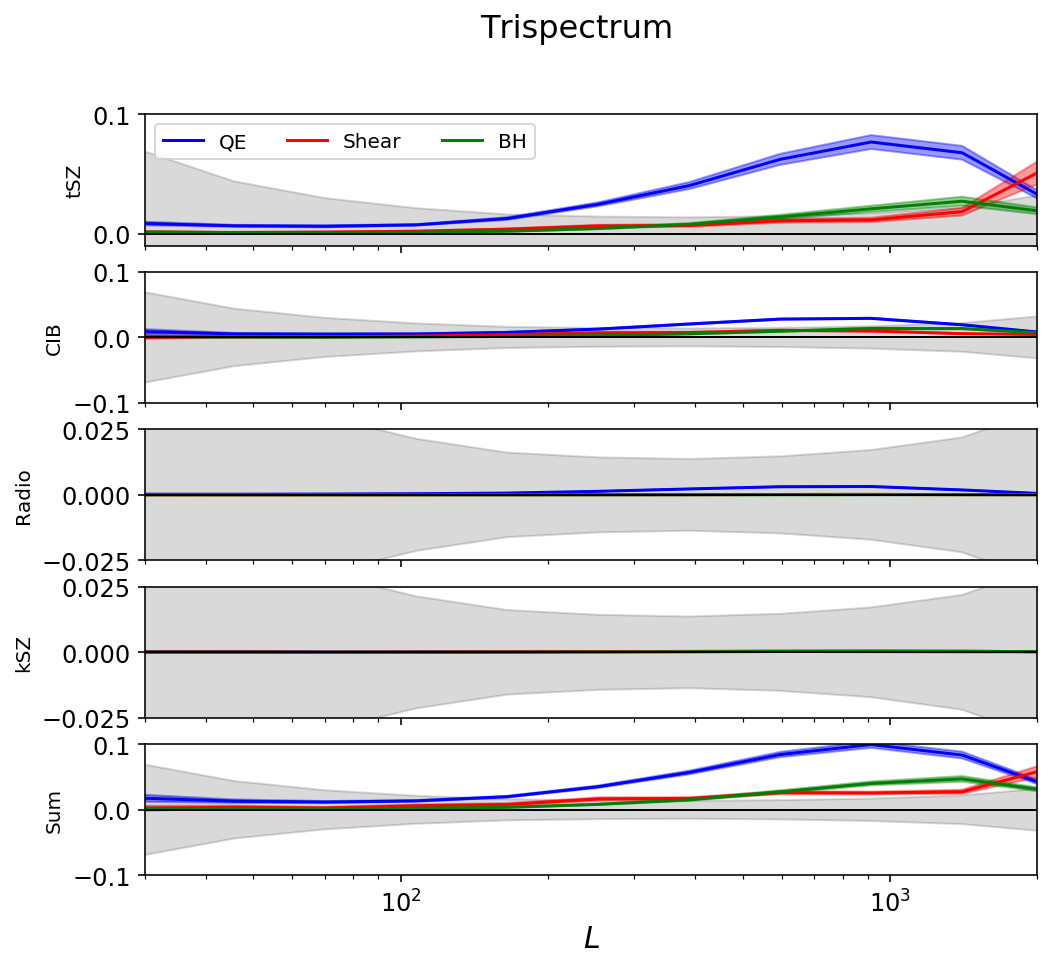

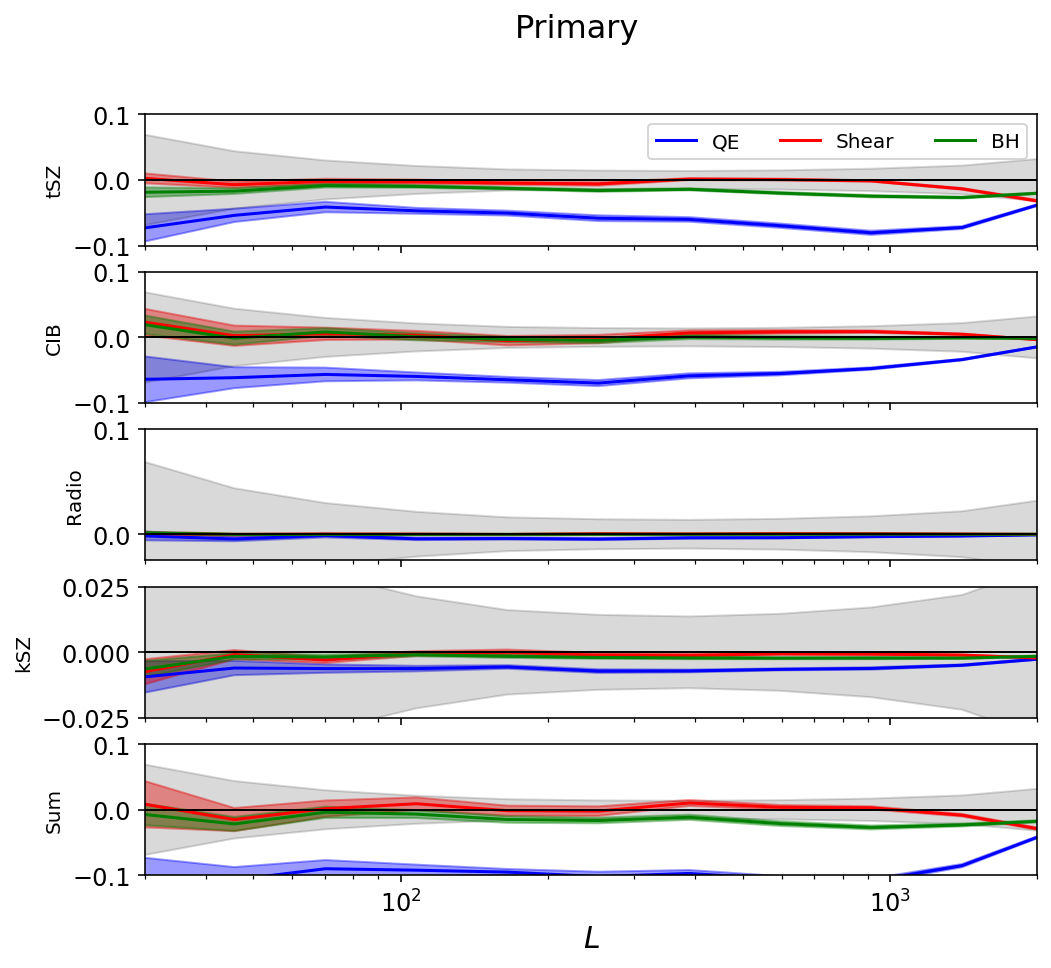

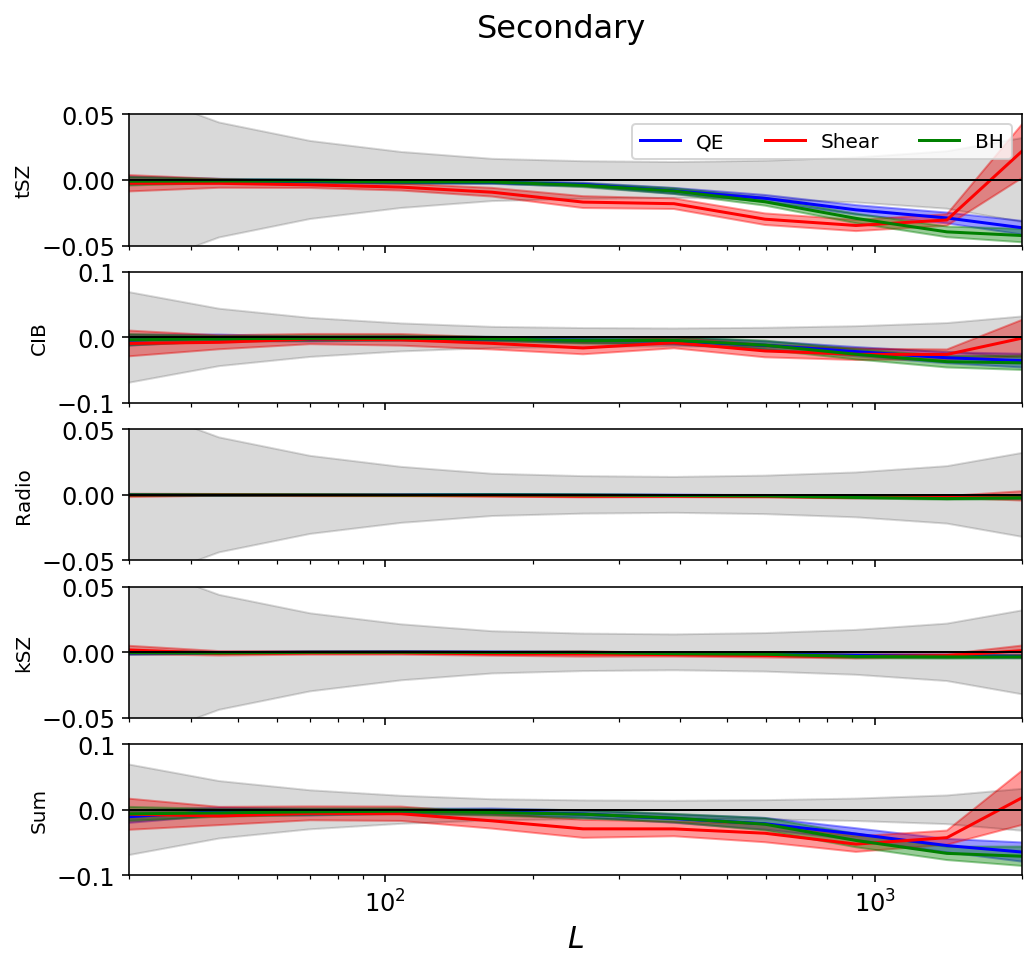

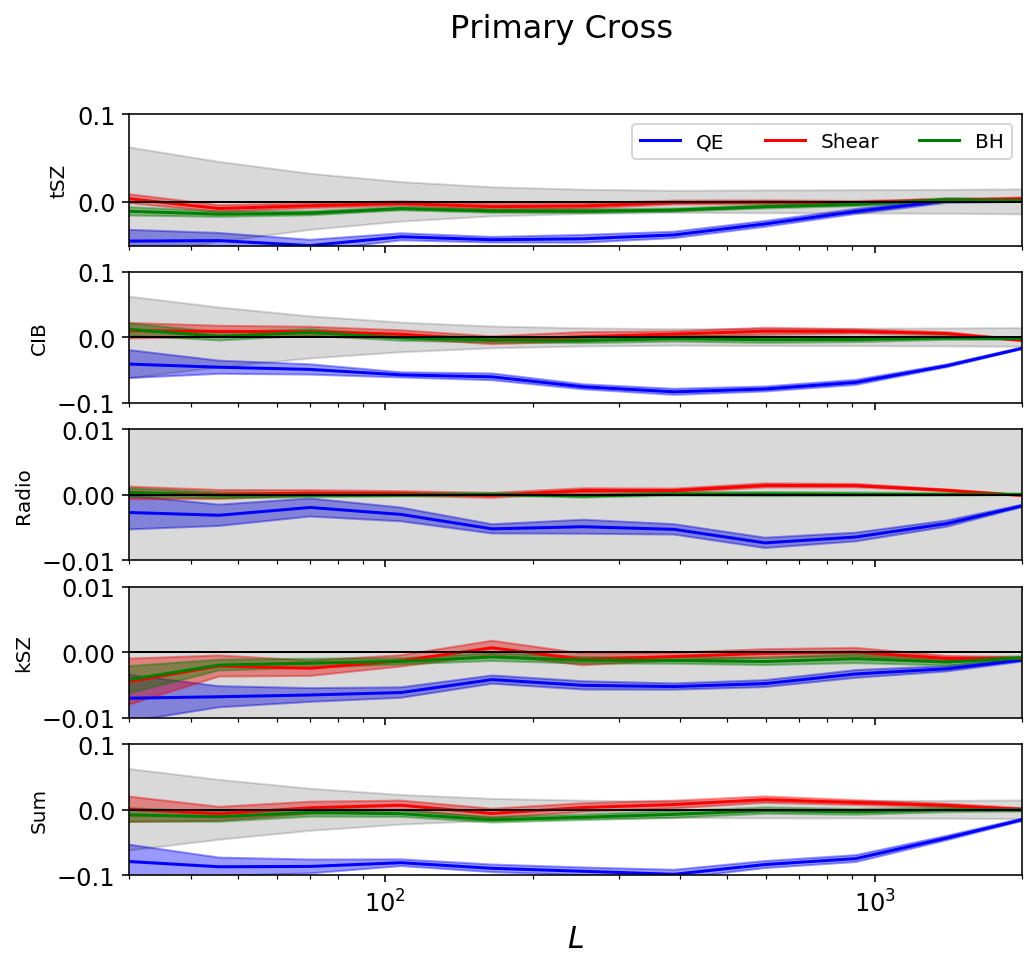

In [100]:
for lmaxes in [(lmax_fixed, lmax_fixed, lmax_fixed)]:
    lmaxes_dict = {}
    lmax_directory = ''
    for e_index, e in enumerate(estimators):
        l = lmaxes[e_index]
        lmaxes_dict[e] = l
        lmax_directory += f'{names[e]}{l}'

    for t in titles:
        fig, ax = plt.subplots(nrows = len(fgnamefiles), ncols = 1, sharex = True, figsize = (8, 7))

        fig.suptitle(f'{t}', fontsize = 16, **csfont)

        #primary = get(primarytag)
        #secondary = get(secondarytag)
        #trispectrum = get(trispectrumtag)

        #primaryscatter = getscatter(primarytag)
        #secondaryscatter = getscatter(secondarytag)
        #trispectrumscatter = getscatter(trispectrumtag)

        for fgindex, fgnamefile in enumerate(fgnamefiles):
            
            P = PP/lmax_directory
            Pfg = PP/lmax_directory/fgnamefile

            getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
            get = lambda key: np.load(Pfg/getoutname(key))

            getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
            getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

            noises = get(noisetag)
            ells = get('ells')
            kk = get('kk')
            kg = get('kg')
            gg = get('gg')
        
            specificbias = get(titles_tags[t])
            specificscatter = getscatter(titles_tags[t])

            ylim = ylims[t]
            
            for e_index, e in enumerate(estimators):
                                
                    
                noise_k = noises[0, 0] #For QE
                kktot = kk+noise_k
                
                if specificscatter.ndim > 2:
                    err = specificscatter[e_index, e_index]/kk
                    y = specificbias[e_index, e_index]/kk
                    
                    stat_uncert = np.sqrt(2/(2*ells*deltal*fsky))*kktot/kk
                else:
                    err = specificscatter[e_index]/kg
                    y = specificbias[e_index]/kg
                    
                    stat_uncert = np.sqrt(1/(2*ells*deltal*fsky)*(kktot*gg+kg**2.))/kg
                

                ax[fgindex].plot(ells, y, color = colors_ests[e], label = labels_ests[e])
                ax[fgindex].fill_between(ells, y-err, y+err, color = colors_ests[e], alpha = 0.4)
                
                ax[fgindex].fill_between(ells, -stat_uncert, stat_uncert, color = 'black', alpha = 0.05)
                

                ax[fgindex].set_ylim(ymin = ylim[fgnamefile]['ymin'], ymax = ylim[fgnamefile]['ymax'])
                ax[fgindex].set_ylabel(f'{foreground[fgnamefile]}')
                ax[fgindex].set_ylim(ylim[fgnamefile]['ymin'], ylim[fgnamefile]['ymax'])
                ax[fgindex].set_xlim(30, 2000)
                ax[fgindex].axhline(y = 0, color = 'black', lw = 1)
                ax[fgindex].tick_params(axis = 'both', which = 'major', labelsize = 12)

        ax[-1].set_xscale('log')
        ax[-1].set_xlabel('$L$', size = 15)
        
        ax[0].legend(loc = "best", ncol = len(estimators))

        #fig.tight_layout()
        fig.savefig(paperplots/f'biases_{titles_tags[t]}_3500.png', dpi = 300)

        plt.show()

#### Cross check primary cross with Manu's code

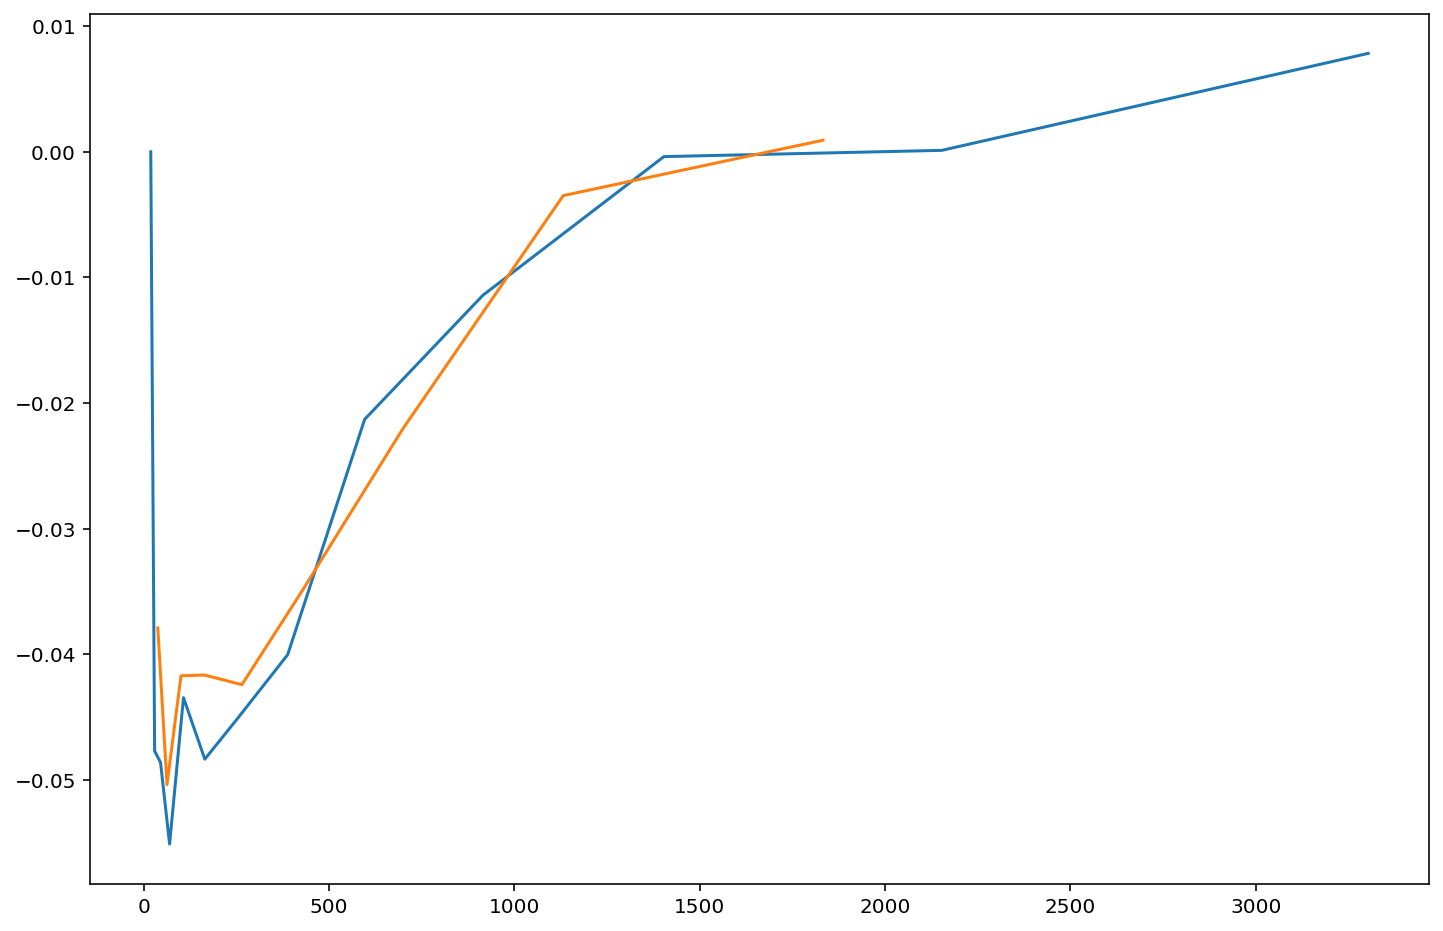

In [33]:
dictionary = u.dictionary(savingdirectory, 'h3500s3500b3500')

Nsims = data['Nsims']
fgnamefile = 'tsz'

total = 0.
totalmanu = 0.
totalmanukg = 0.

for j in range(Nsims):
    dic = dictionary.read(f'{fgnamefile}_{nu}_{j}')
    total += dic['PC']['PC-hu_ok']
    
    direc = '/scratch/r/rbond/omard/CORI17112020/toNIAGARA24112020/LensQuEst-1/out_txt/'
    lCen, Clcross, signal = np.loadtxt(direc+f'QE_galonly_{j}.txt', unpack = True)
    totalmanu += Clcross
    totalmanukg += signal
    
total /= Nsims
totalmanu /= Nsims
totalmanukg /= Nsims

plt.plot(ells, total/kg)
selection = (lCen>30) & (lCen<2000)
plt.plot(lCen[selection], totalmanu[selection]/totalmanukg[selection])

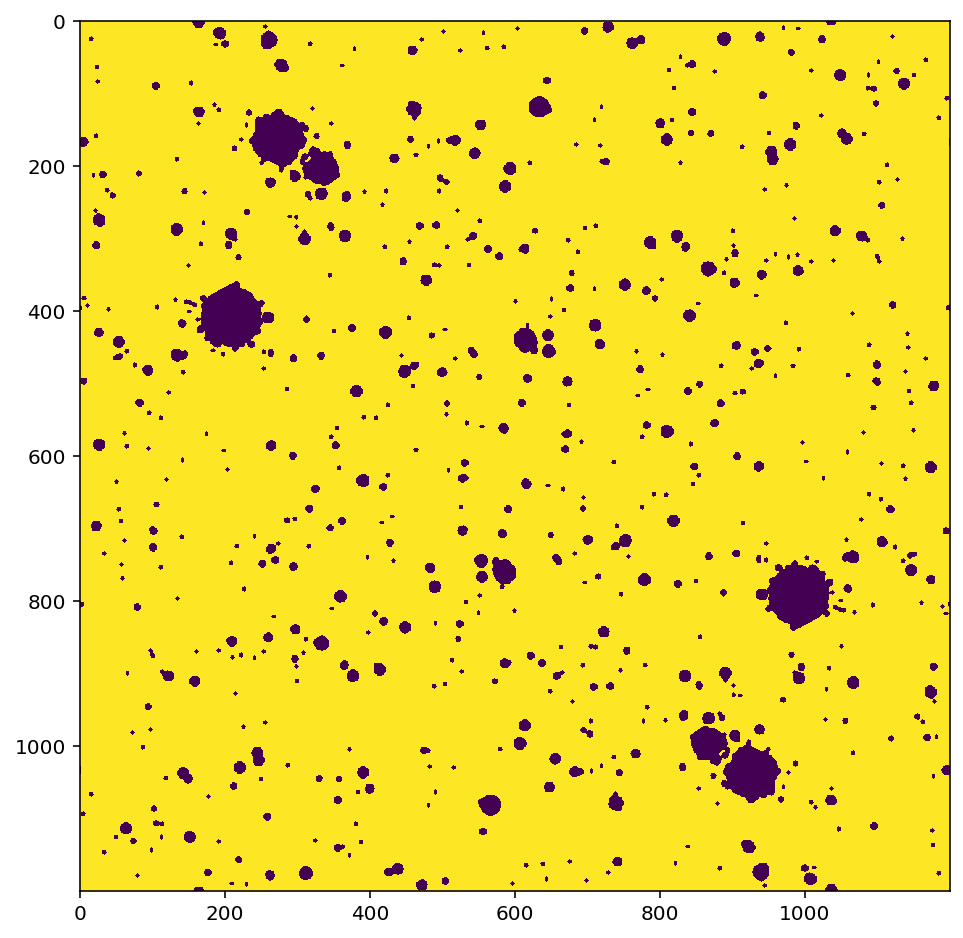

In [85]:
maskTot = np.loadtxt('../extract_sehgal/manusmaps/flat_maps_large/latestmaps13092020/'+'ps_mask_'+str(np.int(round(0.005*1000)))+"mJy_T_patch"+str(0)+".txt")
plt.imshow(maskTot)

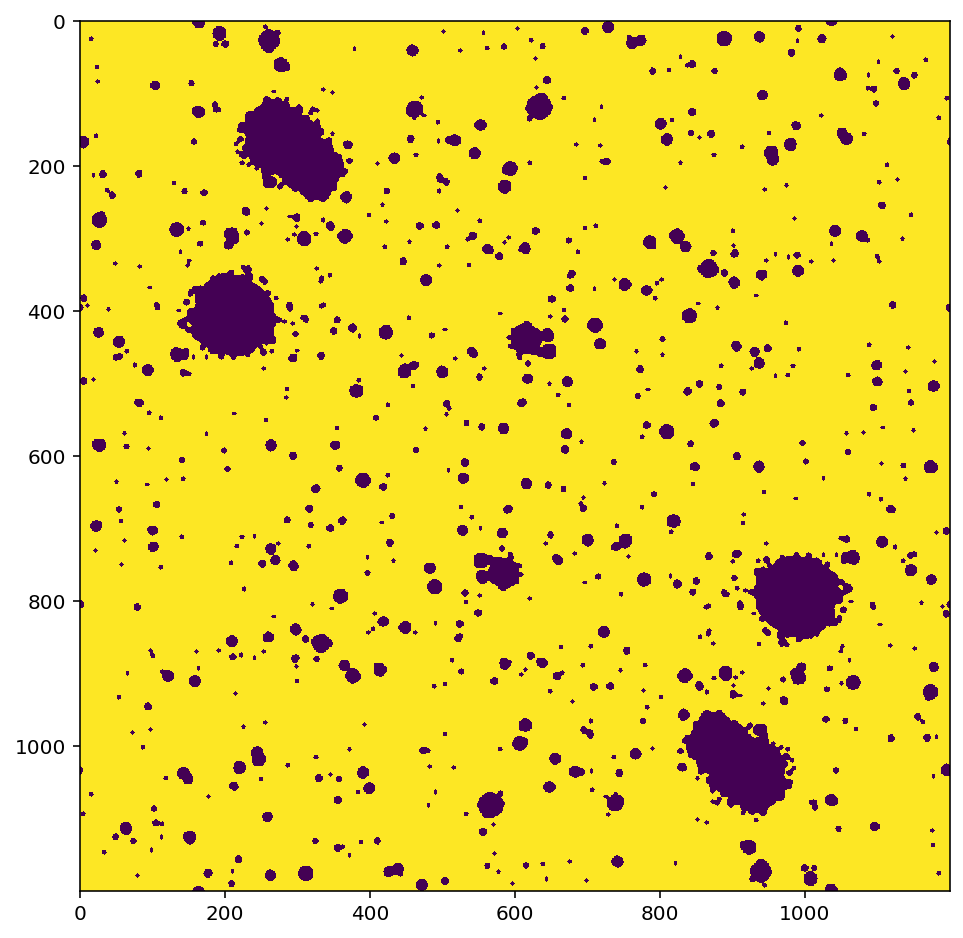

In [108]:
maskTot = np.loadtxt('../extract_sehgal/manusmaps/flat_maps_large/newmaps25012021/'+'ps_mask_lmax_3000_'+str(np.int(round(0.005*1000)))+"mJy_T_patch"+str(0)+".txt")
plt.imshow(maskTot)

In [43]:
#### Cross check primary with Noah's

### Alens parameter

In [110]:
import best

In [111]:
def get_lmax_directory(lmax_fixed, estimators):
    for lmaxes in [(lmax_fixed, lmax_fixed, lmax_fixed)]:
        lmaxes_dict = {}
        lmax_directory = ''
        for e_index, e in enumerate(estimators):
            l = lmaxes[e_index]
            lmaxes_dict[e] = l
            lmax_directory += f'{names[e]}{l}'
        return lmax_directory

In [112]:
lmaxes_list = np.arange(2000, 5000, 500)

In [113]:
colors_fgs = {}
colors_fgs['tsz'] = 'red'
colors_fgs['cib'] = 'blue'
colors_fgs['ksz'] = 'green'
colors_fgs['radiops'] = 'gold'
colors_fgs['total'] = 'cyan'

In [114]:
labels_fgs = {}
labels_fgs['tsz'] = 'tSZ'
labels_fgs['cib'] = 'CIB'
labels_fgs['ksz'] = 'kSZ'
labels_fgs['radiops'] = 'Radio'
labels_fgs['total'] = 'Sum'

In [115]:
autocase = 'auto'
crosscase = 'cross'
cases = [autocase, crosscase]

Doing hu_ok
Doing shear
Doing bh


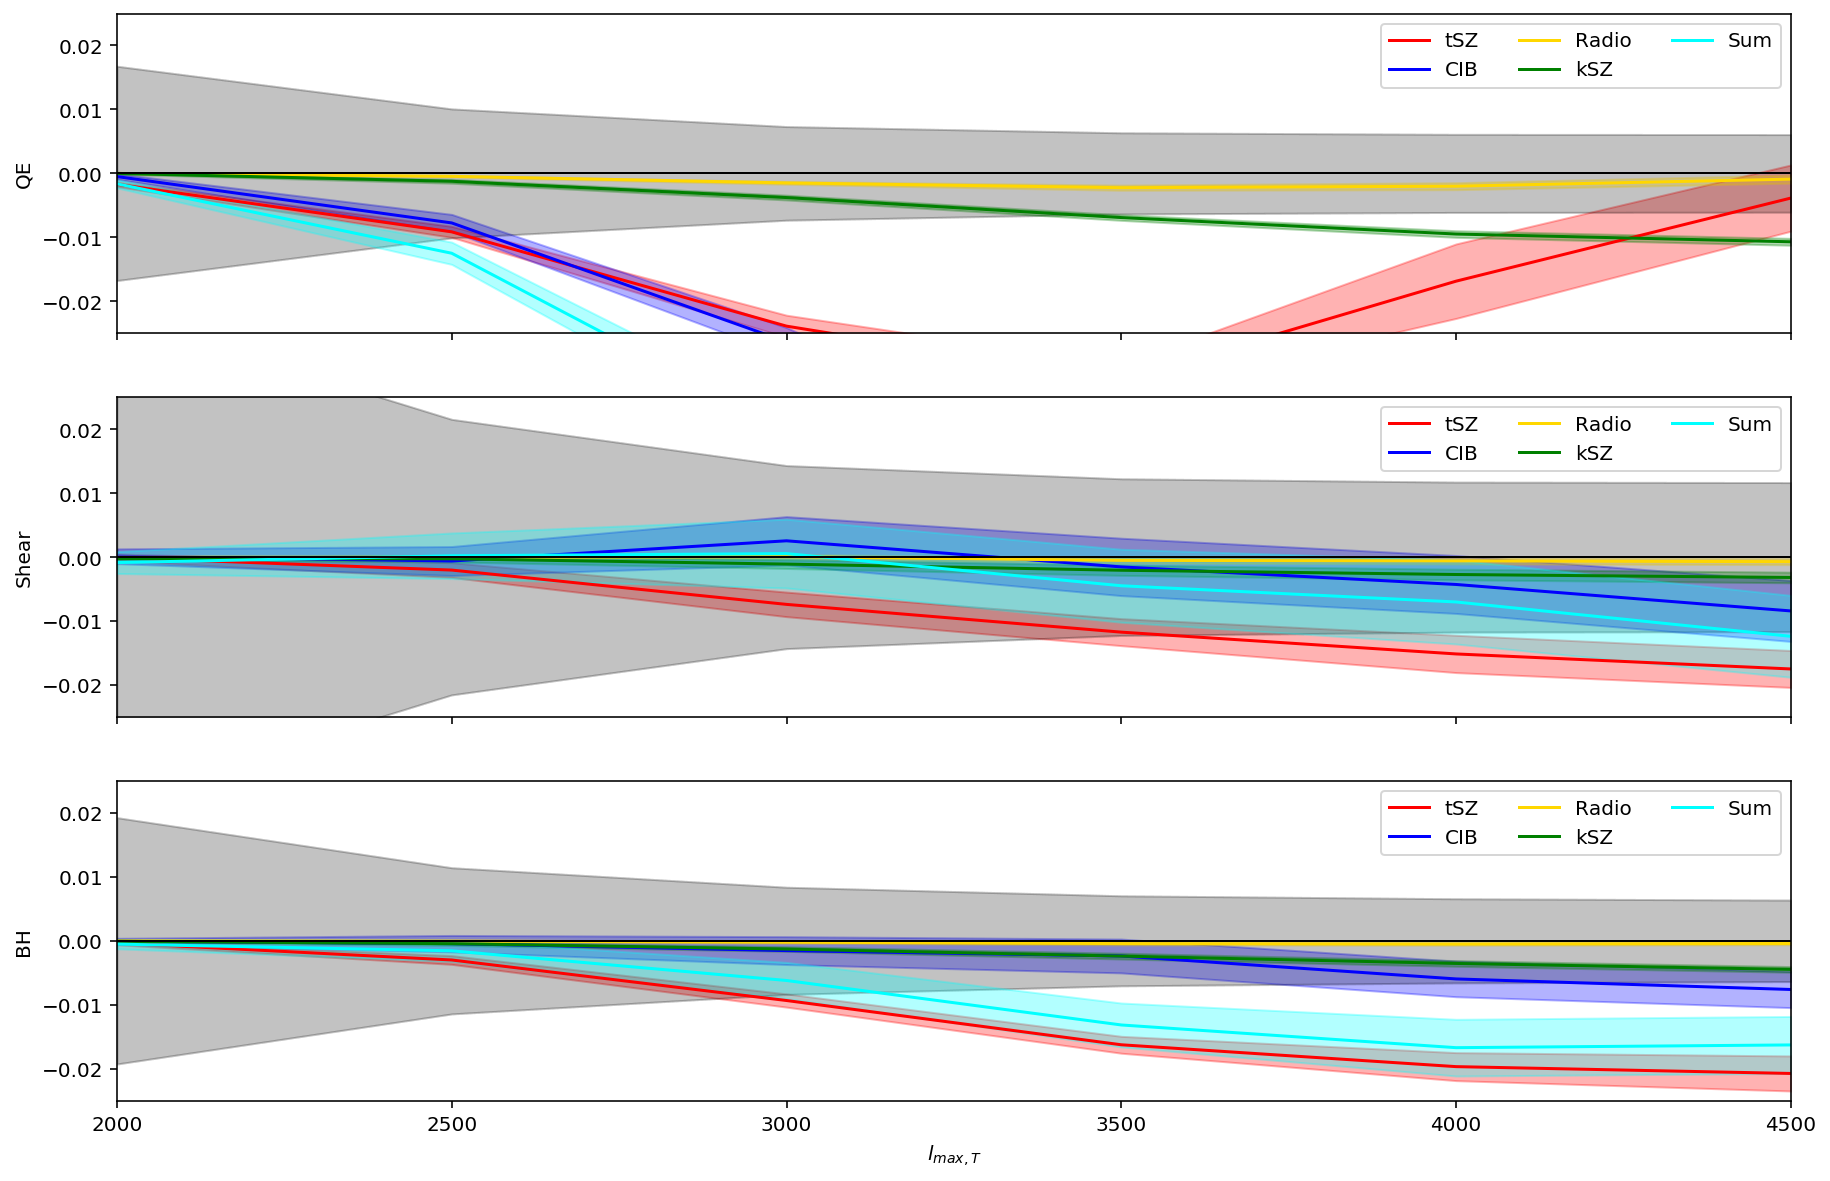

Doing hu_ok
Doing shear
Doing bh


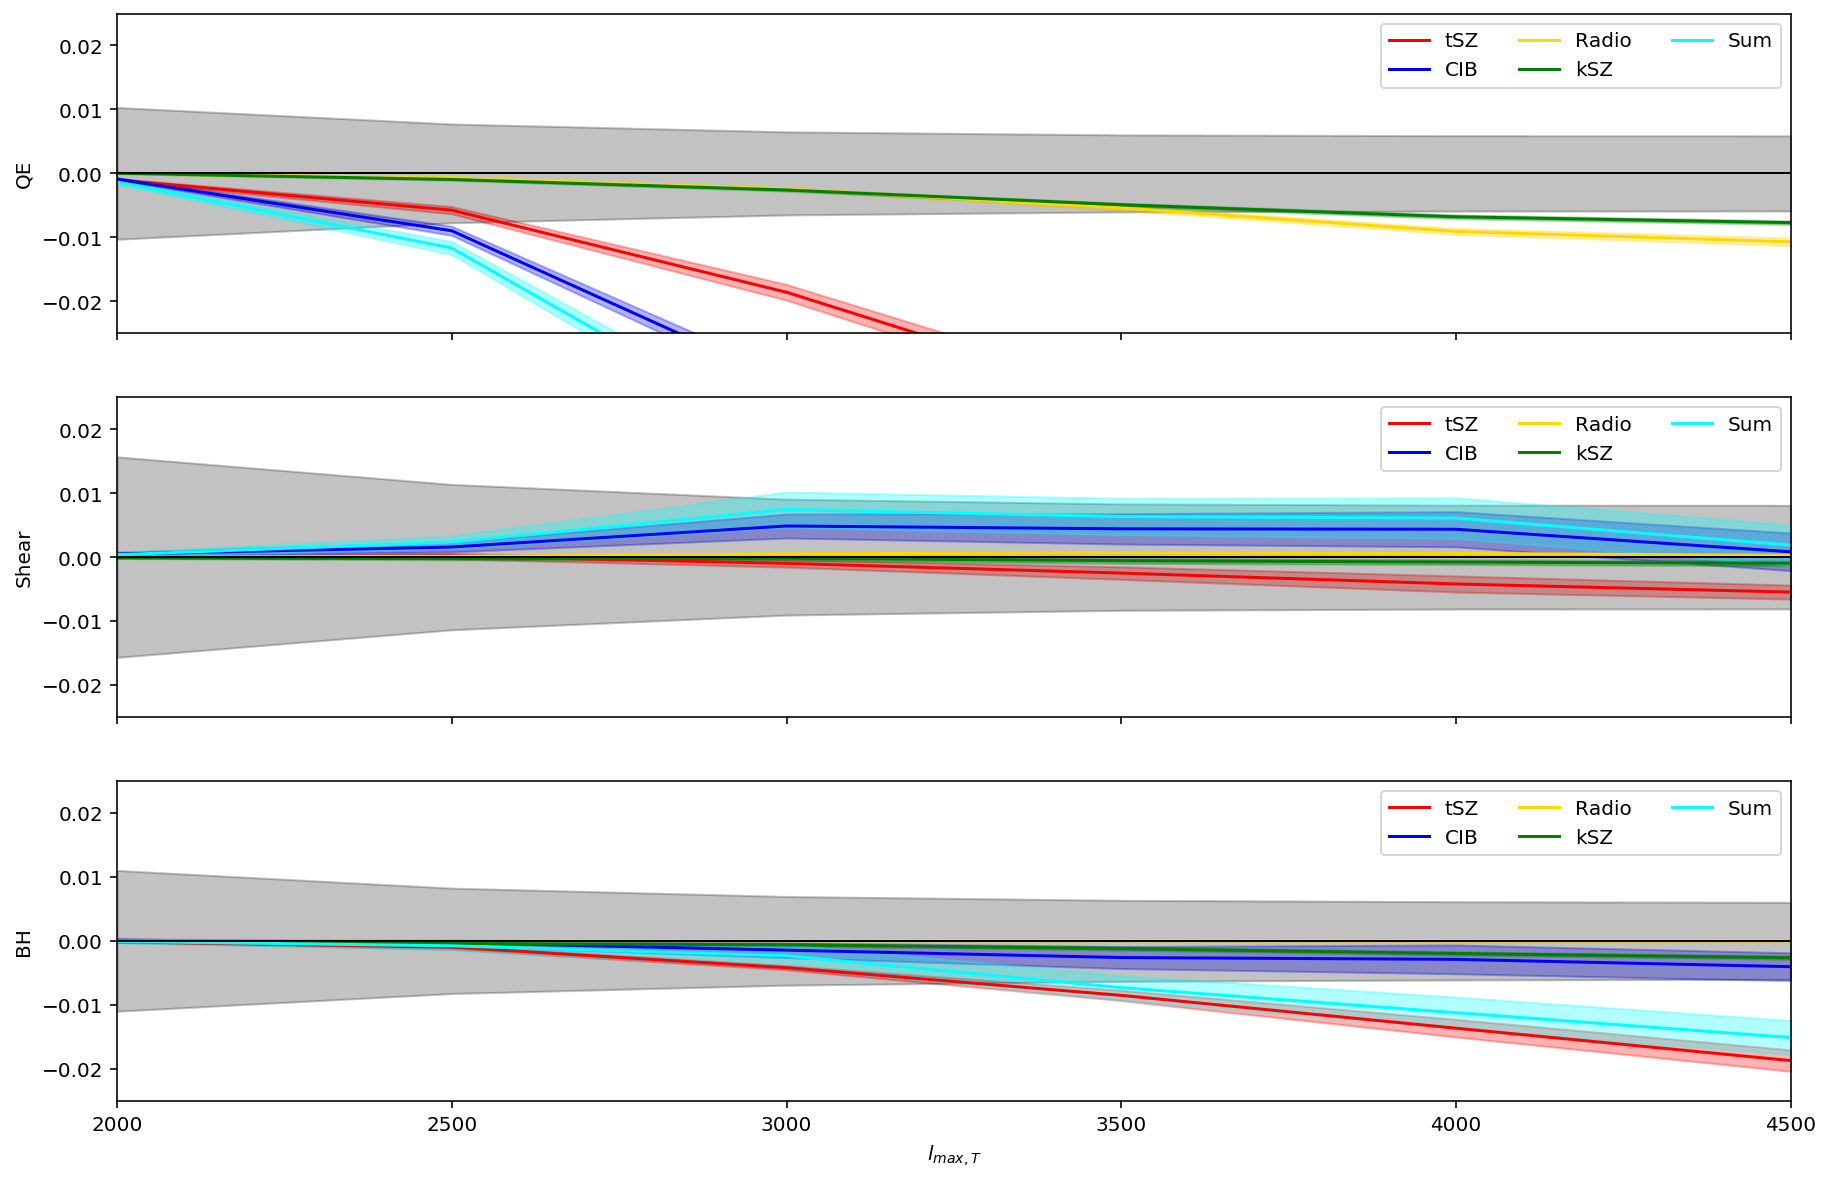

In [116]:
for case in cases:
    fig, ax = plt.subplots(nrows = len(estimators), sharex = True, figsize = (15, 10))

    for index, estimator in enumerate(estimators):

        print(f'Doing {estimator}')

        for fgindex, fgnamefile in enumerate(fgnamefiles):

            noiseslist = []
            biaseslist = []
            
            scatters_list = []
            means_list = []

            for lmax_fixed in lmaxes_list: 

                lmax_directory = get_lmax_directory(lmax_fixed, estimators)
                
                P = PP/lmax_directory
                Pfg = PP/lmax_directory/fgnamefile

                getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
                get = lambda key: np.load(Pfg/getoutname(key))

                getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
                getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

                noises = get(noisetag)
                theta = get('theta')
                thetacross = get('thetacross')
                ells = get('ells')
                kk = get('kk')
                kg = get('kg')
                gg = get('gg')

                specificbias = get('totalbias')
                specificbiascross = get(primarycrosstag)
                
                #specificscatter = getscatter('totalbias')
                #specificscattercross = getscatter(primarycrosstag)
                
                if case == autocase:
                    Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, specificbias, noises)
                    Opt = Optauto
                elif case == crosscase:
                    Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, specificbiascross, noises)
                    Opt = Optcross

                f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                nbins = Opt.nbins
                zeros = np.zeros(3*nbins)
                for j in range(nbins):
                    zeros[index+3*j:index+(3*j+1)] = 1.

                noiseslist += [n(zeros)]
                biaseslist += [b(zeros)]
                
                dic = u.dictionary('output_biases/', lmax_directory)
                
                biasestags = [trispectrumtag, primarytag, secondarytag]
                
                total = []

                for j in range(Nsims):
                    dictionary = dic.read(f'{fgnamefile}_{nu}_{j}')
                    temp = 0.
                    if case == autocase:
                        for k in biasestags:
                            temp += (u.get_element(dictionary[k], estimators))
                    elif case == crosscase:
                        temp += (u.get_element(dictionary[primarycrosstag], estimators))
                        
                    temp_bias = temp
                    
                    if case == autocase:
                        Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, temp_bias, noises)
                        Opt = Optauto
                    elif case == crosscase:
                        Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, temp_bias, noises)
                        Opt = Optcross
                        
                    f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)
                    
                    
                    
                    
                    total += [b(zeros)]
                    
                A, A_octanct = 81*20**2, 5156.6
                factor_err = np.sqrt(A/A_octanct)
                    
                mean, scatter = u.get_mean_and_scatter(Nsims, total)
                
                scatters_list += [scatter]
                means_list += [mean]
                
                
                

            noiseslist = np.array(noiseslist)
            biaseslist = np.array(biaseslist)
            
            scatters_list = np.array(scatters_list)*factor_err
            means_list = np.array(means_list)
            
            #print('Rapp', means_list/biaseslist)
            #print(scatters_list)
            
            ax[index].plot(lmaxes_list, biaseslist, color = colors_fgs[fgnamefile], label = labels_fgs[fgnamefile])
            ax[index].fill_between(lmaxes_list, -noiseslist, noiseslist, color = 'black', alpha = 0.05)
            
            ax[index].fill_between(lmaxes_list, biaseslist-scatters_list, biaseslist+scatters_list, color = colors_fgs[fgnamefile], alpha = 0.3)

        ax[index].axhline(y = 0, color = 'black', lw = 1)
        ax[index].set_ylim(-0.025, 0.025)
        ax[index].set_ylabel(labels_ests[estimator])
        ax[index].legend(ncol = len(estimators))
        ax[-1].set_xlim(2000, 4500)
        ax[-1].set_xlabel('$l_{max,T}$')

    fig.savefig(paperplots/f'alens_{case}_biases.png', dpi = 300)
    plt.show()

In [117]:
cases = [autocase]

Doing hu_ok
Doing shear
Doing bh


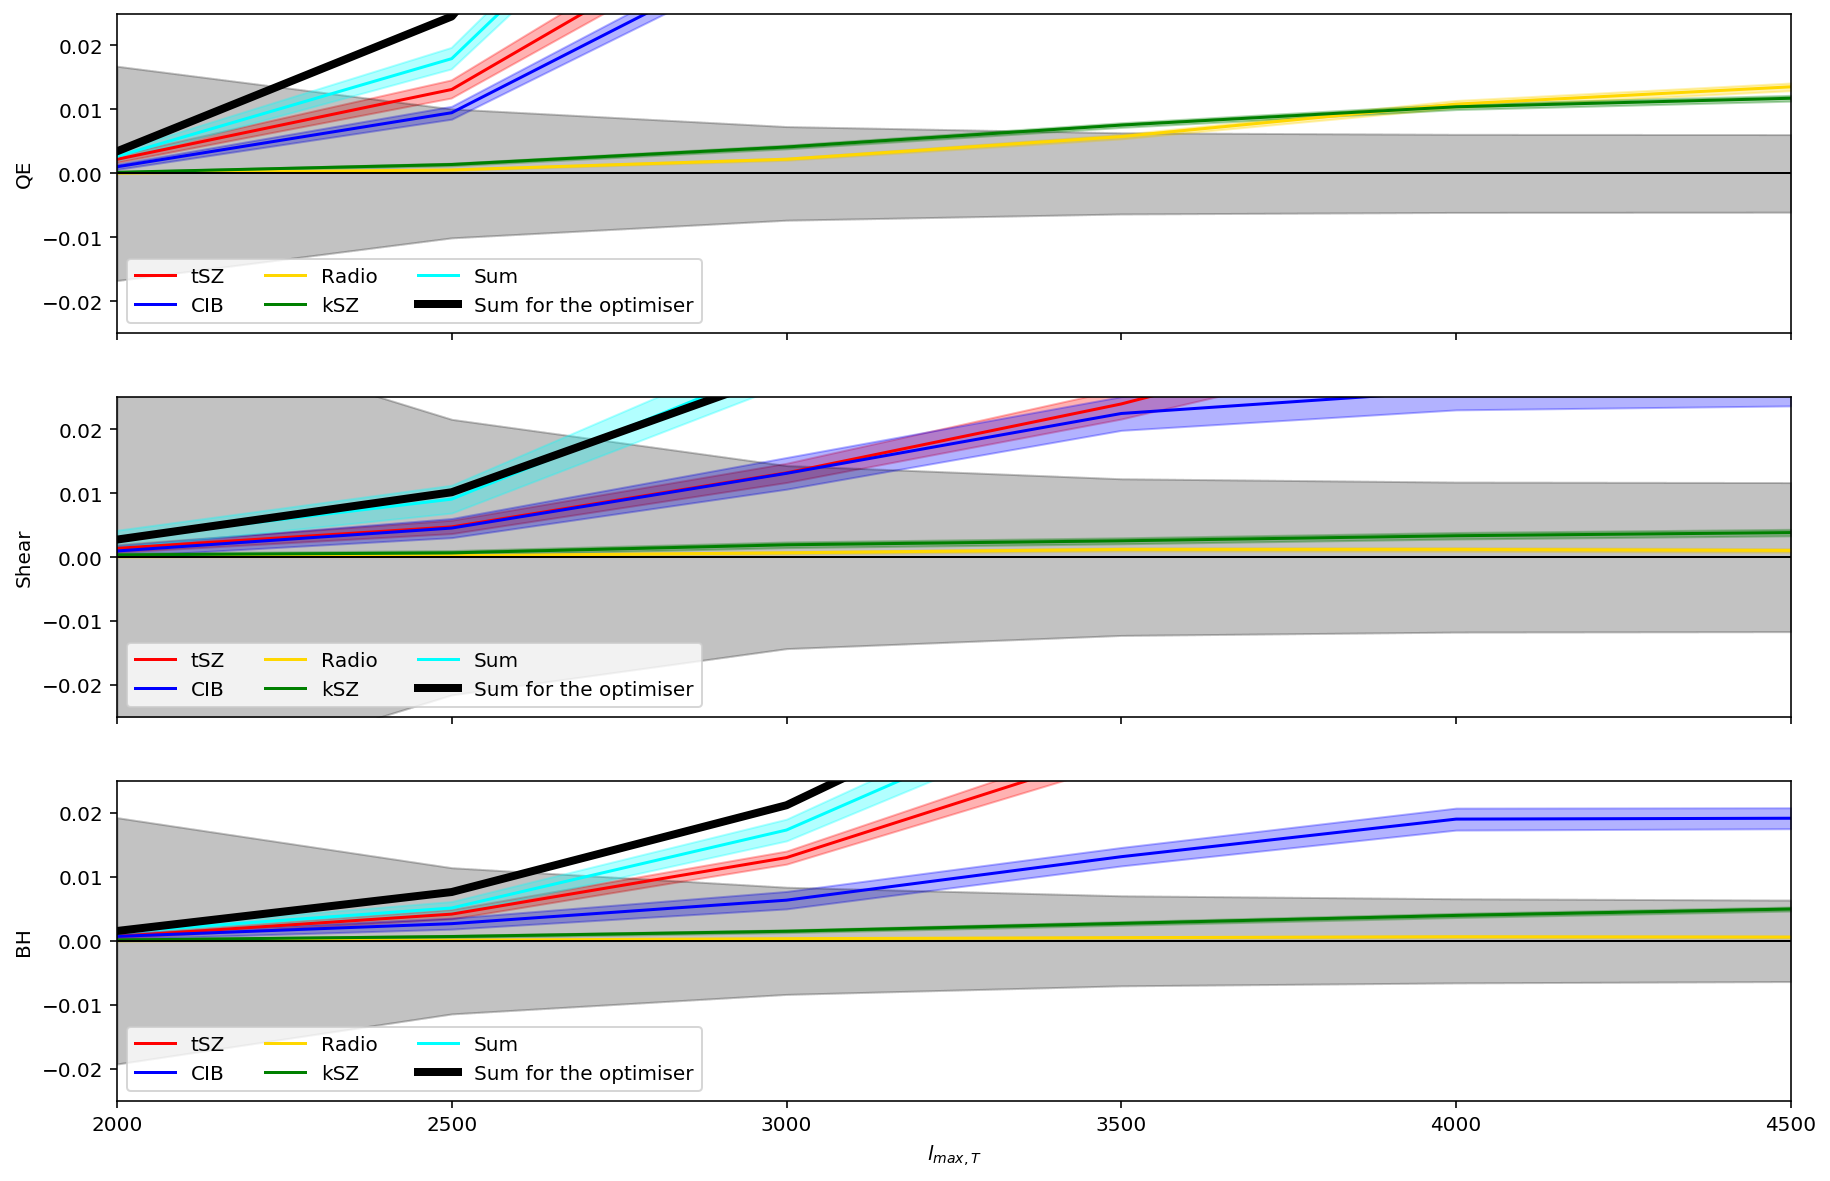

In [118]:
for case in cases:
    fig, ax = plt.subplots(nrows = len(estimators), sharex = True, figsize = (15, 10))

    for index, estimator in enumerate(estimators):

        print(f'Doing {estimator}')

        for fgindex, fgnamefile in enumerate(fgnamefiles):

            noiseslist = []
            biaseslist = []
            
            scatters_list = []
            means_list = []
            
            sumbiasestotallist = []

            for lmax_fixed in lmaxes_list: 

                lmax_directory = get_lmax_directory(lmax_fixed, estimators)
                
                P = PP/lmax_directory
                Pfg = PP/lmax_directory/fgnamefile

                getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
                get = lambda key: np.load(Pfg/getoutname(key))

                getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
                getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

                noises = get(noisetag)
                theta = get('theta')
                thetacross = get('thetacross')
                ells = get('ells')
                kk = get('kk')
                kg = get('kg')
                gg = get('gg')

                specificbias = get('totalabsbias')
                specificbiascross = get(primarycrosstag)
                
                #specificscatter = getscatter('totalbias')
                #specificscattercross = getscatter(primarycrosstag)
                
                if case == autocase:
                    Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, specificbias, noises)
                    Opt = Optauto
                elif case == crosscase:
                    Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, specificbiascross, noises)
                    Opt = Optcross

                f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                nbins = Opt.nbins
                zeros = np.zeros(3*nbins)
                for j in range(nbins):
                    zeros[index+3*j:index+(3*j+1)] = 1.

                noiseslist += [n(zeros)]
                biaseslist += [b(zeros)]
                
                dic = u.dictionary('output_biases/', lmax_directory)
                
                biasestags = [trispectrumtag, primarytag, secondarytag]
                
                total = []

                for j in range(Nsims):
                    dictionary = dic.read(f'{fgnamefile}_{nu}_{j}')
                    temp = 0.
                    if case == autocase:
                        for k in biasestags:
                            temp += abs(u.get_element(dictionary[k], estimators))
                    elif case == crosscase:
                        temp += (u.get_element(dictionary[primarycrosstag], estimators))
                        
                    temp_bias = temp
                    
                    if case == autocase:
                        Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, temp_bias, noises)
                        Opt = Optauto
                    elif case == crosscase:
                        Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, temp_bias, noises)
                        Opt = Optcross
                        
                    f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)
                    
                    
                    
                    
                    total += [b(zeros)]
                    
                A, A_octanct = 81*20**2, 5156.6
                factor_err = np.sqrt(A/A_octanct)
                    
                mean, scatter = u.get_mean_and_scatter(Nsims, total)
                
                scatters_list += [scatter]
                means_list += [mean]
                
                
                P = PP/lmax_directory

                getoutname = lambda key: f'{key}_{nu}.npy'
                biasestotal = np.load(P/getoutname('sum_all_totalabsbias'))
                
                if case == autocase:
                    Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, biasestotal, noises)
                    Opt = Optauto
                
                f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)
                sumbiasestotallist += [b(zeros)]
                
                
                

            noiseslist = np.array(noiseslist)
            biaseslist = np.array(biaseslist)
            
            scatters_list = np.array(scatters_list)*factor_err
            means_list = np.array(means_list)
            
            #print('Rapp', means_list/biaseslist)
            #print(scatters_list)
            
            ax[index].plot(lmaxes_list, biaseslist, color = colors_fgs[fgnamefile], label = labels_fgs[fgnamefile])
            ax[index].fill_between(lmaxes_list, -noiseslist, noiseslist, color = 'black', alpha = 0.05)
            
            ax[index].fill_between(lmaxes_list, biaseslist-scatters_list, biaseslist+scatters_list, color = colors_fgs[fgnamefile], alpha = 0.3)

        ax[index].plot(lmaxes_list, sumbiasestotallist, lw = 4, color = 'black', label = 'Sum for the optimiser')
            
        ax[index].axhline(y = 0, color = 'black', lw = 1)
        ax[index].set_ylim(-0.025, 0.025)
        ax[index].set_ylabel(labels_ests[estimator])
        ax[index].legend(ncol = len(estimators))
        ax[-1].set_xlim(2000, 4500)
        ax[-1].set_xlabel('$l_{max,T}$')

    fig.savefig(paperplots/f'alens_{case}_abs_biases.png', dpi = 300)
    plt.show()

In [119]:
cases = [autocase]

Doing hu_ok
Doing shear
Doing bh


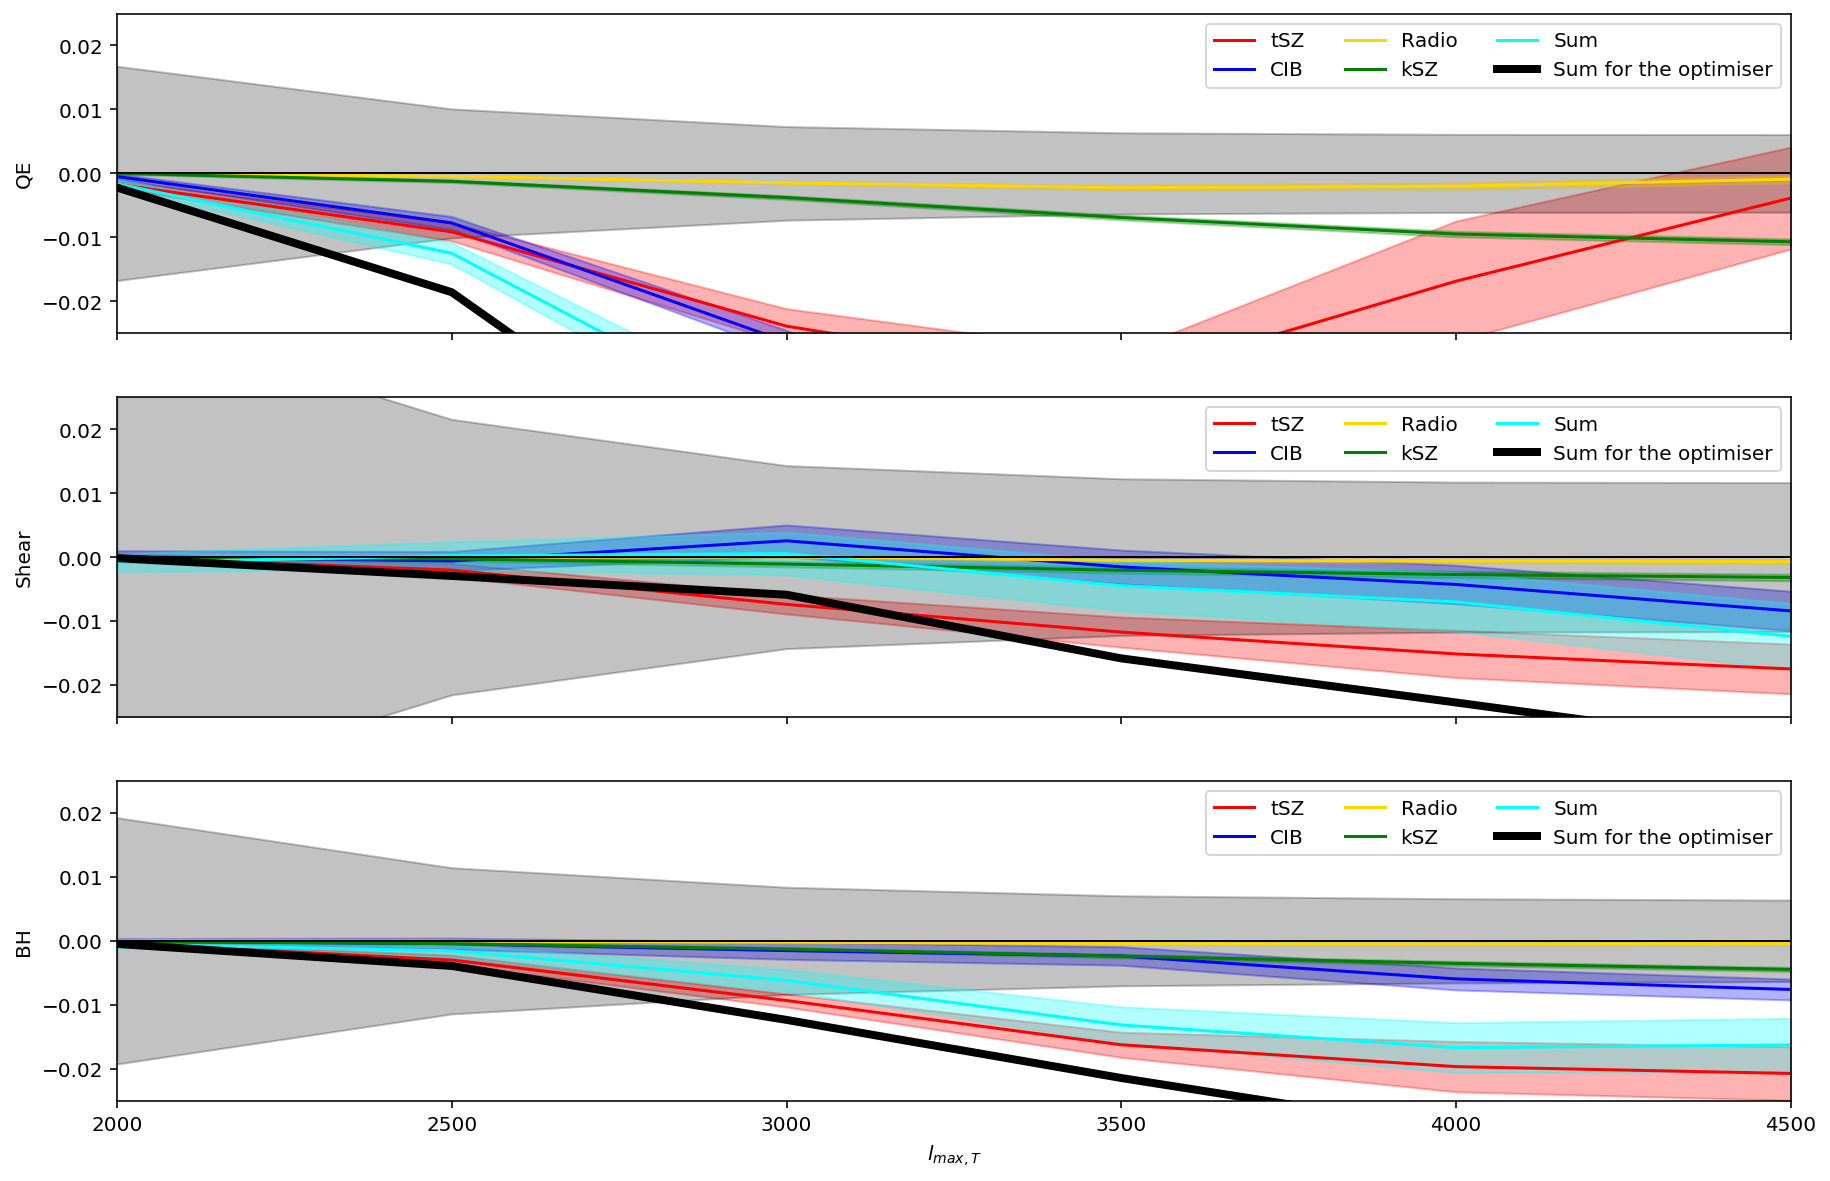

In [120]:
for case in cases:
    fig, ax = plt.subplots(nrows = len(estimators), sharex = True, figsize = (15, 10))

    for index, estimator in enumerate(estimators):

        print(f'Doing {estimator}')

        for fgindex, fgnamefile in enumerate(fgnamefiles):

            noiseslist = []
            biaseslist = []
            
            scatters_list = []
            means_list = []
            
            sumbiasestotallist = []

            for lmax_fixed in lmaxes_list: 

                lmax_directory = get_lmax_directory(lmax_fixed, estimators)
                
                P = PP/lmax_directory
                Pfg = PP/lmax_directory/fgnamefile

                getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
                get = lambda key: np.load(Pfg/getoutname(key))

                getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
                getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

                noises = get(noisetag)
                theta = get('theta')
                thetacross = get('thetacross')
                ells = get('ells')
                kk = get('kk')
                kg = get('kg')
                gg = get('gg')

                specificbias = get('totalbias')
                specificbiascross = get(primarycrosstag)
                
                #specificscatter = getscatter('totalbias')
                #specificscattercross = getscatter(primarycrosstag)
                
                if case == autocase:
                    Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, specificbias, noises)
                    Opt = Optauto
                elif case == crosscase:
                    Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, specificbiascross, noises)
                    Opt = Optcross

                f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                nbins = Opt.nbins
                zeros = np.zeros(3*nbins)
                for j in range(nbins):
                    zeros[index+3*j:index+(3*j+1)] = 1.

                noiseslist += [n(zeros)]
                biaseslist += [b(zeros)]
                
                dic = u.dictionary('output_biases/', lmax_directory)
                
                biasestags = [trispectrumtag, primarytag, secondarytag]
                
                total = []

                for j in range(Nsims):
                    dictionary = dic.read(f'{fgnamefile}_{nu}_{j}')
                    temp = 0.
                    if case == autocase:
                        for k in biasestags:
                            temp += abs(u.get_element(dictionary[k], estimators))
                    elif case == crosscase:
                        temp += (u.get_element(dictionary[primarycrosstag], estimators))
                        
                    temp_bias = temp
                    
                    if case == autocase:
                        Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, temp_bias, noises)
                        Opt = Optauto
                    elif case == crosscase:
                        Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, temp_bias, noises)
                        Opt = Optcross
                        
                    f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)
                    
                    
                    
                    
                    total += [b(zeros)]
                    
                A, A_octanct = 81*20**2, 5156.6
                factor_err = np.sqrt(A/A_octanct)
                    
                mean, scatter = u.get_mean_and_scatter(Nsims, total)
                
                scatters_list += [scatter]
                means_list += [mean]
                
                
                P = PP/lmax_directory

                getoutname = lambda key: f'{key}_{nu}.npy'
                biasestotal = np.load(P/getoutname('sum_all_totalbias'))
                
                if case == autocase:
                    Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, biasestotal, noises)
                    Opt = Optauto
                
                f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)
                sumbiasestotallist += [b(zeros)]

            noiseslist = np.array(noiseslist)
            biaseslist = np.array(biaseslist)
            
            scatters_list = np.array(scatters_list)*factor_err
            means_list = np.array(means_list)
            
            #print('Rapp', means_list/biaseslist)
            #print(scatters_list)
            
            
            ax[index].plot(lmaxes_list, biaseslist, color = colors_fgs[fgnamefile], label = labels_fgs[fgnamefile])
            ax[index].fill_between(lmaxes_list, -noiseslist, noiseslist, color = 'black', alpha = 0.05)
            
            ax[index].fill_between(lmaxes_list, biaseslist-scatters_list, biaseslist+scatters_list, color = colors_fgs[fgnamefile], alpha = 0.3)
            
        ax[index].plot(lmaxes_list, sumbiasestotallist, lw = 4, color = 'black', label = 'Sum for the optimiser')
        
        ax[index].axhline(y = 0, color = 'black', lw = 1)
        ax[index].set_ylim(-0.025, 0.025)
        ax[index].set_ylabel(labels_ests[estimator])
        ax[index].legend(ncol = len(estimators))
        ax[-1].set_xlim(2000, 4500)
        ax[-1].set_xlabel('$l_{max,T}$')

    fig.savefig(paperplots/f'alens_{case}_sum_biases.png', dpi = 300)
    plt.show()

In [121]:
cases = ['auto']

Doing hu_ok-shear
Doing hu_ok-bh
Doing shear-bh


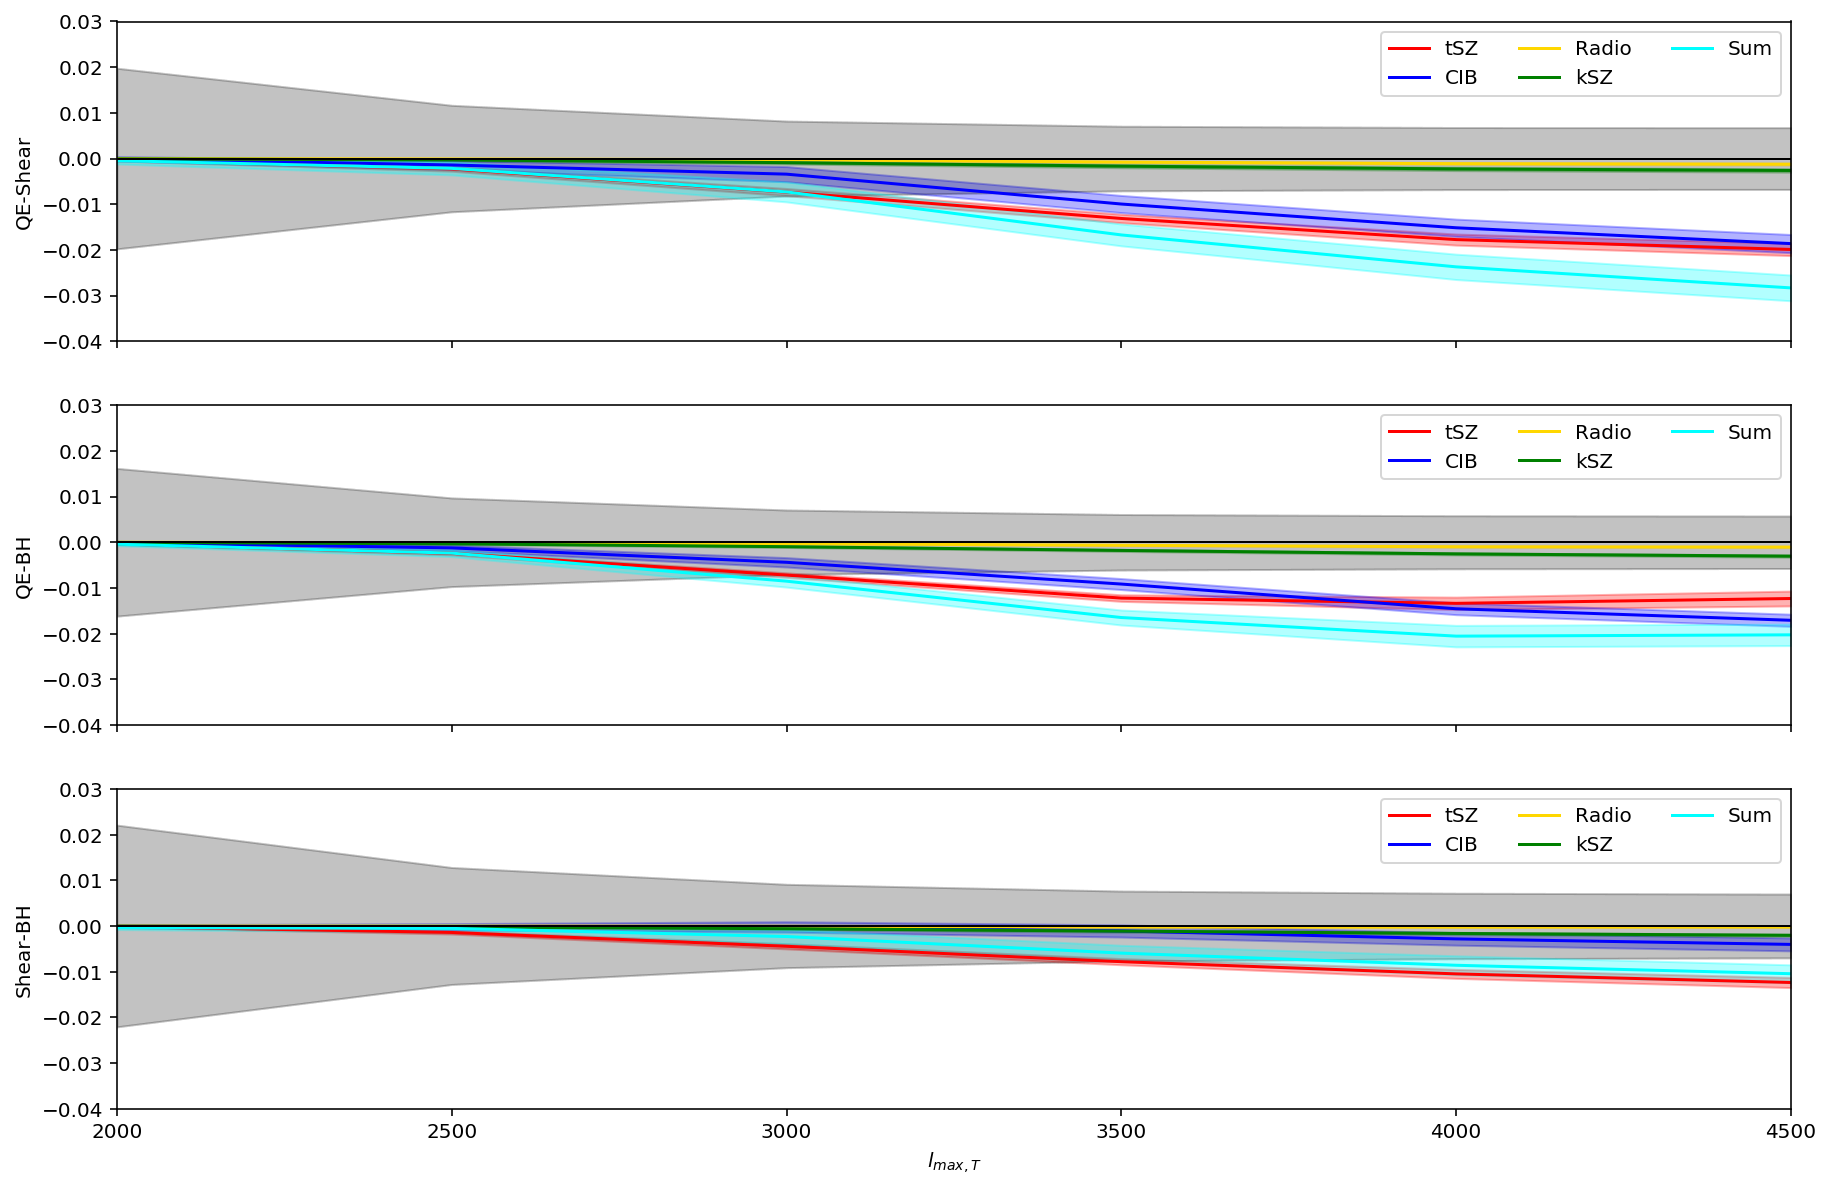

In [122]:
for case in cases:
    fig, ax = plt.subplots(nrows = len(estimators), sharex = True, figsize = (15, 10))
        
    kind = 0
    
    for index, estimator in enumerate(estimators):
        
        for index2 in range(index+1, len(estimators)):
             

            estimator2 = estimators[index2]

            print(f'Doing {estimator}-{estimator2}')

            for fgindex, fgnamefile in enumerate(fgnamefiles):

                noiseslist = []
                biaseslist = []
                
                scatters_list = []
                means_list = []

                for lmax_fixed in lmaxes_list: 

                    lmax_directory = get_lmax_directory(lmax_fixed, estimators)


                    P = PP/lmax_directory
                    Pfg = PP/lmax_directory/fgnamefile

                    getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
                    get = lambda key: np.load(Pfg/getoutname(key))

                    getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
                    getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

                    noises = get(noisetag)
                    theta = get('theta')
                    ells = get('ells')
                    kk = get('kk')
                    kg = get('kg')
                    gg = get('gg')

                    specificbias = get('totalbias')

                    #specificscatter = getscatter('totalbias')
                    
                    noises[index, index] *= 0.
                    theta[index, index, index, index] *= 0.
                    noises[index2, index2] *= 0.
                    theta[index2, index2, index2, index2] *= 0.
                    
                    specificbias[index, index] *= 0.
                    specificbias[index, index2] *= 0.

                    if case == autocase:
                        Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, specificbias, noises)
                        Opt = Optauto

                    f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                              sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                    nbins = Opt.nbins
                    zeros = np.zeros(3*nbins)
                    for j in range(nbins):
                        zeros[index+3*j:index+(3*j+1)] = 1./2.
                        zeros[index2+3*j:index2+(3*j+1)] = 1./2.

                    noiseslist += [n(zeros)]
                    biaseslist += [b(zeros)]
                    
                    dic = u.dictionary('output_biases/', lmax_directory)
                
                    biasestags = [trispectrumtag, primarytag, secondarytag]

                    total = []

                    for j in range(Nsims):
                        dictionary = dic.read(f'{fgnamefile}_{nu}_{j}')
                        temp = 0.
                        if case == autocase:
                            for k in biasestags:
                                temp += (u.get_element(dictionary[k], estimators))
                                
                        temp_bias = temp
                        
                        temp_bias[index, index] *= 0.
                        temp_bias[index, index2] *= 0.

                        if case == autocase:
                            Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, temp_bias, noises)
                            Opt = Optauto

                        f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                              sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                        total += [b(zeros)]

                    A, A_octanct = 81*20**2, 5156.6
                    factor_err = np.sqrt(A/A_octanct)

                    mean, scatter = u.get_mean_and_scatter(Nsims, total)

                    scatters_list += [scatter]
                    means_list += [mean]
                
                
                scatters_list = np.array(scatters_list)*factor_err
                means_list = np.array(means_list)

                noiseslist = np.array(noiseslist)
                biaseslist = np.array(biaseslist)
                ax[kind].plot(lmaxes_list, biaseslist, color = colors_fgs[fgnamefile], label = labels_fgs[fgnamefile])
                ax[kind].fill_between(lmaxes_list, -noiseslist, noiseslist, color = 'black', alpha = 0.05)
                
                ax[kind].fill_between(lmaxes_list, biaseslist-scatters_list, biaseslist+scatters_list, color = colors_fgs[fgnamefile], alpha = 0.3)

            ax[kind].axhline(y = 0, color = 'black', lw = 1)
            ax[kind].set_ylim(-0.04, 0.03)
            ax[kind].set_ylabel(labels_ests[estimator]+'-'+labels_ests[estimator2])
            ax[kind].legend(ncol = len(estimators))
            ax[-1].set_xlim(2000, 4500)
            ax[-1].set_xlabel('$l_{max,T}$')

            kind += 1
            
    fig.savefig(paperplots/f'alens_{case}_crosses_biases.png', dpi = 300)
    plt.show()

### SNR vs Bias

### Optimization

In [53]:
noisebiasconstr = False

In [142]:
results_directory = 'resultssumfg/'

In [143]:
def get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    
    
    if noisebiasconstr:
        n_equals_b_dir = 'noiseequalsbias'
    else:
        n_equals_b_dir = ''

    if invvariance:
        inv_variance_dir = 'inversevariance'
    else:
        inv_variance_dir = ''
    
    PP = pathlib.Path(analysis_directory)

    P = PP/lmax_directory
    

    getoutname = lambda key: f'{key}_{nu}.npy'
    noises = np.load(P/getoutname(noisetag))

    biases = np.load(P/getoutname('sum_all_totalabsbias'))

    biasescross = np.load(P/getoutname('sum_all_crosstotalabsbias'))

    kg = np.load(P/getoutname('kg'))
    kk = np.load(P/getoutname('kk'))
    gg = np.load(P/getoutname('gg'))
    ells = np.load(P/getoutname('ells'))
    theta = np.load(P/getoutname('theta'))
    thetacross = np.load(P/getoutname('thetacross'))

    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    resultkk = best.Res(None, None)
    resultkk.load_all(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'auto_fb_{fb}')
    biases = resultkk.load(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'biases')

    directory_of_saving = pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir
    dic = u.dictionary(directory_of_saving)

    dic.read(f'results_fb_{fb}')
    
    return dic

In [144]:
def get_combined_stuff(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    
    
    if noisebiasconstr:
        n_equals_b_dir = 'noiseequalsbias'
    else:
        n_equals_b_dir = ''

    if invvariance:
        inv_variance_dir = 'inversevariance'
    else:
        inv_variance_dir = ''
    
    PP = pathlib.Path(analysis_directory)

    P = PP/lmax_directory
    

    getoutname = lambda key: f'{key}_{nu}.npy'
    noises = np.load(P/getoutname(noisetag))

    biases = np.load(P/getoutname('sum_all_totalbias'))
    biasescross = np.load(P/getoutname('sum_all_crosstotalbias'))
    

    kg = np.load(P/getoutname('kg'))
    kk = np.load(P/getoutname('kk'))
    gg = np.load(P/getoutname('gg'))
    ells = np.load(P/getoutname('ells'))
    theta = np.load(P/getoutname('theta'))
    thetacross = np.load(P/getoutname('thetacross'))
    
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    Optimizerkg = best.Opt(estimators, lmin_sel, lmax_sel, ells, kg, thetacross, biasescross, noises)
    
    
    resultkk = best.Res(None, None)
    resultkk.load_all(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'auto_fb_{fb}')
    biases = resultkk.load(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'biases')
    biasescross = resultkk.load(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'cross_biases')
    
    Optimizerkk.biases_selected = biases
    Optimizerkg.biases_selected = biasescross
    
    directory_of_saving = pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir
    dic = u.dictionary(directory_of_saving)
    
    dic.read(f'results_fb_{fb}')
    
    wh = dic.dictionary['auto']['wh']
    ws = dic.dictionary['auto']['ws']
    wbh = dic.dictionary['auto']['wbh']
    wl = dic.dictionary['auto']['wl']
    
    
    a = np.c_[wh, ws, wbh]
    wsa = (wh, ws, wbh, wl)
    
    combinedn = Optimizerkk.get_bias_part(a, Optimizerkk.noises_selected)
    combinedb = Optimizerkk.get_bias_part(a, Optimizerkk.biases_selected)
    
    
    wh = dic.dictionary['cross']['wh']
    ws = dic.dictionary['cross']['ws']
    wbh = dic.dictionary['cross']['wbh']
    wl = dic.dictionary['cross']['wl']
    
    wsc = (wh, ws, wbh, wl)
    
    a = np.c_[wh, ws, wbh]
    
    combinedcn = Optimizerkg.get_bias_part(a, Optimizerkg.noises_selected)
    combinedcb = Optimizerkg.get_bias_part(a, Optimizerkg.biases_selected)
    
    return wsa, wsc, Optimizerkk, Optimizerkg, combinedn, combinedb, combinedcn, combinedcb

In [145]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar)


def get_est_weights(Opt, index, invvar):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
   '''
    nbins = Opt.nbins
    zeros = np.zeros(3*nbins)
    for j in range(nbins):
        zeros[index+3*j:index+(3*j+1)] = 1.
    return zeros

In [146]:

def get_ws(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):

    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    w1, w2, w3, wl = dic.dictionary['auto']['wh'], dic.dictionary['auto']['ws'], dic.dictionary['auto']['wbh'], dic.dictionary['auto']['wl']

    w1c, w2c, w3c, wlc = dic.dictionary['cross']['wh'], dic.dictionary['cross']['ws'], dic.dictionary['cross']['wbh'], dic.dictionary['cross']['wl']
    
    return dic.dictionary['ells'], w1, w2, w3, wl, w1c, w2c, w3c, wlc



def get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    auto, cross = dic.dictionary['auto']['total'], dic.dictionary['cross']['total']
    return auto, cross

def get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    auto, cross = dic.dictionary['auto']['noise'], dic.dictionary['cross']['noise']
    
    h, s, b = dic.dictionary['auto']['noisehuok'], dic.dictionary['auto']['noiseshear'], dic.dictionary['auto']['noisebh']
    hc, sc, bc = dic.dictionary['cross']['noisehuok'], dic.dictionary['cross']['noiseshear'], dic.dictionary['cross']['noisebh']
    
    return auto, cross, h, s, b, hc, sc, bc

def get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    auto, cross = dic.dictionary['auto']['bias'], dic.dictionary['cross']['bias']
    
    h, s, b = dic.dictionary['auto']['biashuok'], dic.dictionary['auto']['biasshear'], dic.dictionary['auto']['biasbh']
    
    hc, sc, bc = dic.dictionary['cross']['biashuok'], dic.dictionary['cross']['biasshear'], dic.dictionary['cross']['biasbh']
    
    return auto, cross, h, s, b, hc, sc, bc

In [147]:
def plot_fixed(fb, all_lmaxes_directories):
        fig, ax = plt.subplots(nrows = 5, sharex = True)

        fig2, ax2 = plt.subplots(nrows = 4, sharex = True)

        fig.suptitle(f'Case of fb = {fb}')

        fig2.suptitle(f'Cross Case of fb = {fb}')

        for fgnamefile in [fgnamefiles[0]]:
            for allmaxes in all_lmaxes_directories:
                print(allmaxes)
                h, s, b = re.findall(r'\d+', allmaxes)
                lmaxes_configs = [(h, s, b)]
                for lmaxes in lmaxes_configs:
                    lmaxes_dict = {}
                    lmax_directory = ''
                    for e_index, e in enumerate(estimators):
                        l = lmaxes[e_index]
                        lmaxes_dict[e] = l
                        lmax_directory += f'{names[e]}{l}'

                    #print('Doing for', lmax_directory)
                    invvariance = False
                    ws, wsc, Opt, Optkg, combinedn, combinedb, combinedcn, combinedcb = get_combined_stuff(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                                 fgnamefile, lmax_directory, fb)

                    ells = Opt.ells_selected
                    
                    kk = Opt.theory_selected

                    b = Opt.biases_selected
                    n = Opt.noises_selected

                    ax[0].plot(ells, combinedb/kk, color = 'purple', label = 'Combined', marker = 'o')
                    ax[0].plot(ells, b[0, 0]/kk, color = 'blue', label = 'H')
                    ax[0].plot(ells, b[1, 1]/kk, color = 'red', label = 'S')
                    ax[0].plot(ells, b[2, 2]/kk, color = 'green', label = 'B')

                    ax[1].plot(ells, combinedn, color = 'purple', label = 'Combined', marker = 'o')
                    ax[1].plot(ells, n[0, 0], color = 'blue', label = 'H')
                    ax[1].plot(ells, n[1, 1], color = 'red', label = 'S')
                    ax[1].plot(ells, n[2, 2], color = 'green', label = 'B')

                    w1, w2, w3, wl = ws

                    ax[2].plot(ells, w1, color = 'blue', label = 'H')
                    ax[2].plot(ells, w2, color = 'red', label = 'S')
                    ax[2].plot(ells, w3, color = 'green', label = 'B')

                    ax[3].plot(ells, wl, color = 'black')
                    
                    ax[4].plot(ells, w1*wl*ells, color = 'blue', label = 'H')
                    ax[4].plot(ells, w2*wl*ells, color = 'red', label = 'S')
                    ax[4].plot(ells, w3*wl*ells, color = 'green', label = 'B')




                    b = Optkg.biases_selected
                    n = Optkg.noises_selected

                    w1, w2, w3, wl = wsc

                    ax2[0].plot(ells, combinedcb, color = 'purple', label = 'Combined', marker = 'o')
                    ax2[0].plot(ells, b[0], color = 'blue', label = 'H')
                    ax2[0].plot(ells, b[1], color = 'red', label = 'S')
                    ax2[0].plot(ells, b[2], color = 'green', label = 'B')


                    ax2[1].plot(ells, w1, color = 'blue', label = 'H')
                    ax2[1].plot(ells, w2, color = 'red', label = 'S')
                    ax2[1].plot(ells, w3, color = 'green', label = 'B')

                    ax2[2].plot(ells, wl, color = 'black')
                    
                    ax2[3].plot(ells, w1*wl*ells, color = 'blue', label = 'H')
                    ax2[3].plot(ells, w2*wl*ells, color = 'red', label = 'S')
                    ax2[3].plot(ells, w3*wl*ells, color = 'green', label = 'B')


                    invvariance = True
                    ws, wsc, Opt, Optkg, combinedn, combinedb, combinedcn, combinedcb = get_combined_stuff(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                                 fgnamefile, lmax_directory, fb)


                    w1, w2, w3, wl = ws

                    ax[2].plot(ells, w1, color = 'blue', ls = '--', alpha = 0.4)
                    ax[2].plot(ells, w2, color = 'red', ls = '--', alpha = 0.4)
                    ax[2].plot(ells, w3, color = 'green', ls = '--', alpha = 0.4)

                    ax[3].plot(ells, wl, color = 'black', ls = '--', alpha = 0.4)
                    
                    ax[4].plot(ells, w1*wl*ells, color = 'blue', label = 'H', ls = '--', alpha = 0.4)
                    ax[4].plot(ells, w2*wl*ells, color = 'red', label = 'S', ls = '--', alpha = 0.4)
                    ax[4].plot(ells, w3*wl*ells, color = 'green', label = 'B', ls = '--', alpha = 0.4)

                    w1, w2, w3, wl = wsc

                    ax2[1].plot(ells, w1, color = 'blue', ls = '--', alpha = 0.4)
                    ax2[1].plot(ells, w2, color = 'red', ls = '--', alpha = 0.4)
                    ax2[1].plot(ells, w3, color = 'green', ls = '--', alpha = 0.4)

                    ax2[2].plot(ells, wl, color = 'black', ls = '--', alpha = 0.4)
                    
                    ax2[3].plot(ells, w1*wl*ells, color = 'blue', label = 'H', ls = '--', alpha = 0.4)
                    ax2[3].plot(ells, w2*wl*ells, color = 'red', label = 'S', ls = '--', alpha = 0.4)
                    ax2[3].plot(ells, w3*wl*ells, color = 'green', label = 'B', ls = '--', alpha = 0.4)


        ax[0].set_ylabel('$B$')
        ax[1].set_ylabel('$N$')
        ax[2].set_ylabel('$W$')
        ax[3].set_ylabel('$W_L$')
        ax[4].set_ylabel('$LWW_L$')
        ax[0].set_xscale('log')
        ax[0].legend(ncol = 4)

        ax2[0].set_ylabel('$B$')
        ax2[1].set_ylabel('$W$')
        ax2[2].set_ylabel('$W_L$')
        ax2[3].set_ylabel('$LWW_L$')
        ax2[0].set_xscale('log')
        ax2[0].legend(ncol = 4)

        plt.show()




#### Check a fixed config

In [148]:
fbs = [1.]

In [149]:
all_lmaxes_directories = ['h3500s3500b3500']

h3500s3500b3500


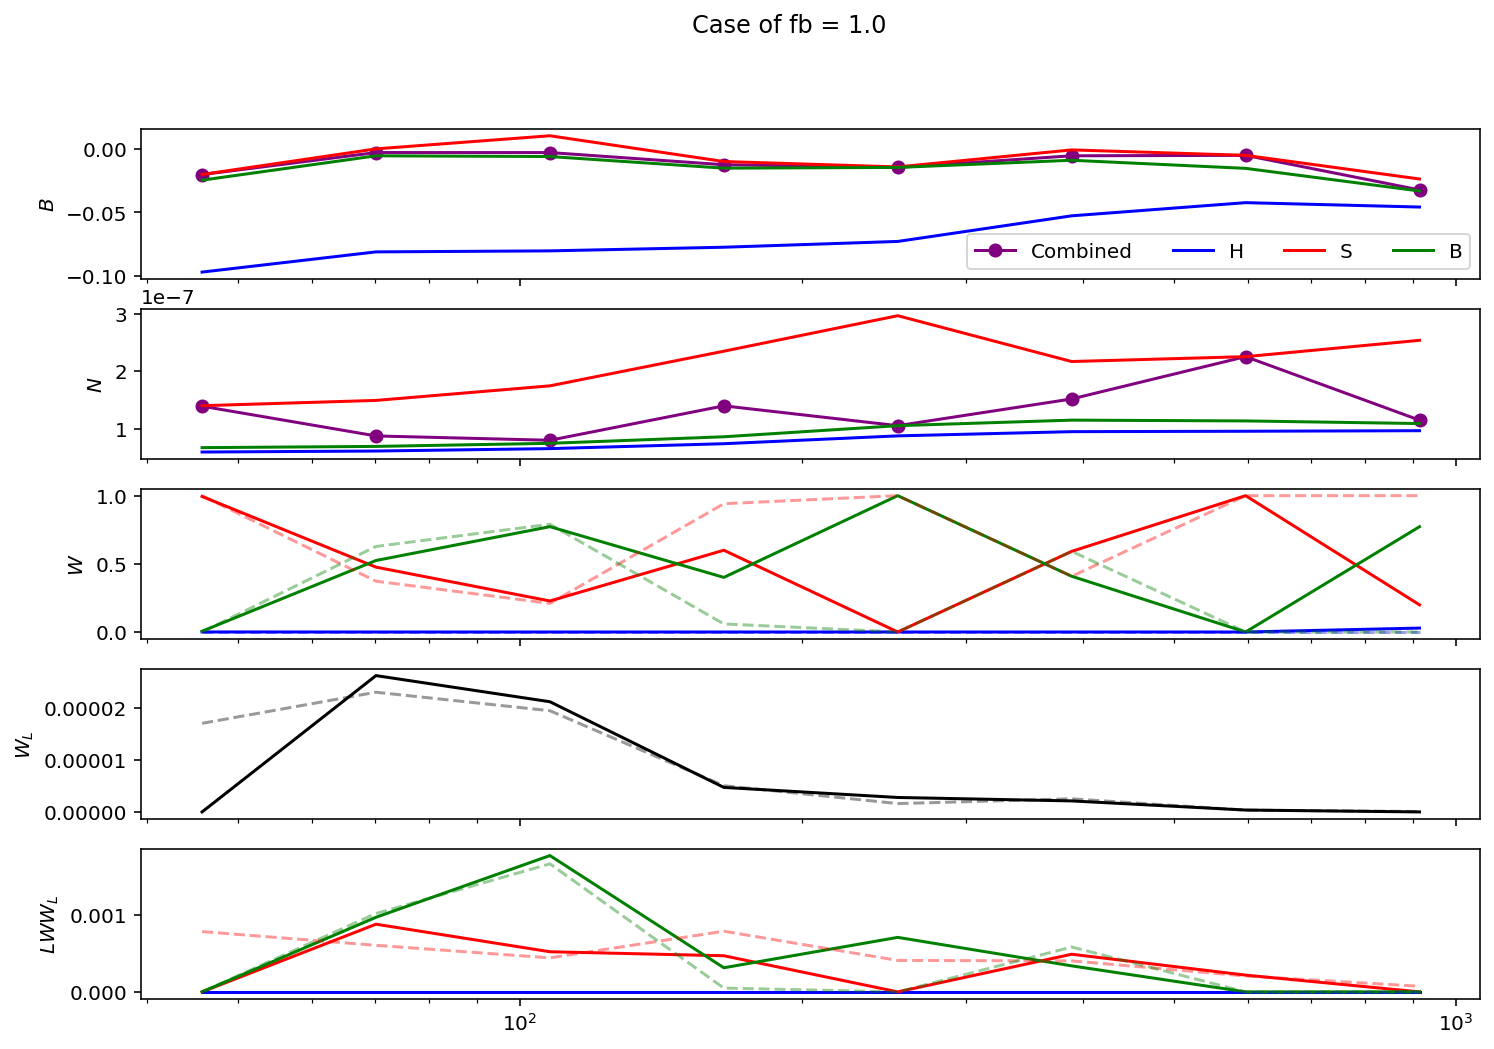

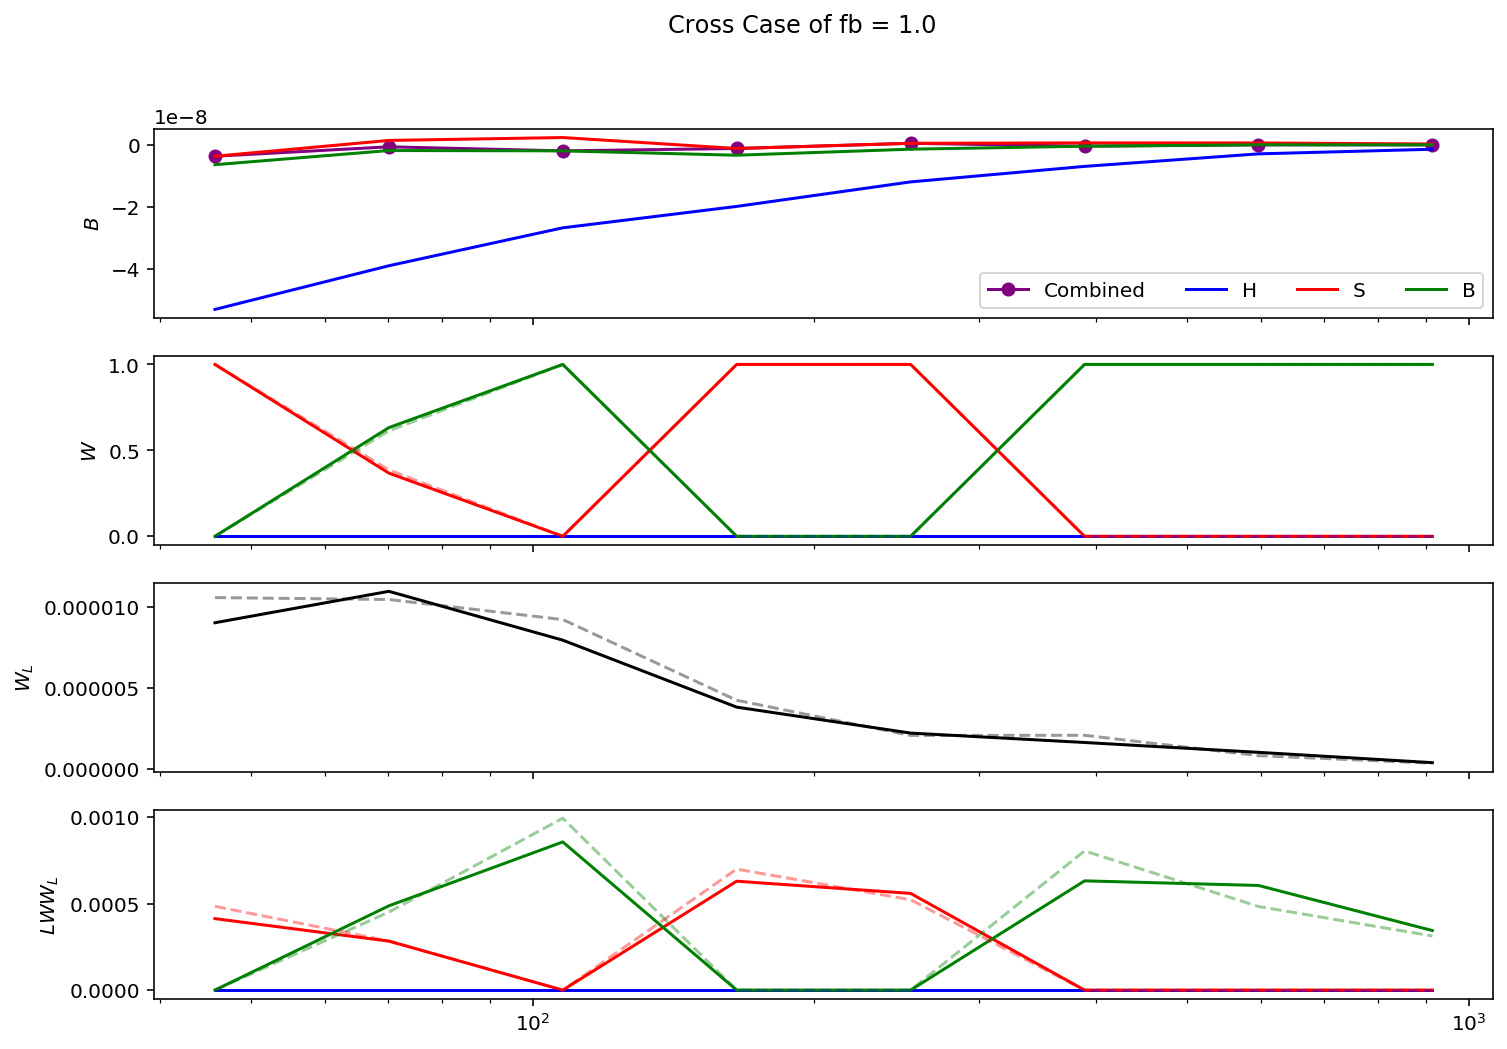

In [150]:
for fb in fbs:
    plot_fixed(fb, all_lmaxes_directories)

#### Run min for fb = 0., fb = 1.

In [151]:
path = pathlib.Path('output/')
all_lmaxes_directories =  [x.name for x in path.iterdir() if x.is_dir()]

In [152]:
invvariance = False

In [153]:
fb = 1.

In [154]:
autos = {}
crosses = {}

la = []
lc = []

lamv = []
lcmv = []

autosn = {}
crossesn = {}

lan = []
lcn = []

lanmv = []
lcnmv = []

autosb = {}
crossesb = {}

lab = []
lcb = []

labmv = []
lcbmv = []

lBh = []
lBs = []
lBb = []
lNh = []
lNs = []
lNb = []

lBhc = []
lBsc = []
lBbc = []
lNhc = []
lNsc = []
lNbc = []

for fgnamefile in [fgnamefiles[0]]:
    for lmax_directory in all_lmaxes_directories:
            a, c = get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                 fgnamefile, lmax_directory, fb)
            autos[lmax_directory] = a
            crosses[lmax_directory] = c
            
            la += [a]
            lc += [c]
            
            a, c = get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, True,
                 fgnamefile, lmax_directory, fb)
            
            lamv += [a]
            lcmv += [c]
            
            a, c, h, s, b, hc, sc, bc = get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                 fgnamefile, lmax_directory, fb)
            autosb[lmax_directory] = a
            crossesb[lmax_directory] = c
            
            lab += [a]
            lcb += [c]
            
            
            lBh += [h]
            lBs += [s]
            lBb += [b]
            
            lBhc += [hc]
            lBsc += [sc]
            lBbc += [bc]
            
            a, c, h, s, b, hc, sc, bc = get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                 fgnamefile, lmax_directory, fb)
            autosn[lmax_directory] = a
            crossesn[lmax_directory] = c
            
            lan += [a]
            lcn += [c]
            
            lNh += [h]
            lNs += [s]
            lNb += [b]
            
            lNhc += [hc]
            lNsc += [sc]
            lNbc += [bc]
            
            a, c, h, s, b, hc, sc, bc = get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, True,
                 fgnamefile, lmax_directory, fb)            
            lanmv += [a]
            lcnmv += [c]
            
            a, c, h, s, b, hc, sc, bc = get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, True,
                 fgnamefile, lmax_directory, fb)            
            labmv += [a]
            lcbmv += [c]

In [155]:
import pandas

In [168]:
data = {}
data['Name'] = all_lmaxes_directories
data['Total Auto'] = la

data['Total Mv Auto'] = lamv

data['Bias Auto'] = lab
data['Noise Auto'] = lan
data['Detectable Auto'] = abs(np.array(lab))>np.array(lan)

data['Bias Mv Auto'] = labmv
data['Noise Mv Auto'] = lanmv
data['Detectable Mv Auto'] = abs(np.array(labmv))>np.array(lanmv)

data['Bias relative to H'] = np.array(lab)/np.array(lBhc)
data['Noise relative to H'] = np.array(lan)/np.array(lNhc)

data['Bias Mv relative to H'] = np.array(labmv)/np.array(lBhc)
data['Noise Mv relative to H'] = np.array(lanmv)/np.array(lNhc)

data['Bias H'] = lBh
data['Noise H'] = lNh
data['Bias S'] = lBs
data['Noise S'] = lNs
data['Bias BH'] = lBb
data['Noise BH'] = lNb

df_auto = pandas.DataFrame(data)

data = {}

data['Name'] = all_lmaxes_directories

data['Total Cross'] = lc
data['Total Mv Cross'] = lcmv
data['Bias Cross'] = lcb
data['Noise Cross'] = lcn
data['Detectable Cross'] = abs(np.array(lcb))>np.array(lcn)

data['Bias Mv Cross'] = lcbmv
data['Noise Mv Cross'] = lcnmv
data['Detectable Mv Cross'] = abs(np.array(lcbmv))>np.array(lcnmv)


data['Bias relative to H'] = np.array(lcb)/np.array(lBhc)
data['Noise relative to H'] = np.array(lcn)/np.array(lNhc)

data['Bias Mv relative to H'] = np.array(lcbmv)/np.array(lBhc)
data['Noise Mv relative to H'] = np.array(lcnmv)/np.array(lNhc)

data['Bias H'] = lBhc
data['Noise H'] = lNhc
data['Bias S'] = lBsc
data['Noise S'] = lNsc
data['Bias BH'] = lBbc
data['Noise BH'] = lNbc

df_cross = pandas.DataFrame(data)

In [171]:
df_auto

Name  Total Auto  Total Mv Auto  Bias Auto  Noise Auto  \
0    h3500s3500b4500    0.000181       0.000174  -0.007342    0.011271   
1    h4500s4000b4000    0.000149       0.000165  -0.007372    0.009720   
2    h3500s4000b3000    0.000106       0.000133  -0.004955    0.009016   
3    h4000s4000b3500    0.000134       0.000159  -0.006997    0.009204   
4    h2500s2000b2000    0.000282       0.000289  -0.009101    0.014107   
..               ...         ...            ...        ...         ...   
123  h4000s4500b3000    0.000111       0.000136  -0.004923    0.009307   
124  h2500s4000b4500    0.000160       0.000220  -0.006335    0.010926   
125  h4500s3500b3000    0.000104       0.000108  -0.004248    0.009259   
126  h3500s4000b3500    0.000134       0.000159  -0.006997    0.009204   
127  h3000s3000b2500    0.000129       0.000132  -0.003675    0.010765   

     Detectable Auto  Bias Mv Auto  Noise Mv Auto  Detectable Mv Auto  \
0              False     -0.006361       0.011540               False   
1              False     -0.008888       0.009257               False   
2              False     -0.007805       0.008490               False   
3              False     -0.009447       0.008332                True   
4              False     -0.009033       0.014403               False   
..               ...           ...            ...                 ...   
123            False     -0.008000       0.008485               False   
124            False     -0.012551       0.007906                True   
125            False     -0.004984       0.009115               False   
126            False     -0.009447       0.008332                True   
127            False     -0.003863       0.010808               False   

     Bias relative to H  Noise relative to H  Bias Mv relative to H  \
0              0.082497             1.872696               0.071480   
1              0.049460             1.653467               0.059637   
2              0.055680             1.498152               0.087703   
3              0.054393             1.561116               0.073442   
4              0.508645             1.825662               0.504816   
..                  ...                  ...                    ...   
123            0.038275             1.578549               0.062194   
124            0.354031             1.413973               0.701445   
125            0.028502             1.574969               0.033439   
126            0.078622             1.529329               0.106157   
127            0.079234             1.656749               0.083275   

     Noise Mv relative to H    Bias H   Noise H    Bias S   Noise S   Bias BH  \
0                  1.917457 -0.062991  0.006347 -0.004319  0.012248 -0.018837   
1                  1.574703 -0.065850  0.006071 -0.005301  0.011726 -0.017064   
2                  1.410760 -0.062991  0.006347 -0.005301  0.011726 -0.008656   
3                  1.413262 -0.067501  0.006103 -0.005301  0.011726 -0.013267   
4                  1.863903 -0.020885  0.010082 -0.002089  0.037693 -0.002415   
..                      ...       ...       ...       ...       ...       ...   
123                1.439185 -0.067501  0.006103 -0.008403  0.011656 -0.008656   
124                1.023153 -0.020885  0.010082 -0.005301  0.011726 -0.018837   
125                1.550559 -0.065850  0.006071 -0.004319  0.012248 -0.008656   
126                1.384486 -0.062991  0.006347 -0.005301  0.011726 -0.013267   
127                1.663426 -0.044842  0.007320 -0.000358  0.014313 -0.004553   

     Noise BH  
0    0.006368  
1    0.006578  
2    0.008379  
3    0.007039  
4    0.019262  
..        ...  
123  0.008379  
124  0.006368  
125  0.008379  
126  0.007039  
127  0.011431  

[128 rows x 19 columns]

In [172]:
0.009259**2+(-0.004248)**2

0.00010377458499999999

In [173]:
df_auto.sort_values('Total Mv Auto')

Name  Total Auto  Total Mv Auto  Bias Auto  Noise Auto  \
116  h2000s3500b3000    0.000104       0.000106  -0.004248    0.009259   
110  h2500s3500b3000    0.000104       0.000108  -0.004248    0.009259   
101  h3500s3500b3000    0.000104       0.000108  -0.004248    0.009259   
125  h4500s3500b3000    0.000104       0.000108  -0.004248    0.009259   
111  h3000s3500b3000    0.000104       0.000108  -0.004248    0.009259   
..               ...         ...            ...        ...         ...   
23   h4000s4000b4500    0.000156       0.000302  -0.007695    0.009836   
66   h3500s4500b4500    0.000173       0.000307  -0.008461    0.010083   
16   h3000s3500b4500    0.000164       0.000311  -0.007977    0.010042   
98   h4000s3500b4500    0.000164       0.000311  -0.007977    0.010042   
73   h2000s2000b2000    0.000338       0.000338  -0.005941    0.017397   

     Detectable Auto  Bias Mv Auto  Noise Mv Auto  Detectable Mv Auto  \
116            False     -0.004616       0.009197               False   
110            False     -0.004984       0.009115               False   
101            False     -0.004984       0.009115               False   
125            False     -0.004984       0.009115               False   
111            False     -0.004984       0.009115               False   
..               ...           ...            ...                 ...   
23             False     -0.015964       0.006897                True   
66             False     -0.016091       0.006902                True   
16             False     -0.016198       0.006943                True   
98             False     -0.016198       0.006943                True   
73             False     -0.005996       0.017388               False   

     Bias relative to H  Noise relative to H  Bias Mv relative to H  \
116            0.596261             0.898260               0.647881   
110            0.237417             1.198203               0.278537   
101            0.047735             1.538400               0.056003   
125            0.028502             1.574969               0.033439   
111            0.091587             1.424911               0.107449   
..                  ...                  ...                    ...   
23             0.059823             1.668287               0.124102   
66             0.095071             1.675312               0.180810   
16             0.171988             1.545480               0.349233   
98             0.062016             1.703253               0.125928   
73             0.833899             1.687826               0.841573   

     Noise Mv relative to H    Bias H   Noise H    Bias S   Noise S   Bias BH  \
116                0.892265 -0.009600  0.016758 -0.004319  0.012248 -0.008656   
110                1.179632 -0.020885  0.010082 -0.004319  0.012248 -0.008656   
101                1.514556 -0.062991  0.006347 -0.004319  0.012248 -0.008656   
125                1.550559 -0.065850  0.006071 -0.004319  0.012248 -0.008656   
111                1.402826 -0.044842  0.007320 -0.004319  0.012248 -0.008656   
..                      ...       ...       ...       ...       ...       ...   
23                 1.169871 -0.067501  0.006103 -0.005301  0.011726 -0.018837   
66                 1.146822 -0.062991  0.006347 -0.008403  0.011656 -0.018837   
16                 1.068519 -0.044842  0.007320 -0.004319  0.012248 -0.018837   
98                 1.177600 -0.067501  0.006103 -0.004319  0.012248 -0.018837   
73                 1.686969 -0.009600  0.016758 -0.002089  0.037693 -0.002415   

     Noise BH  
116  0.008379  
110  0.008379  
101  0.008379  
125  0.008379  
111  0.008379  
..        ...  
23   0.006368  
66   0.006368  
16   0.006368  
98   0.006368  
73   0.019262  

[128 rows x 19 columns]

h2500s3500b3000


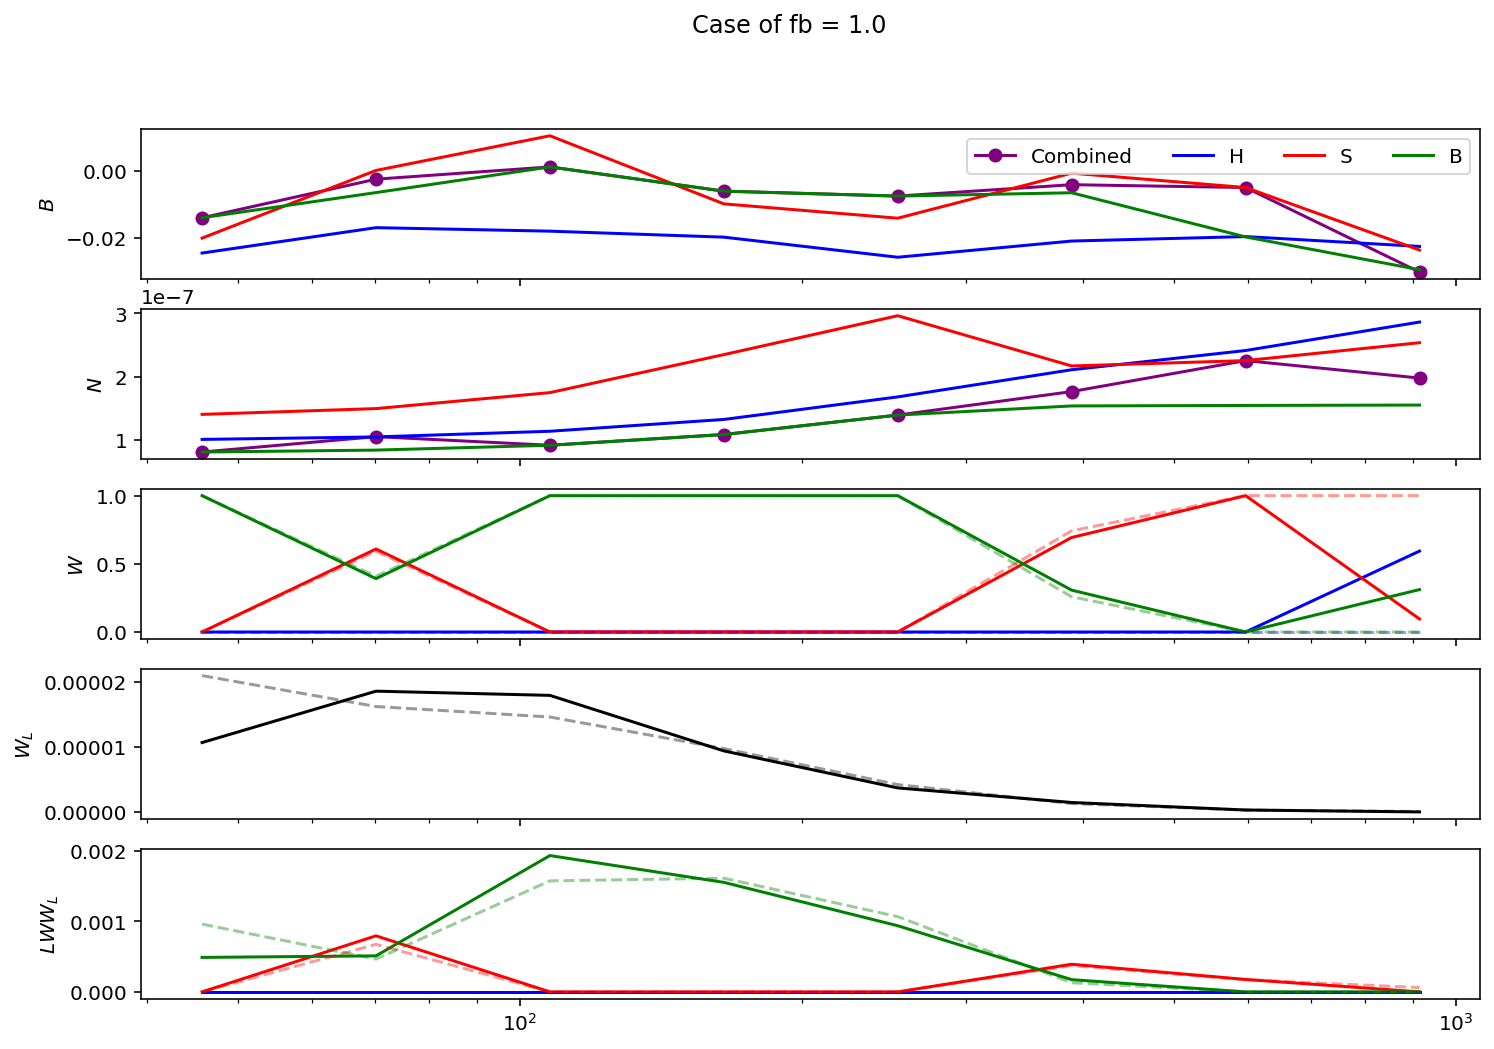

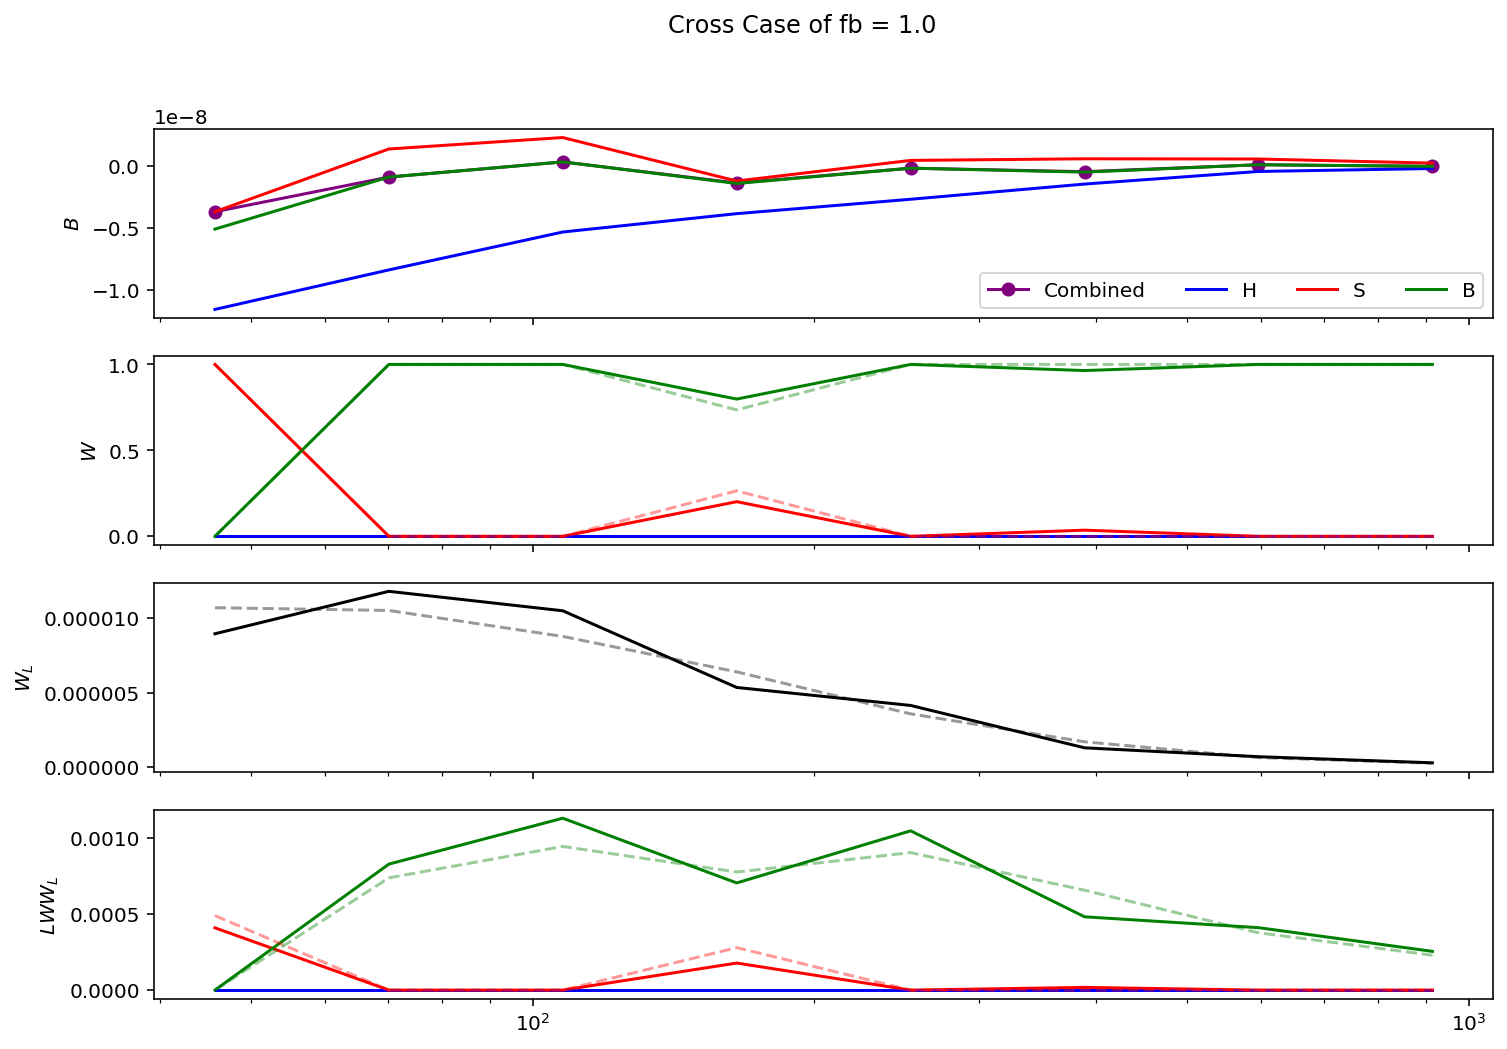

In [185]:
all_maxes = ['h2500s3500b3000']
plot_fixed(fb, all_maxes)

h3500s3000b2500


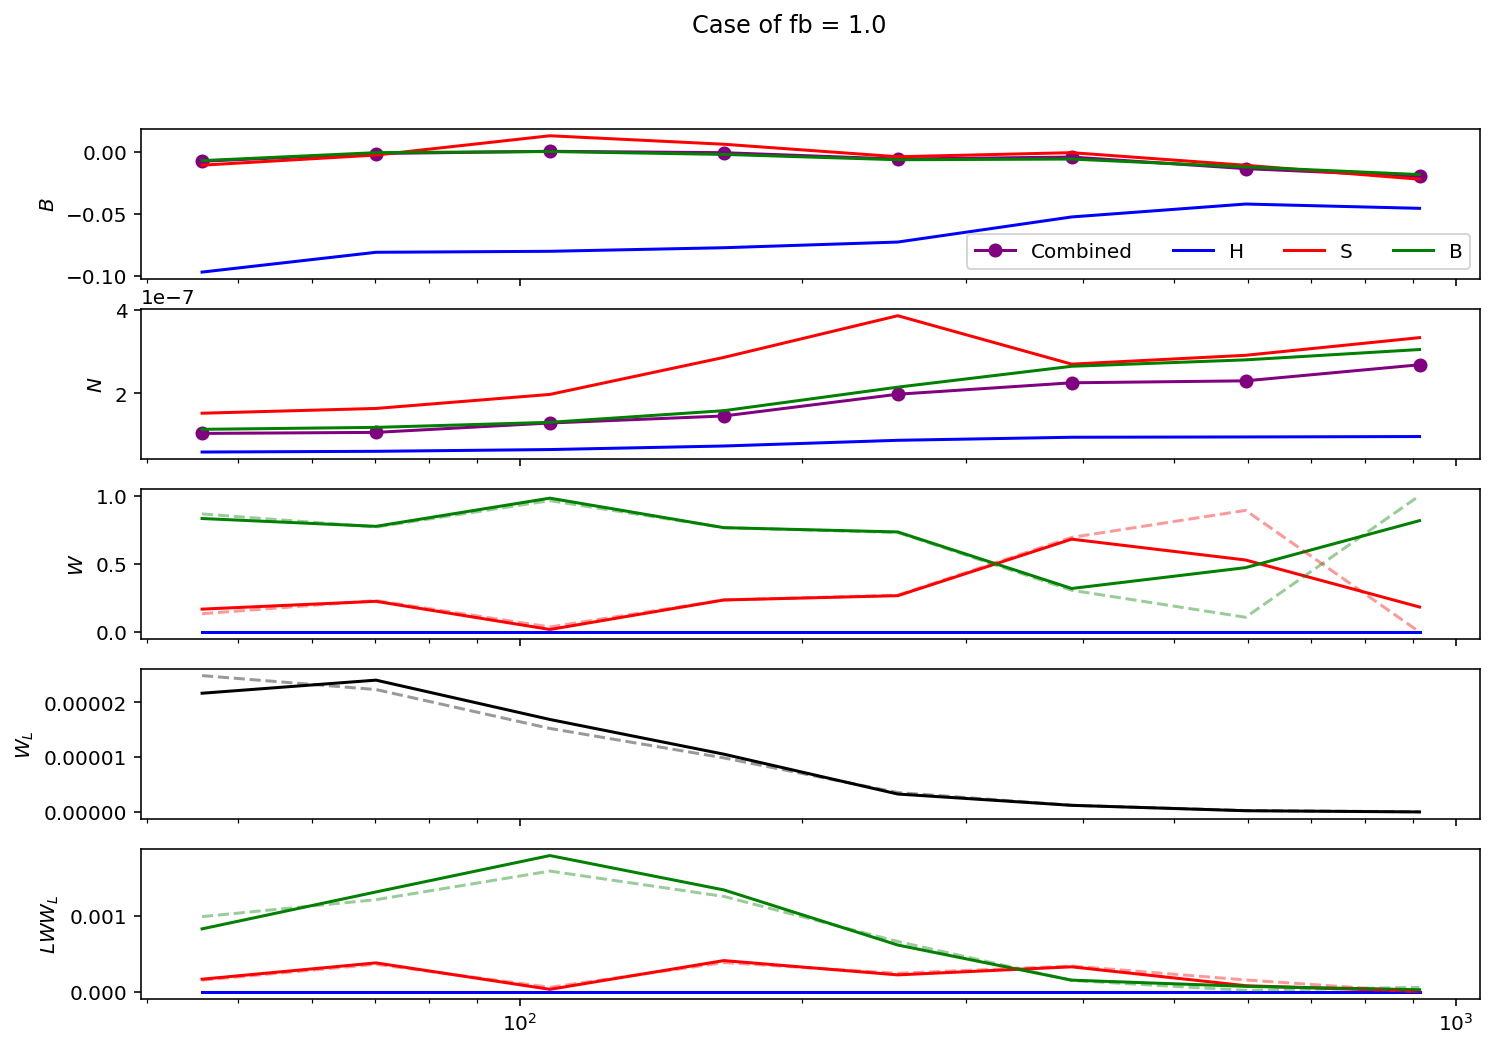

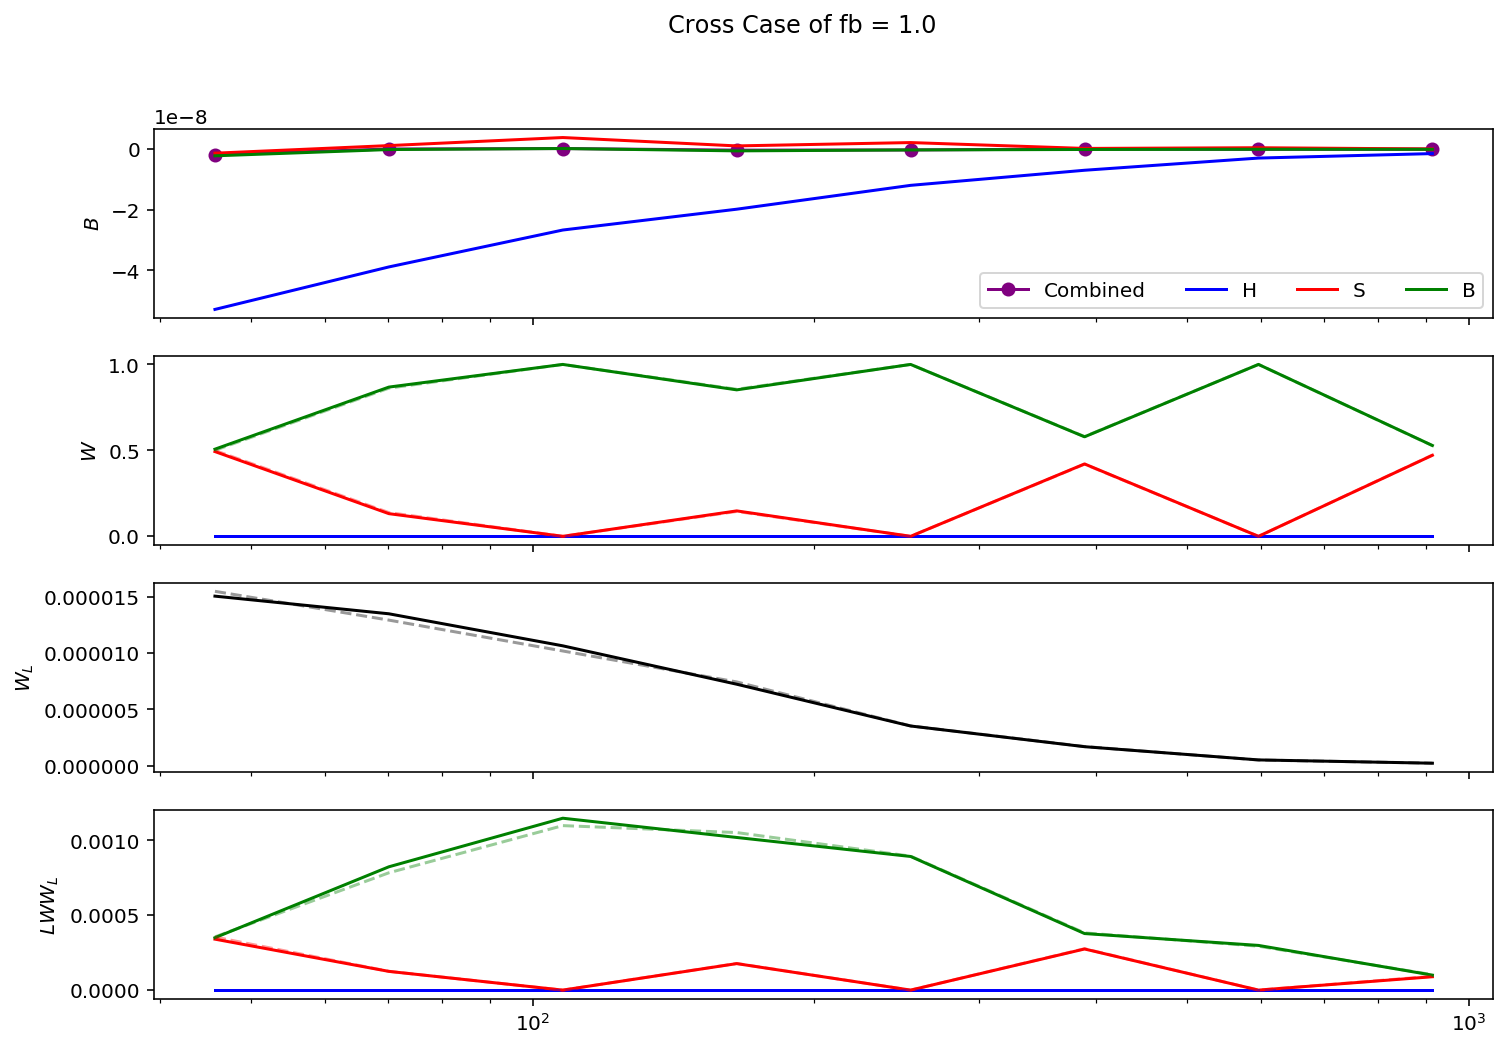

In [175]:
all_maxes = ['h3500s3000b2500']
plot_fixed(fb, all_maxes)

In [178]:
selection = df_auto['Detectable Mv Auto'] == False
new_df_auto = df_auto[selection].sort_values('Total Mv Auto', ascending = False)
new_df_auto

Name  Total Auto  Total Mv Auto  Bias Auto  Noise Auto  \
73   h2000s2000b2000    0.000338       0.000338  -0.005941    0.017397   
4    h2500s2000b2000    0.000282       0.000289  -0.009101    0.014107   
67   h2000s2500b2000    0.000255       0.000256  -0.004728    0.015268   
97   h2500s2500b2000    0.000237       0.000245  -0.006755    0.013826   
10   h2000s4500b4500    0.000171       0.000179  -0.006422    0.011373   
..               ...         ...            ...        ...         ...   
111  h3000s3500b3000    0.000104       0.000108  -0.004248    0.009259   
125  h4500s3500b3000    0.000104       0.000108  -0.004248    0.009259   
101  h3500s3500b3000    0.000104       0.000108  -0.004248    0.009259   
110  h2500s3500b3000    0.000104       0.000108  -0.004248    0.009259   
116  h2000s3500b3000    0.000104       0.000106  -0.004248    0.009259   

     Detectable Auto  Bias Mv Auto  Noise Mv Auto  Detectable Mv Auto  \
73             False     -0.005996       0.017388               False   
4              False     -0.009033       0.014403               False   
67             False     -0.004824       0.015257               False   
97             False     -0.006678       0.014148               False   
10             False     -0.005823       0.012060               False   
..               ...           ...            ...                 ...   
111            False     -0.004984       0.009115               False   
125            False     -0.004984       0.009115               False   
101            False     -0.004984       0.009115               False   
110            False     -0.004984       0.009115               False   
116            False     -0.004616       0.009197               False   

     Bias relative to H  Noise relative to H  Bias Mv relative to H  \
73             0.833899             1.687826               0.841573   
4              0.508645             1.825662               0.504816   
67             0.663596             1.481293               0.677063   
97             0.377551             1.789302               0.373201   
10             0.901489             1.103384               0.817283   
..                  ...                  ...                    ...   
111            0.091587             1.424911               0.107449   
125            0.028502             1.574969               0.033439   
101            0.047735             1.538400               0.056003   
110            0.237417             1.198203               0.278537   
116            0.596261             0.898260               0.647881   

     Noise Mv relative to H    Bias H   Noise H    Bias S   Noise S   Bias BH  \
73                 1.686969 -0.009600  0.016758 -0.002089  0.037693 -0.002415   
4                  1.863903 -0.020885  0.010082 -0.002089  0.037693 -0.002415   
67                 1.480238 -0.009600  0.016758 -0.001140  0.021544 -0.002415   
97                 1.830913 -0.020885  0.010082 -0.001140  0.021544 -0.002415   
10                 1.170046 -0.009600  0.016758 -0.008403  0.011656 -0.018837   
..                      ...       ...       ...       ...       ...       ...   
111                1.402826 -0.044842  0.007320 -0.004319  0.012248 -0.008656   
125                1.550559 -0.065850  0.006071 -0.004319  0.012248 -0.008656   
101                1.514556 -0.062991  0.006347 -0.004319  0.012248 -0.008656   
110                1.179632 -0.020885  0.010082 -0.004319  0.012248 -0.008656   
116                0.892265 -0.009600  0.016758 -0.004319  0.012248 -0.008656   

     Noise BH  
73   0.019262  
4    0.019262  
67   0.019262  
97   0.019262  
10   0.006368  
..        ...  
111  0.008379  
125  0.008379  
101  0.008379  
110  0.008379  
116  0.008379  

[93 rows x 19 columns]

In [179]:
new_df_auto[['Name', 'Total Mv Auto', 'Bias Mv Auto', 'Noise Mv Auto', 'Detectable Mv Auto', 'Bias Mv relative to H', 'Noise Mv relative to H', 'Bias H', 'Noise H', 'Bias S', 'Noise S', 'Bias BH', 'Noise BH']]

Name  Total Mv Auto  Bias Mv Auto  Noise Mv Auto  \
73   h2000s2000b2000       0.000338     -0.005996       0.017388   
4    h2500s2000b2000       0.000289     -0.009033       0.014403   
67   h2000s2500b2000       0.000256     -0.004824       0.015257   
97   h2500s2500b2000       0.000245     -0.006678       0.014148   
10   h2000s4500b4500       0.000179     -0.005823       0.012060   
..               ...            ...           ...            ...   
111  h3000s3500b3000       0.000108     -0.004984       0.009115   
125  h4500s3500b3000       0.000108     -0.004984       0.009115   
101  h3500s3500b3000       0.000108     -0.004984       0.009115   
110  h2500s3500b3000       0.000108     -0.004984       0.009115   
116  h2000s3500b3000       0.000106     -0.004616       0.009197   

     Detectable Mv Auto  Bias Mv relative to H  Noise Mv relative to H  \
73                False               0.841573                1.686969   
4                 False               0.504816                1.863903   
67                False               0.677063                1.480238   
97                False               0.373201                1.830913   
10                False               0.817283                1.170046   
..                  ...                    ...                     ...   
111               False               0.107449                1.402826   
125               False               0.033439                1.550559   
101               False               0.056003                1.514556   
110               False               0.278537                1.179632   
116               False               0.647881                0.892265   

       Bias H   Noise H    Bias S   Noise S   Bias BH  Noise BH  
73  -0.009600  0.016758 -0.002089  0.037693 -0.002415  0.019262  
4   -0.020885  0.010082 -0.002089  0.037693 -0.002415  0.019262  
67  -0.009600  0.016758 -0.001140  0.021544 -0.002415  0.019262  
97  -0.020885  0.010082 -0.001140  0.021544 -0.002415  0.019262  
10  -0.009600  0.016758 -0.008403  0.011656 -0.018837  0.006368  
..        ...       ...       ...       ...       ...       ...  
111 -0.044842  0.007320 -0.004319  0.012248 -0.008656  0.008379  
125 -0.065850  0.006071 -0.004319  0.012248 -0.008656  0.008379  
101 -0.062991  0.006347 -0.004319  0.012248 -0.008656  0.008379  
110 -0.020885  0.010082 -0.004319  0.012248 -0.008656  0.008379  
116 -0.009600  0.016758 -0.004319  0.012248 -0.008656  0.008379  

[93 rows x 13 columns]

h2000s3500b4500


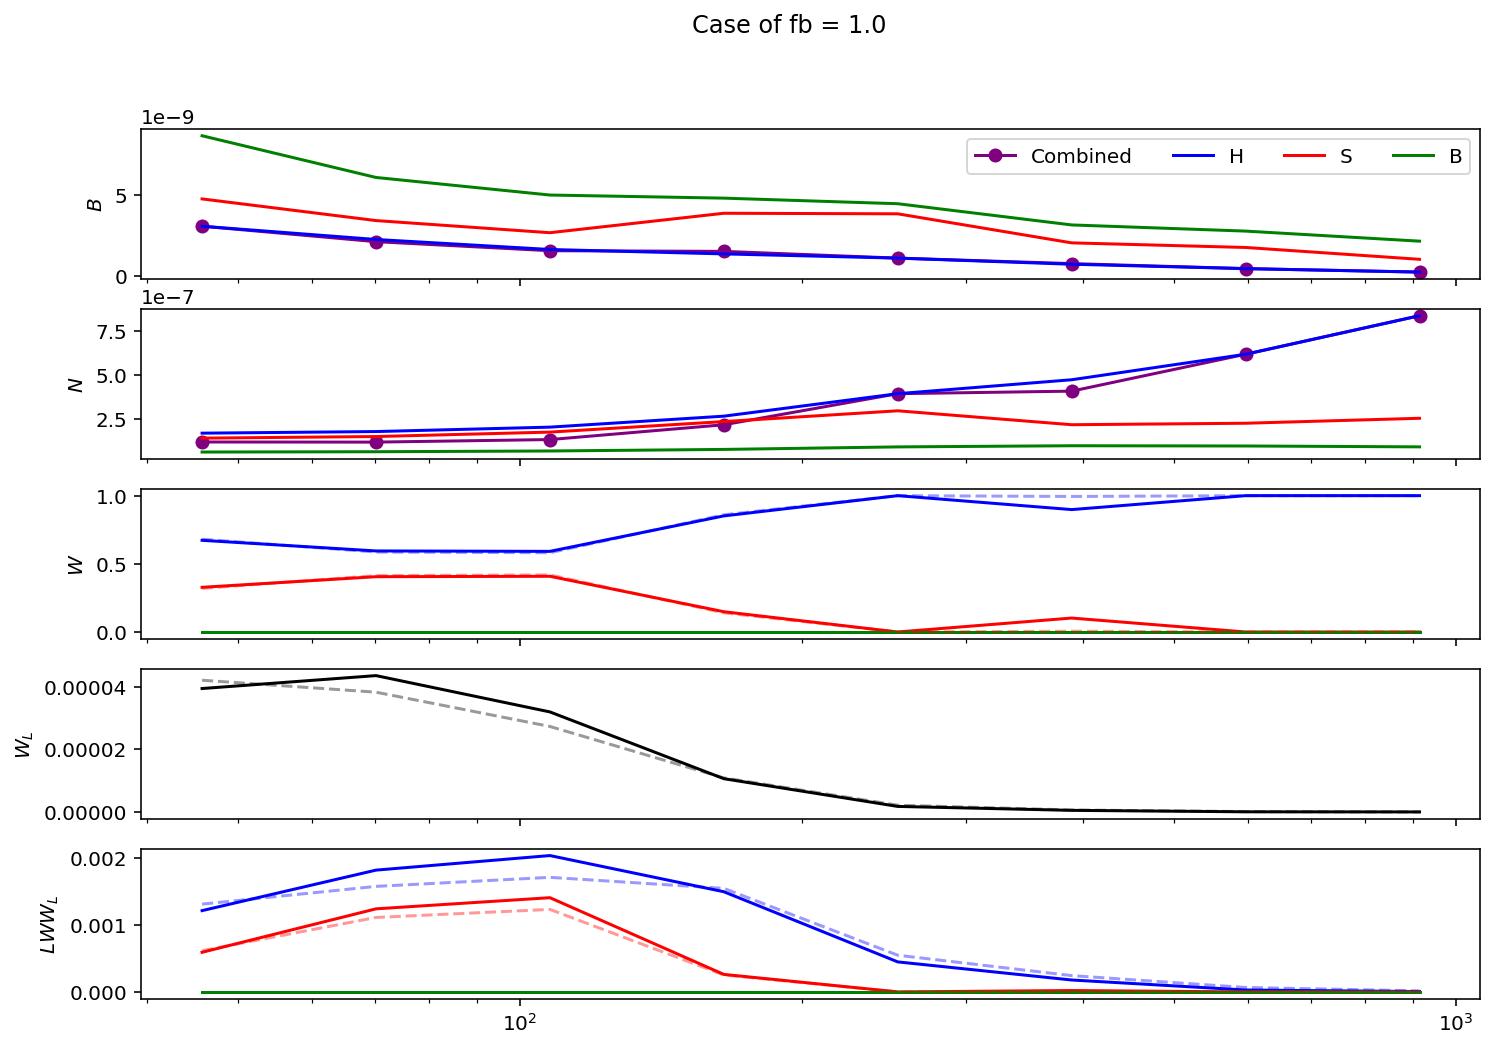

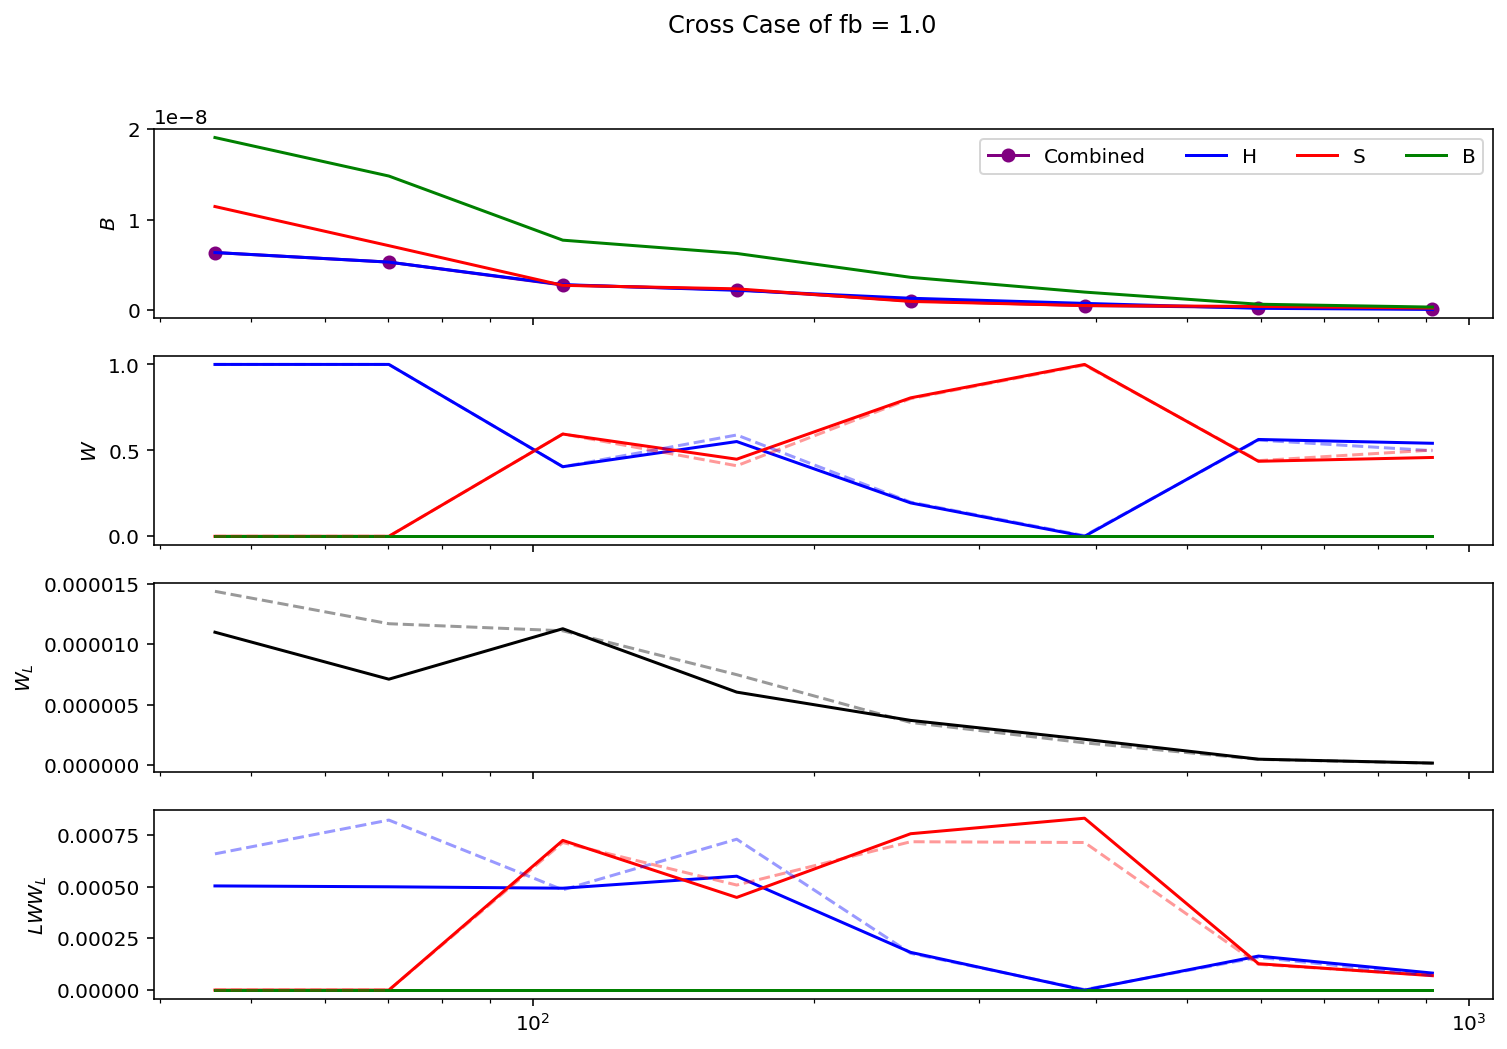

In [509]:
all_maxes = ['h2000s3500b4500']
plot_fixed(fb, all_maxes)

h4000s4500b4500


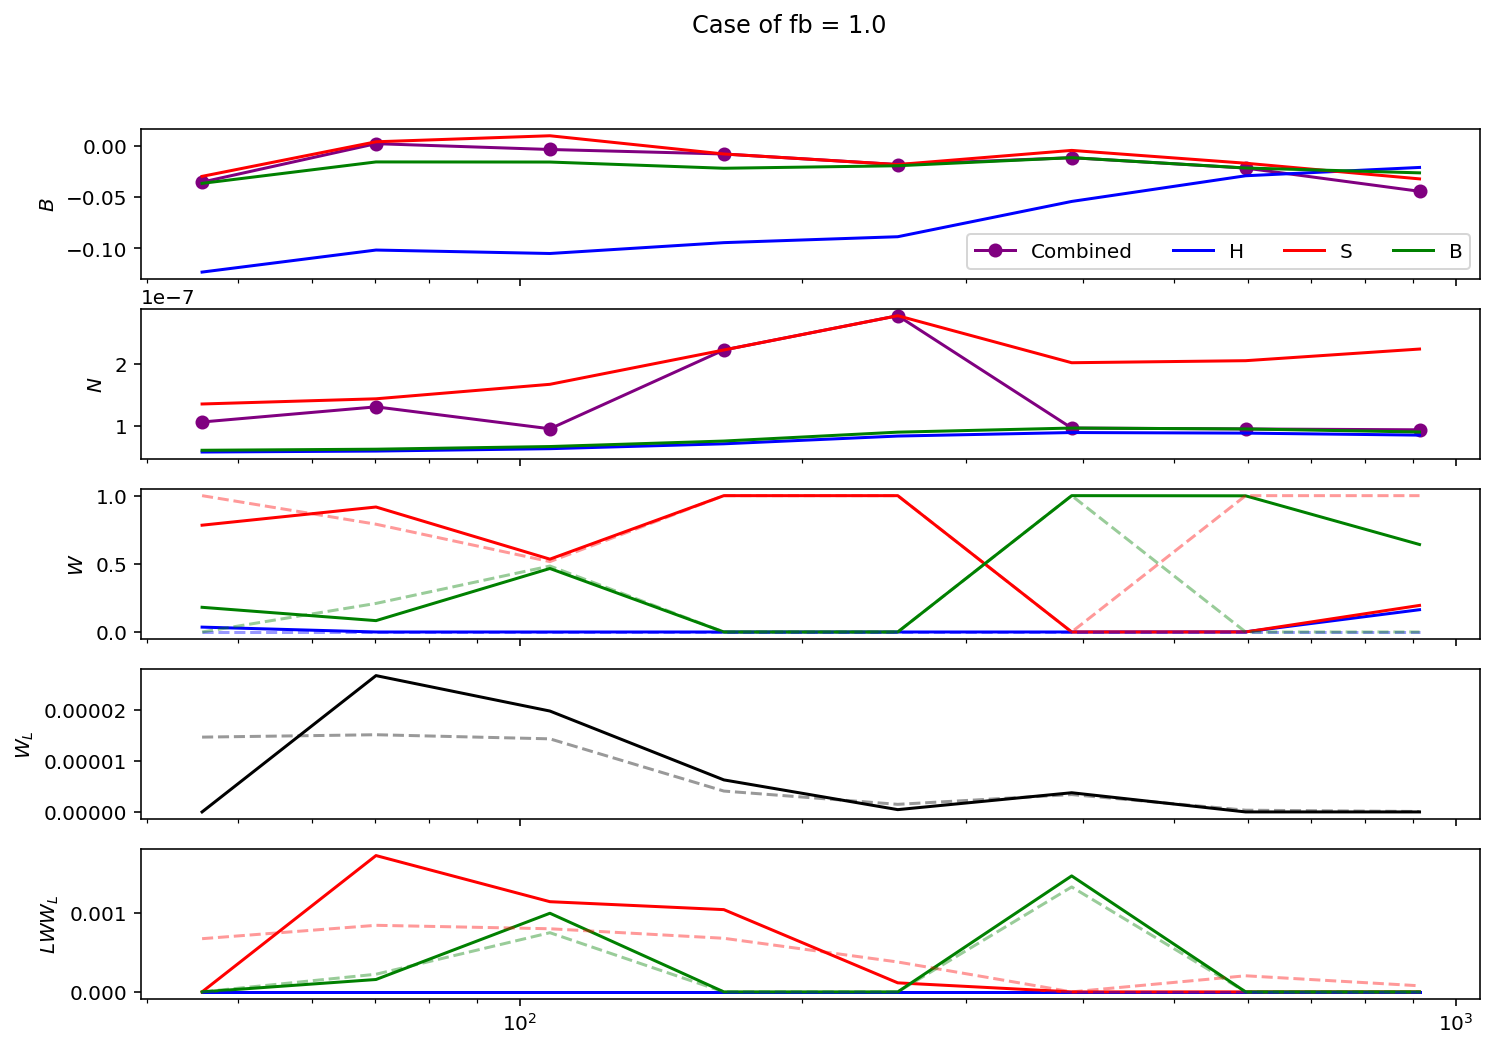

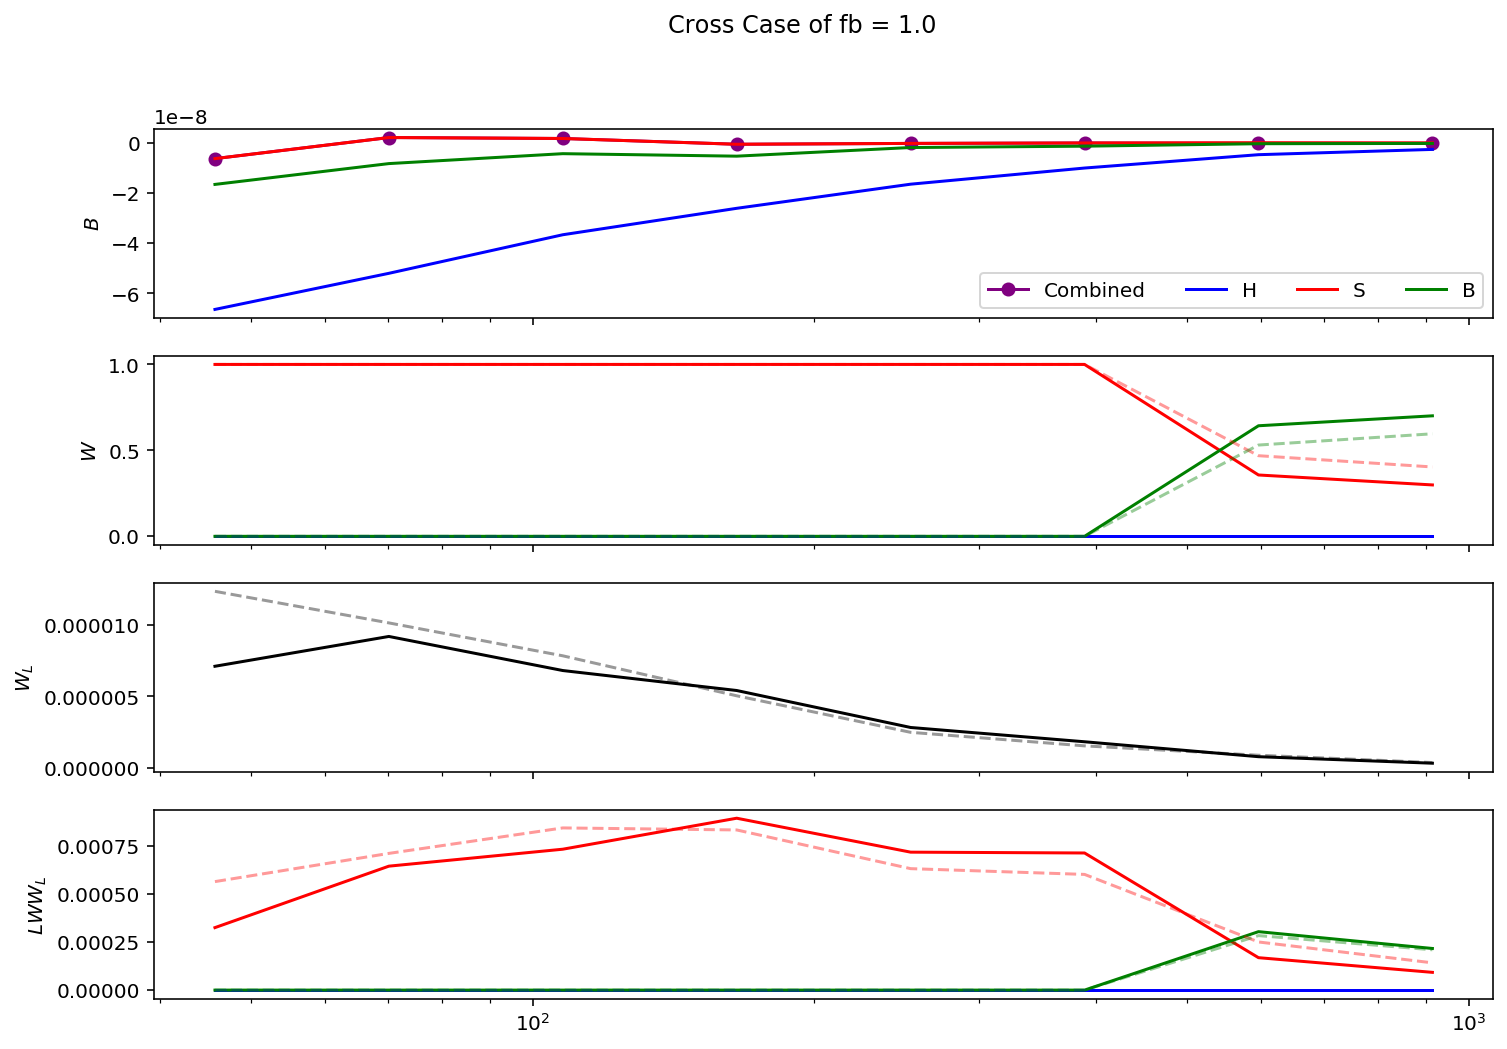

In [180]:
all_maxes = ['h4000s4500b4500']
plot_fixed(fb, all_maxes)

In [181]:
df_cross

Name  Total Cross  Total Mv Cross  Bias Cross  Noise Cross  \
0    h3500s3500b4500     0.000056        0.000055   -0.001292     0.007371   
1    h4500s4000b4000     0.000054        0.000053   -0.000455     0.007302   
2    h3500s4000b3000     0.000051        0.000051   -0.000327     0.007102   
3    h4000s4000b3500     0.000052        0.000051   -0.001338     0.007053   
4    h2500s2000b2000     0.000109        0.000110   -0.002919     0.010006   
..               ...          ...             ...         ...          ...   
123  h4000s4500b3000     0.000050        0.000050   -0.000595     0.007064   
124  h2500s4000b4500     0.000055        0.000056   -0.001176     0.007346   
125  h4500s3500b3000     0.000054        0.000055   -0.002003     0.007046   
126  h3500s4000b3500     0.000052        0.000051   -0.001338     0.007053   
127  h3000s3000b2500     0.000065        0.000065   -0.000838     0.008022   

     Detectable Cross  Bias Mv Cross  Noise Mv Cross  Detectable Mv Cross  \
0               False      -0.001604        0.007219                False   
1               False      -0.000821        0.007220                False   
2               False      -0.000282        0.007107                False   
3               False      -0.001233        0.007062                False   
4               False      -0.002957        0.010042                False   
..                ...            ...             ...                  ...   
123             False      -0.000650        0.007058                False   
124             False      -0.002162        0.007147                False   
125             False      -0.002630        0.006953                False   
126             False      -0.001233        0.007062                False   
127             False      -0.000851        0.008020                False   

     Bias relative to H  Noise relative to H  Bias Mv relative to H  \
0              0.014513             1.224704               0.018023   
1              0.003050             1.242214               0.005506   
2              0.003678             1.180126               0.003172   
3              0.010400             1.196337               0.009589   
4              0.163137             1.294966               0.165257   
..                  ...                  ...                    ...   
123            0.004625             1.198224               0.005050   
124            0.065751             0.950620               0.120837   
125            0.013437             1.198584               0.017647   
126            0.015033             1.171979               0.013860   
127            0.018065             1.234558               0.018348   

     Noise Mv relative to H    Bias H   Noise H    Bias S   Noise S   Bias BH  \
0                  1.199506 -0.088992  0.006018  0.006347  0.008318 -0.014414   
1                  1.228244 -0.149043  0.005879  0.005124  0.008125 -0.010787   
2                  1.180831 -0.088992  0.006018  0.005124  0.008125 -0.002715   
3                  1.197788 -0.128633  0.005896  0.005124  0.008125 -0.007327   
4                  1.299593 -0.017893  0.007727  0.001229  0.015680 -0.000642   
..                      ...       ...       ...       ...       ...       ...   
123                1.197184 -0.128633  0.005896  0.001188  0.008097 -0.002715   
124                0.924877 -0.017893  0.007727  0.005124  0.008125 -0.014414   
125                1.182715 -0.149043  0.005879  0.006347  0.008318 -0.002715   
126                1.173400 -0.088992  0.006018  0.005124  0.008125 -0.007327   
127                1.234233 -0.046383  0.006498  0.008285  0.009061 -0.001695   

     Noise BH  
0    0.006020  
1    0.006119  
2    0.006937  
3    0.006334  
4    0.011008  
..        ...  
123  0.006937  
124  0.006020  
125  0.006937  
126  0.006334  
127  0.008241  

[128 rows x 19 columns]

In [182]:
df_cross.sort_values('Total Mv Cross')

Name  Total Cross  Total Mv Cross  Bias Cross  Noise Cross  \
15   h3000s4500b3000     0.000050        0.000050   -0.000595     0.007064   
123  h4000s4500b3000     0.000050        0.000050   -0.000595     0.007064   
100  h2000s4500b3000     0.000050        0.000050   -0.000595     0.007064   
36   h4500s4500b3000     0.000050        0.000050   -0.000595     0.007064   
26   h2500s4500b3000     0.000050        0.000050   -0.000595     0.007064   
..               ...          ...             ...         ...          ...   
44   h2500s2000b2500     0.000071        0.000071   -0.001662     0.008243   
97   h2500s2500b2000     0.000093        0.000093   -0.000722     0.009609   
67   h2000s2500b2000     0.000100        0.000100    0.000596     0.009980   
4    h2500s2000b2000     0.000109        0.000110   -0.002919     0.010006   
73   h2000s2000b2000     0.000119        0.000119   -0.001830     0.010758   

     Detectable Cross  Bias Mv Cross  Noise Mv Cross  Detectable Mv Cross  \
15              False      -0.000650        0.007058                False   
123             False      -0.000650        0.007058                False   
100             False      -0.000650        0.007058                False   
36              False      -0.000650        0.007058                False   
26              False      -0.000650        0.007058                False   
..                ...            ...             ...                  ...   
44              False      -0.001683        0.008242                False   
97              False      -0.000591        0.009650                False   
67              False       0.000625        0.009983                False   
4               False      -0.002957        0.010042                False   
73              False      -0.001835        0.010759                False   

     Bias relative to H  Noise relative to H  Bias Mv relative to H  \
15             0.012828             1.087232               0.014005   
123            0.004625             1.198224               0.005050   
100            0.083515             0.685391               0.091179   
36             0.003992             1.201730               0.004358   
26             0.033253             0.914250               0.036304   
..                  ...                  ...                    ...   
44             0.092908             1.066825               0.094032   
97             0.040360             1.243591               0.033015   
67            -0.083662             0.968242              -0.087718   
4              0.163137             1.294966               0.165257   
73             0.256935             1.043735               0.257634   

     Noise Mv relative to H    Bias H   Noise H    Bias S   Noise S   Bias BH  \
15                 1.086289 -0.046383  0.006498  0.001188  0.008097 -0.002715   
123                1.197184 -0.128633  0.005896  0.001188  0.008097 -0.002715   
100                0.684796 -0.007124  0.010307  0.001188  0.008097 -0.002715   
36                 1.200687 -0.149043  0.005879  0.001188  0.008097 -0.002715   
26                 0.913457 -0.017893  0.007727  0.001188  0.008097 -0.002715   
..                      ...       ...       ...       ...       ...       ...   
44                 1.066606 -0.017893  0.007727  0.001229  0.015680 -0.001695   
97                 1.248855 -0.017893  0.007727  0.003408  0.011367 -0.000642   
67                 0.968547 -0.007124  0.010307  0.003408  0.011367 -0.000642   
4                  1.299593 -0.017893  0.007727  0.001229  0.015680 -0.000642   
73                 1.043810 -0.007124  0.010307  0.001229  0.015680 -0.000642   

     Noise BH  
15   0.006937  
123  0.006937  
100  0.006937  
36   0.006937  
26   0.006937  
..        ...  
44   0.008241  
97   0.011008  
67   0.011008  
4    0.011008  
73   0.011008  

[128 rows x 19 columns]

h2500s4500b3000


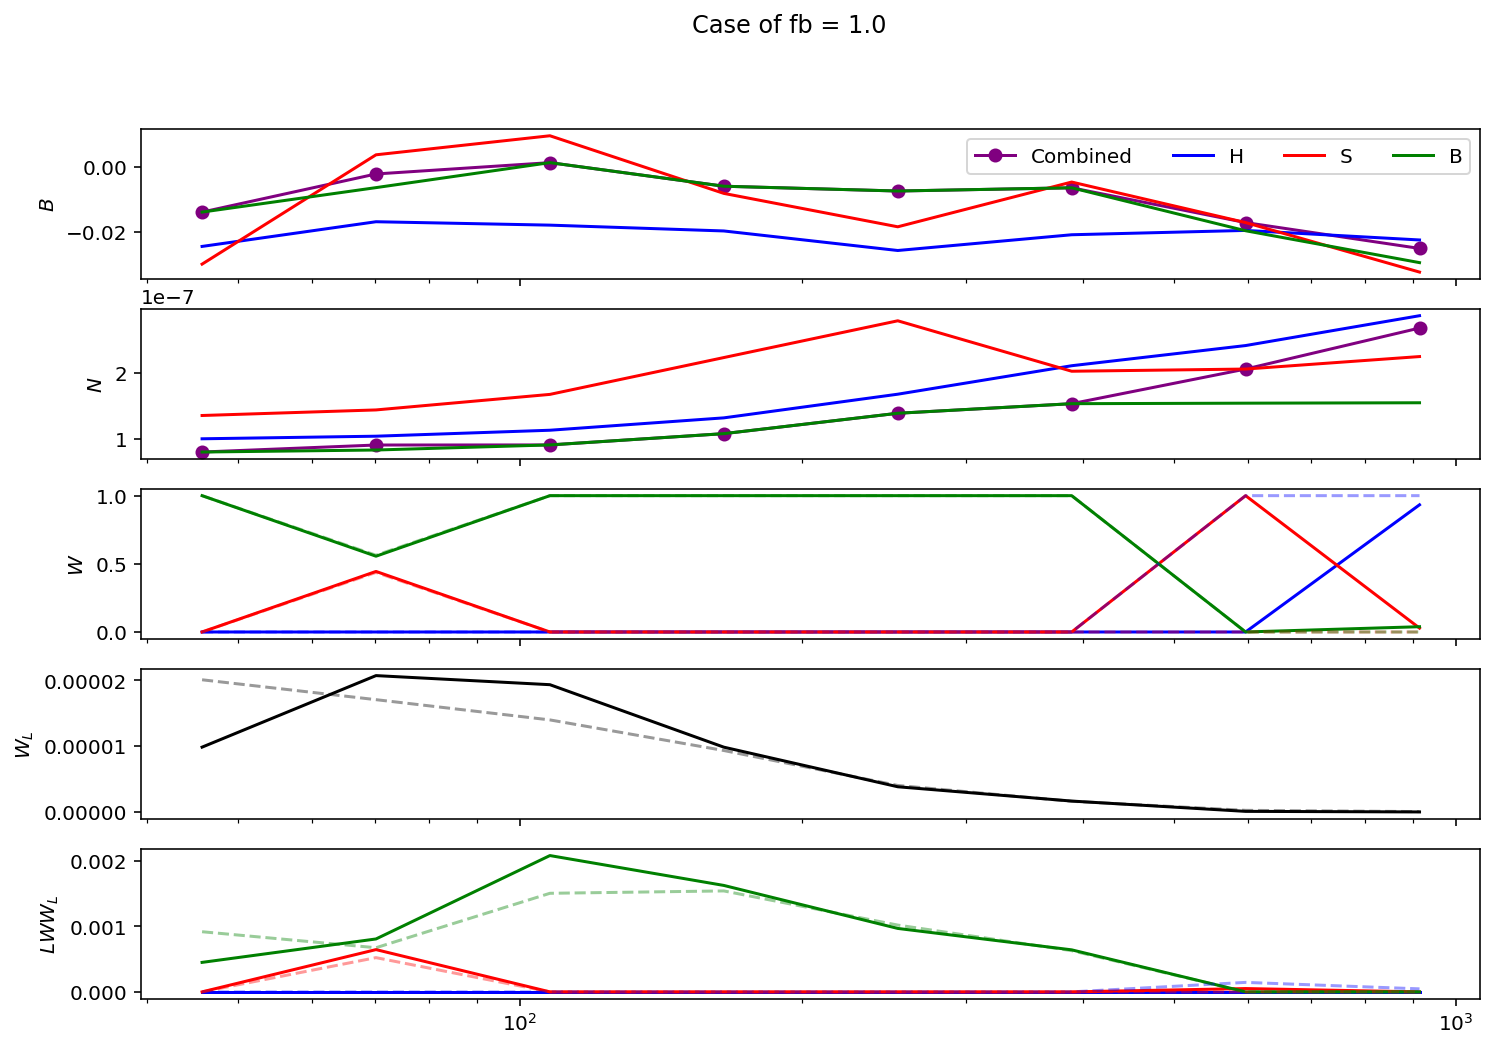

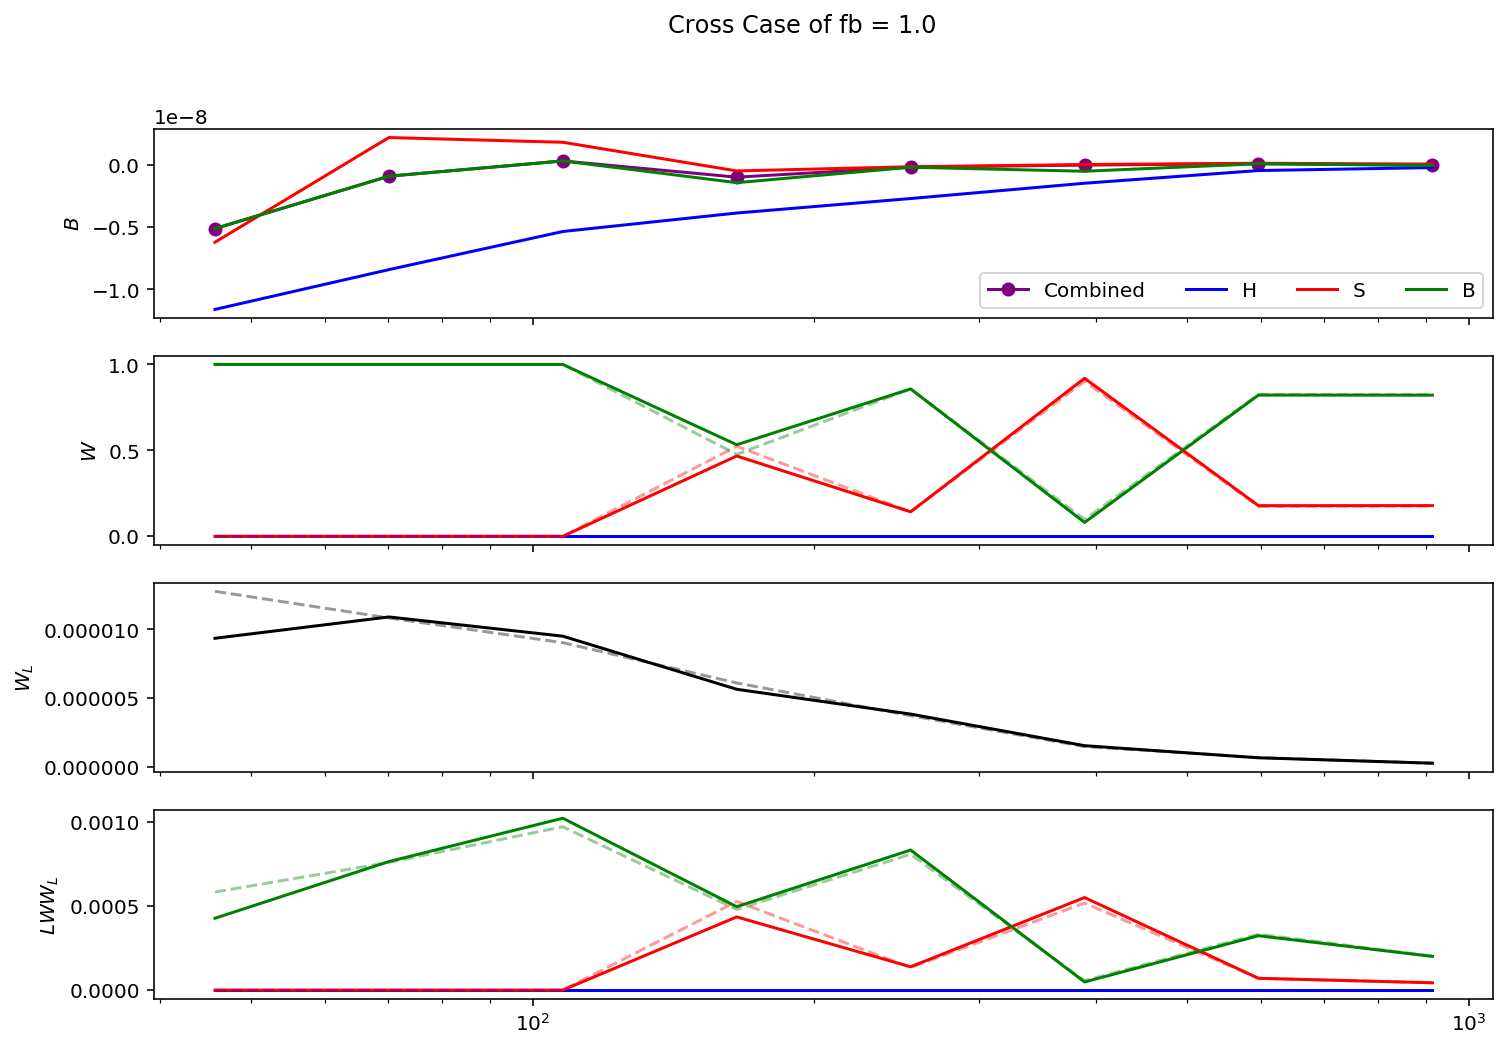

In [183]:
directory = min(crosses, key = crosses.get)
all_maxes = [directory]
plot_fixed(fb, all_maxes)

**Simple check**

In [163]:
lmax = 3500

In [164]:
fbs = [0., 1., 5., 10., 100.]
noisebiasconstr = False


In [173]:
totals_auto = []
totals_cross = []

noises_auto = []
noises_cross = []

biases_auto = []
biases_cross = []

h3500s3500b3500
0.0
Total auto 4.0284533636240335e-05
Total cross 3.622042315447236e-05
Total auto 4.0284533636237625e-05
Total cross 3.6220423154471514e-05


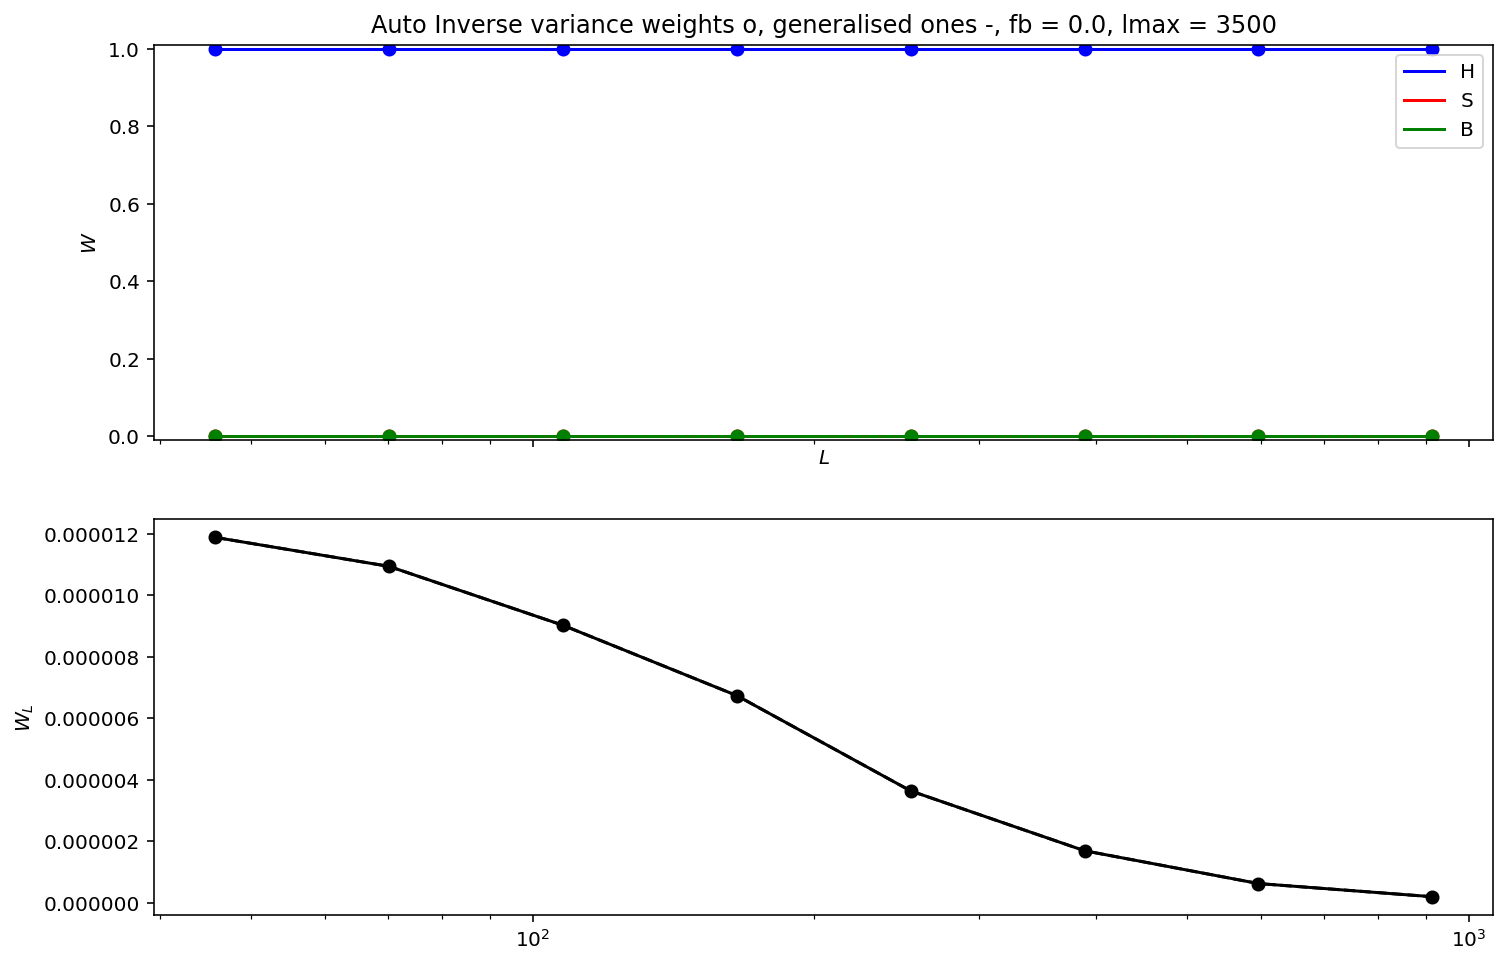

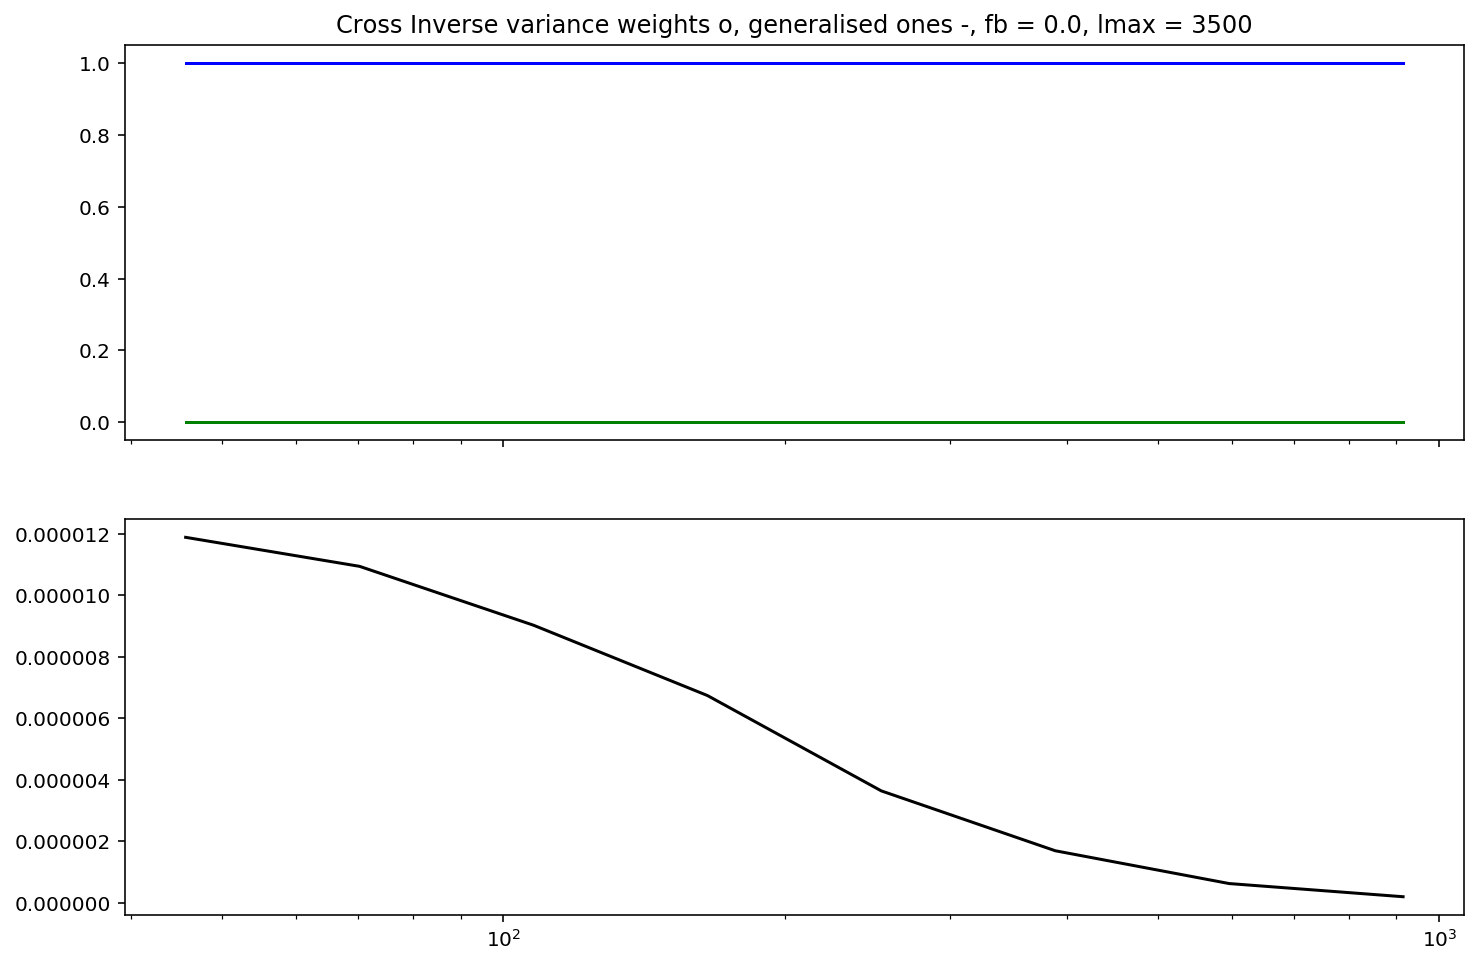

h3500s3500b3500
1.0
Total auto 0.016751710788213324
Total cross 0.013219531761798556
Total auto 0.038638635972422036
Total cross 0.009264855911656749


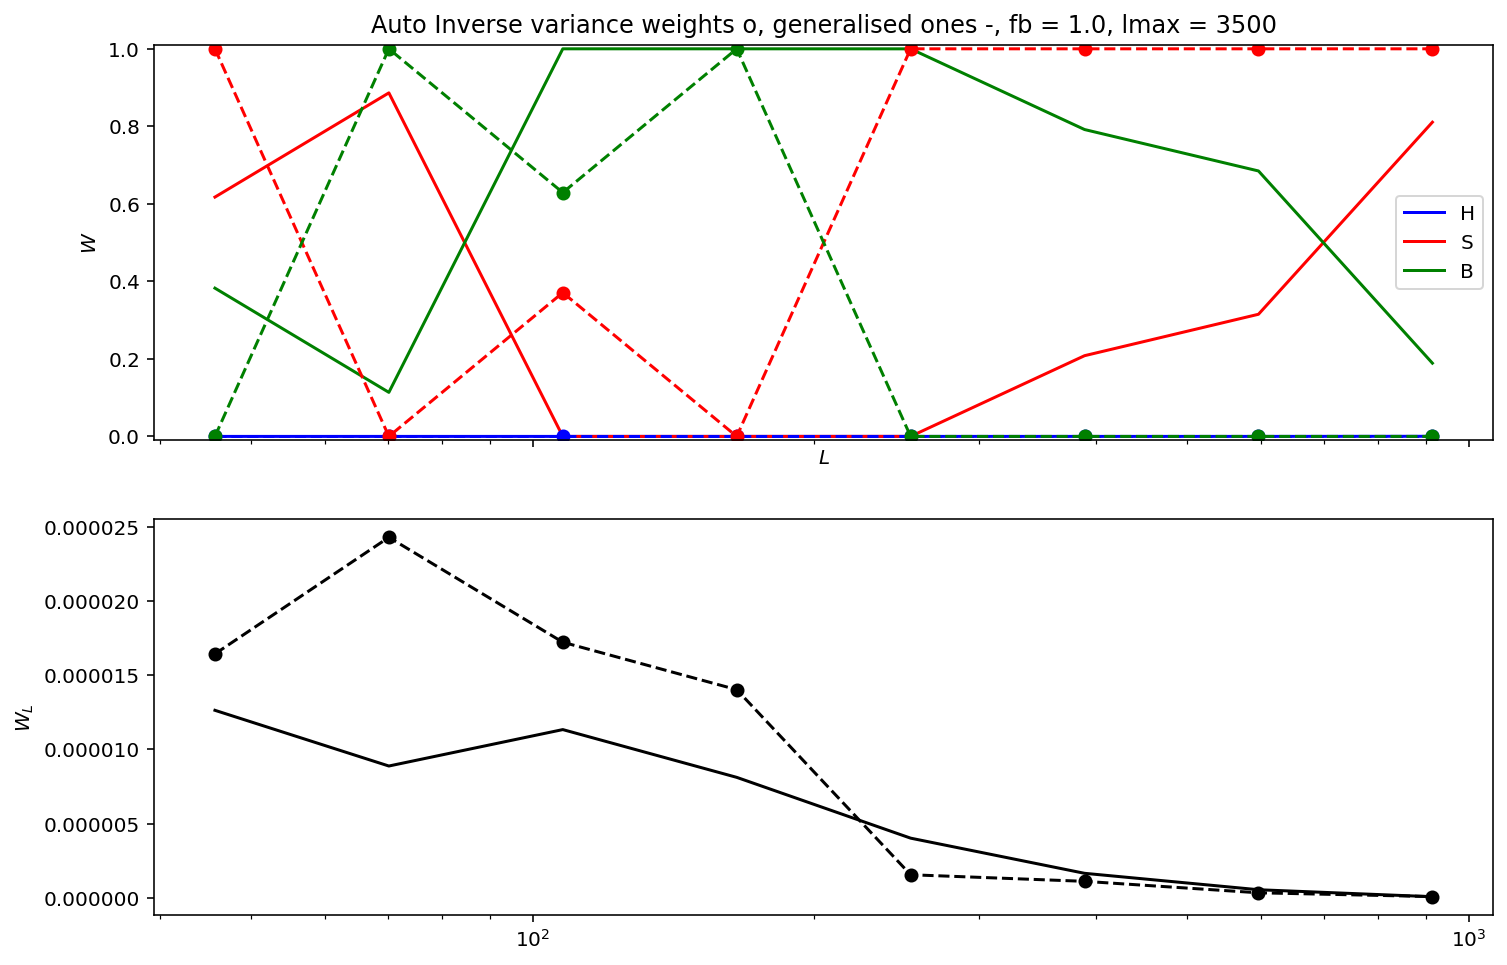

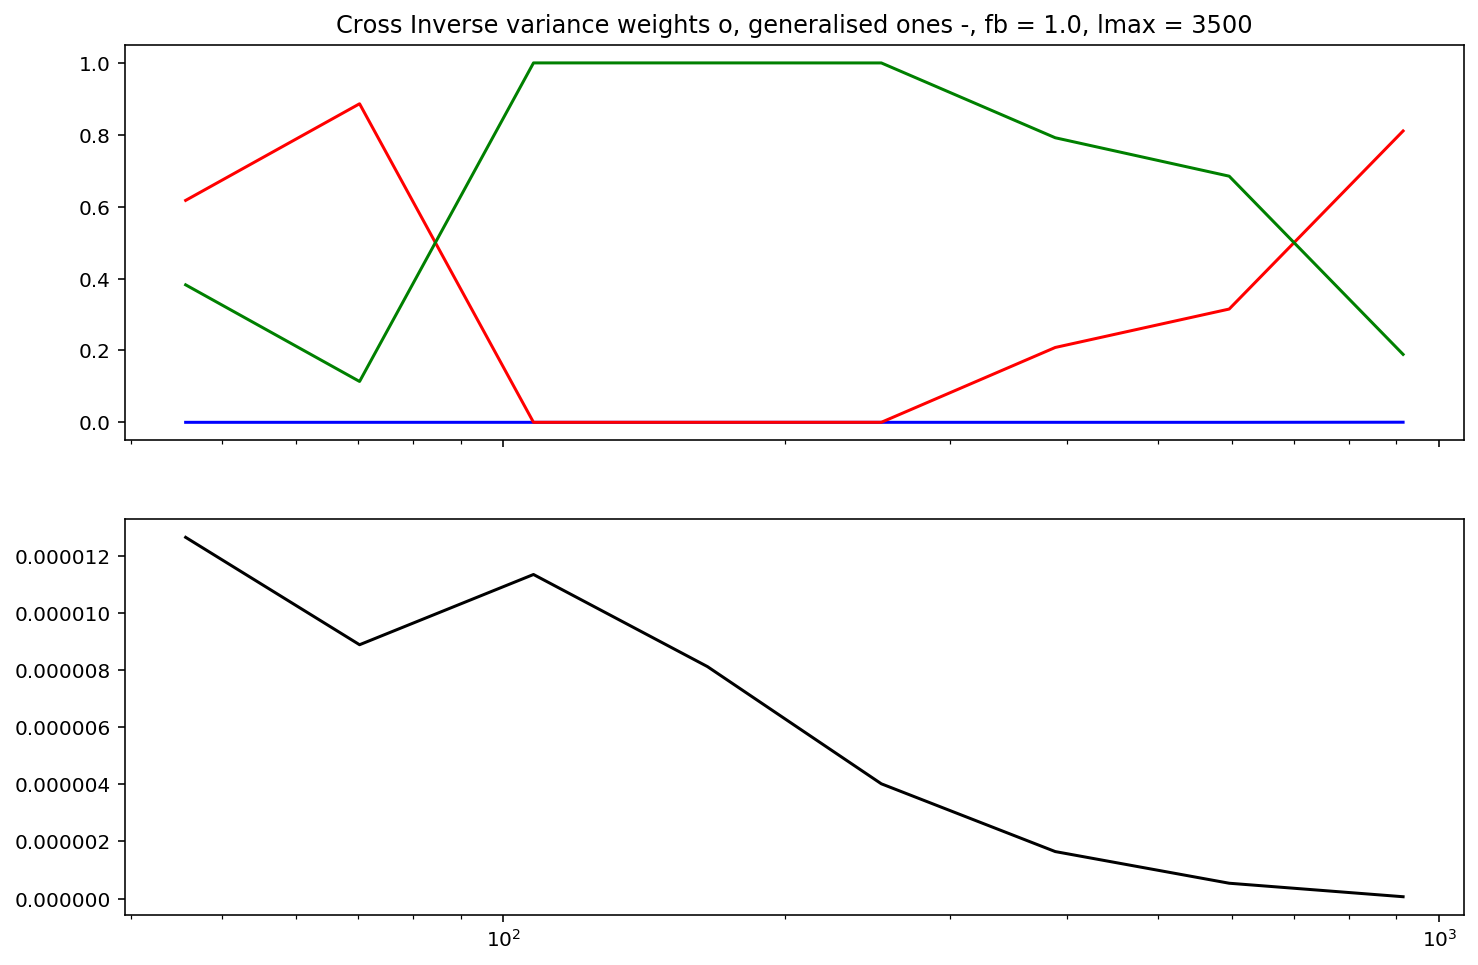

h3500s3500b3500
5.0
Total auto -0.014937550854250187
Total cross 0.002065417195948446
Total auto 0.18322039102824142
Total cross 0.04611235501653909


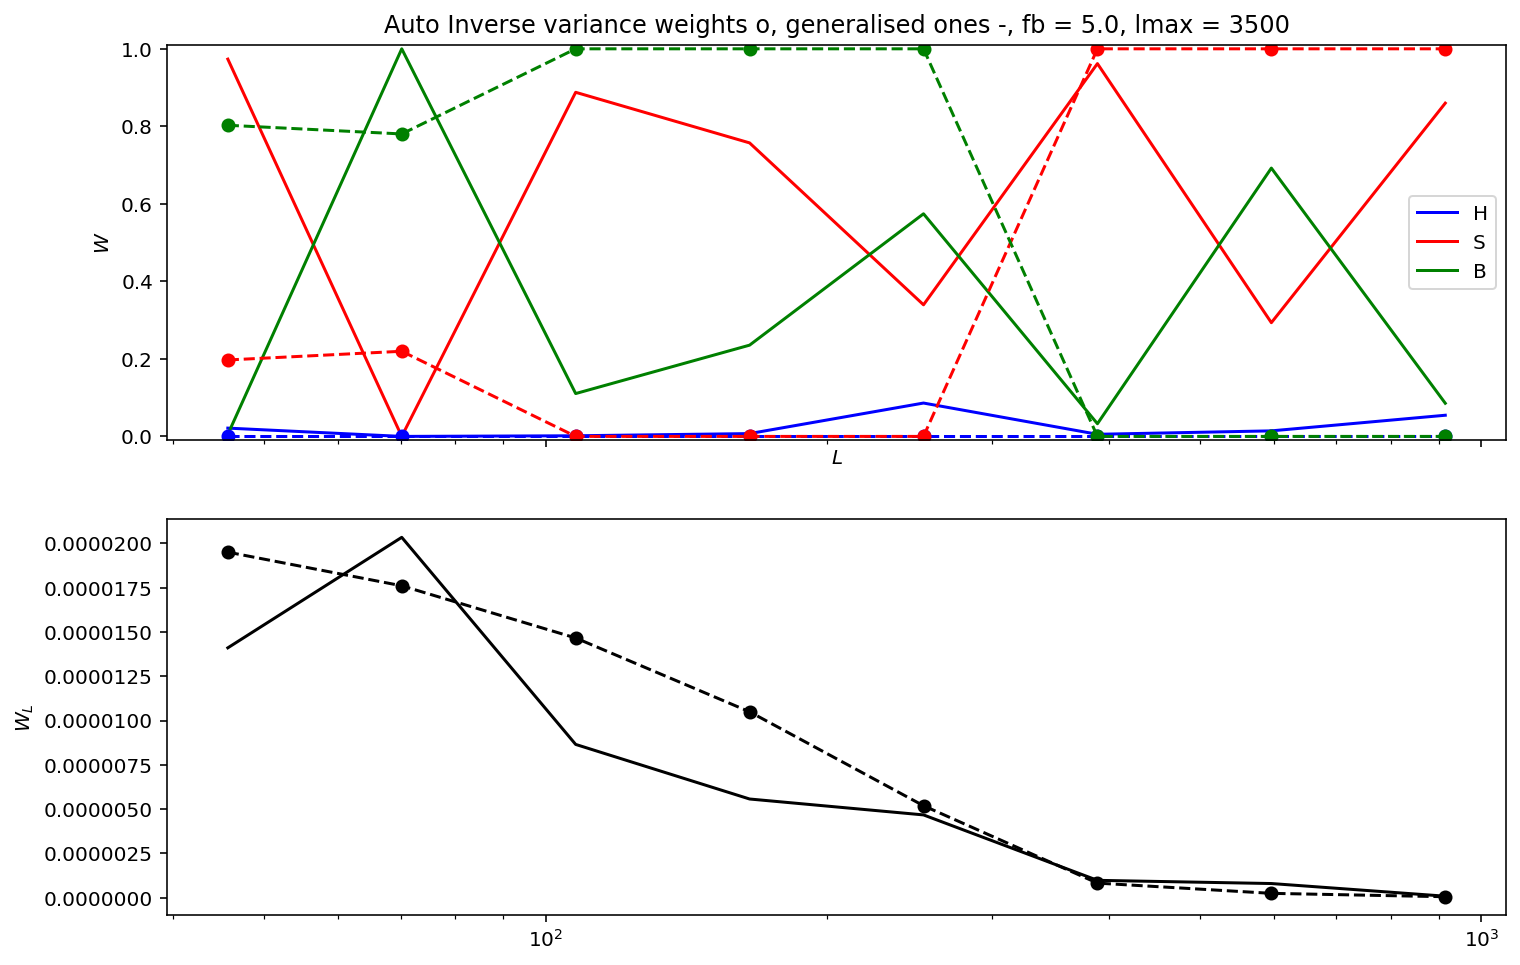

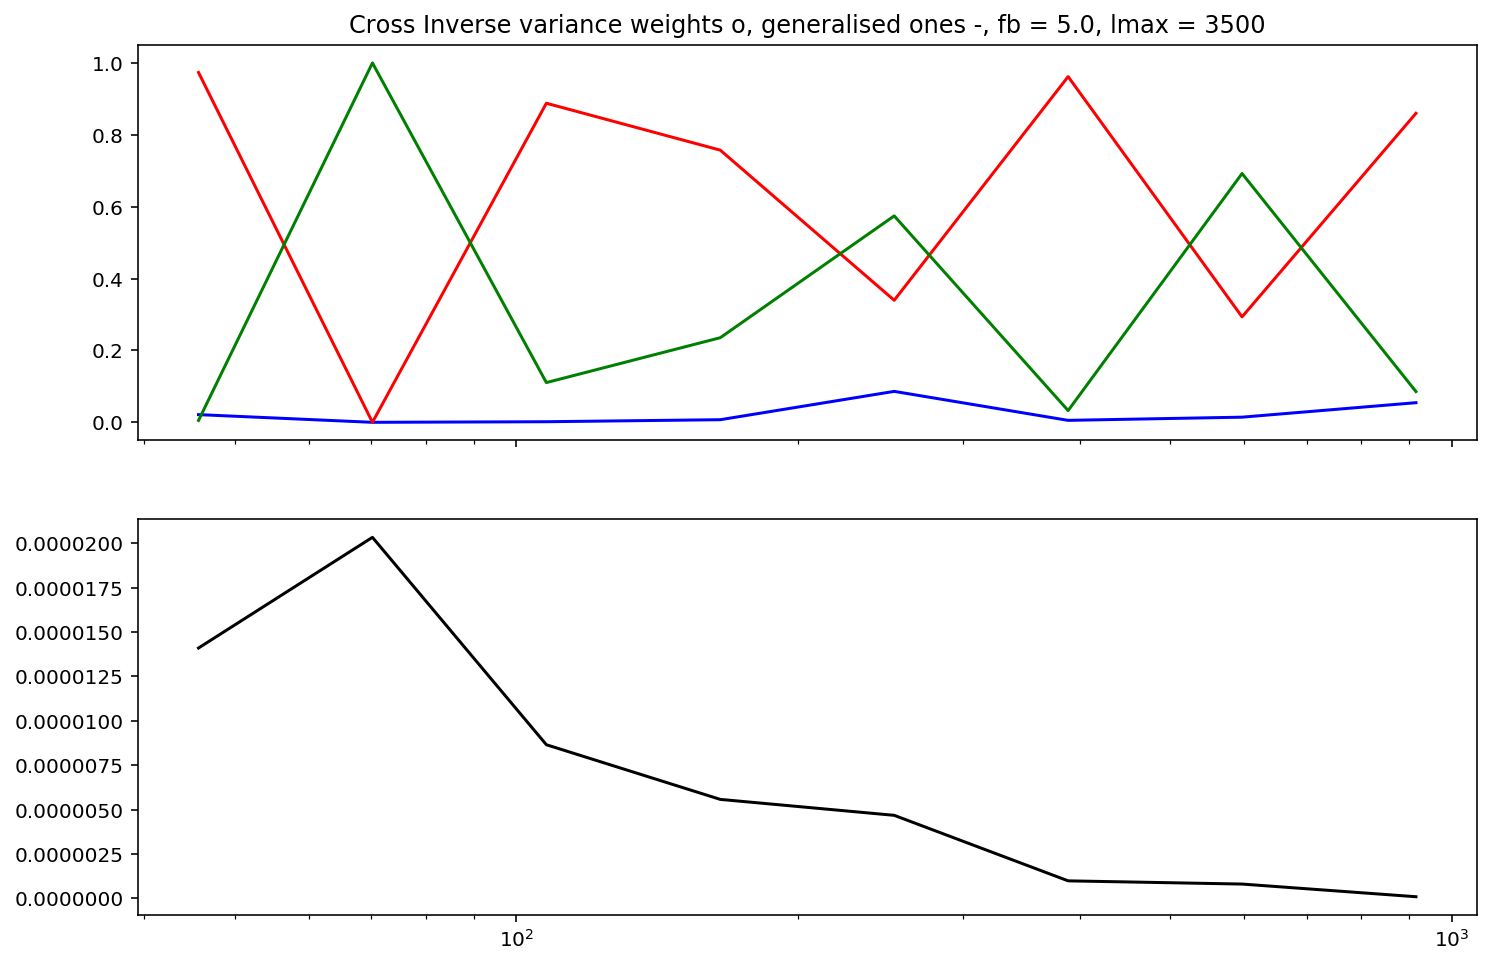

h3500s3500b3500
10.0
Total auto -0.030780507726373526
Total cross -0.0006900720080994776
Total auto 0.3858861846283224
Total cross 0.09207114580221479


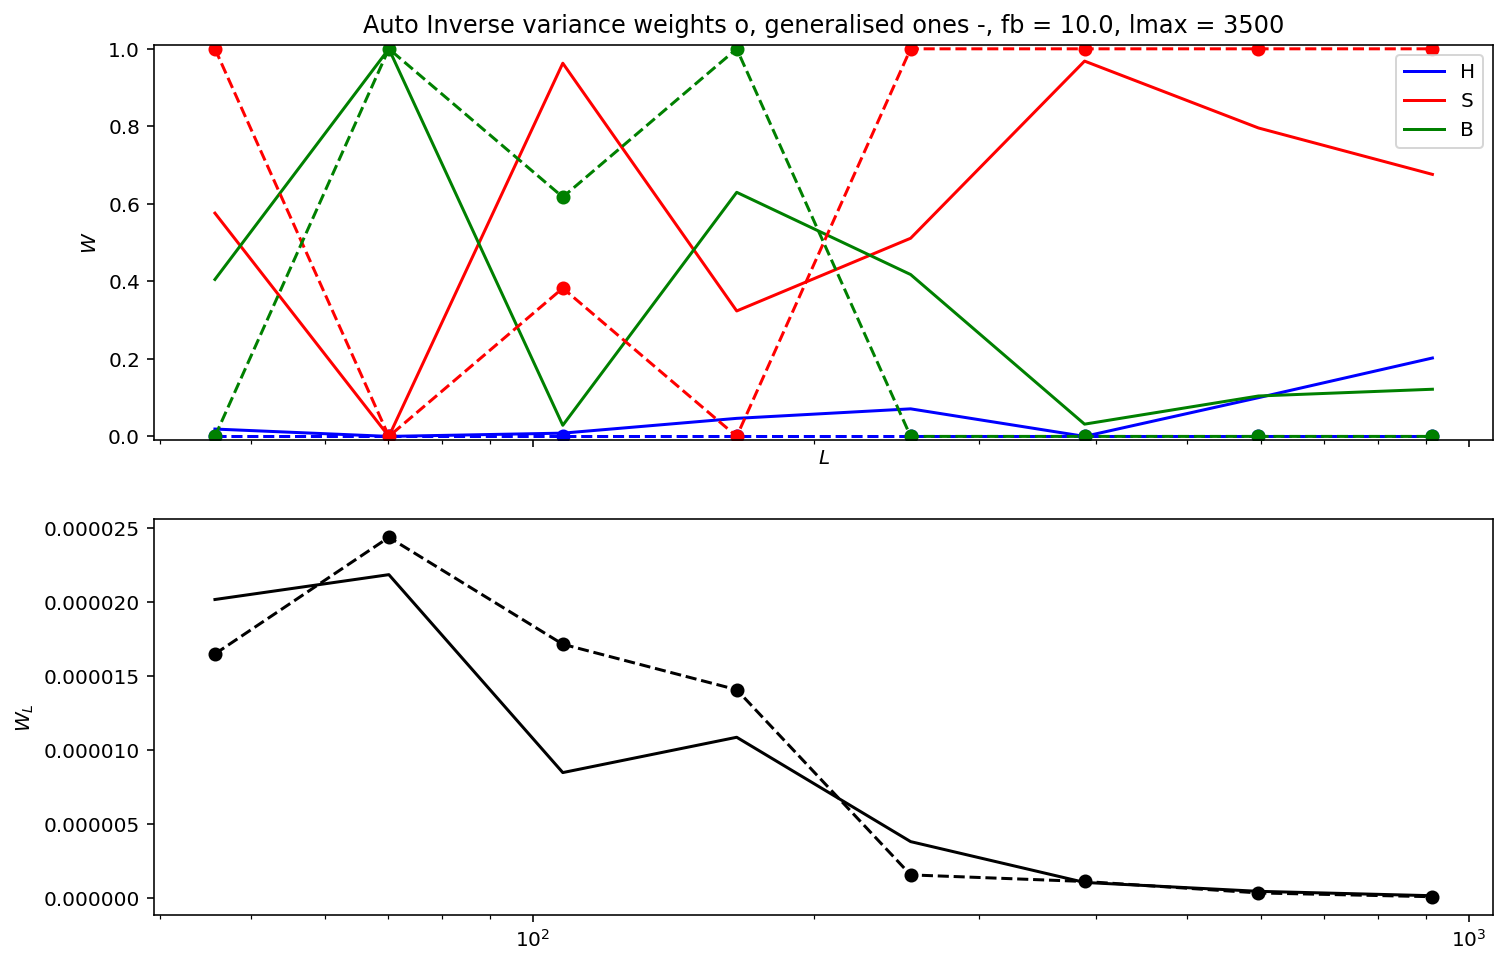

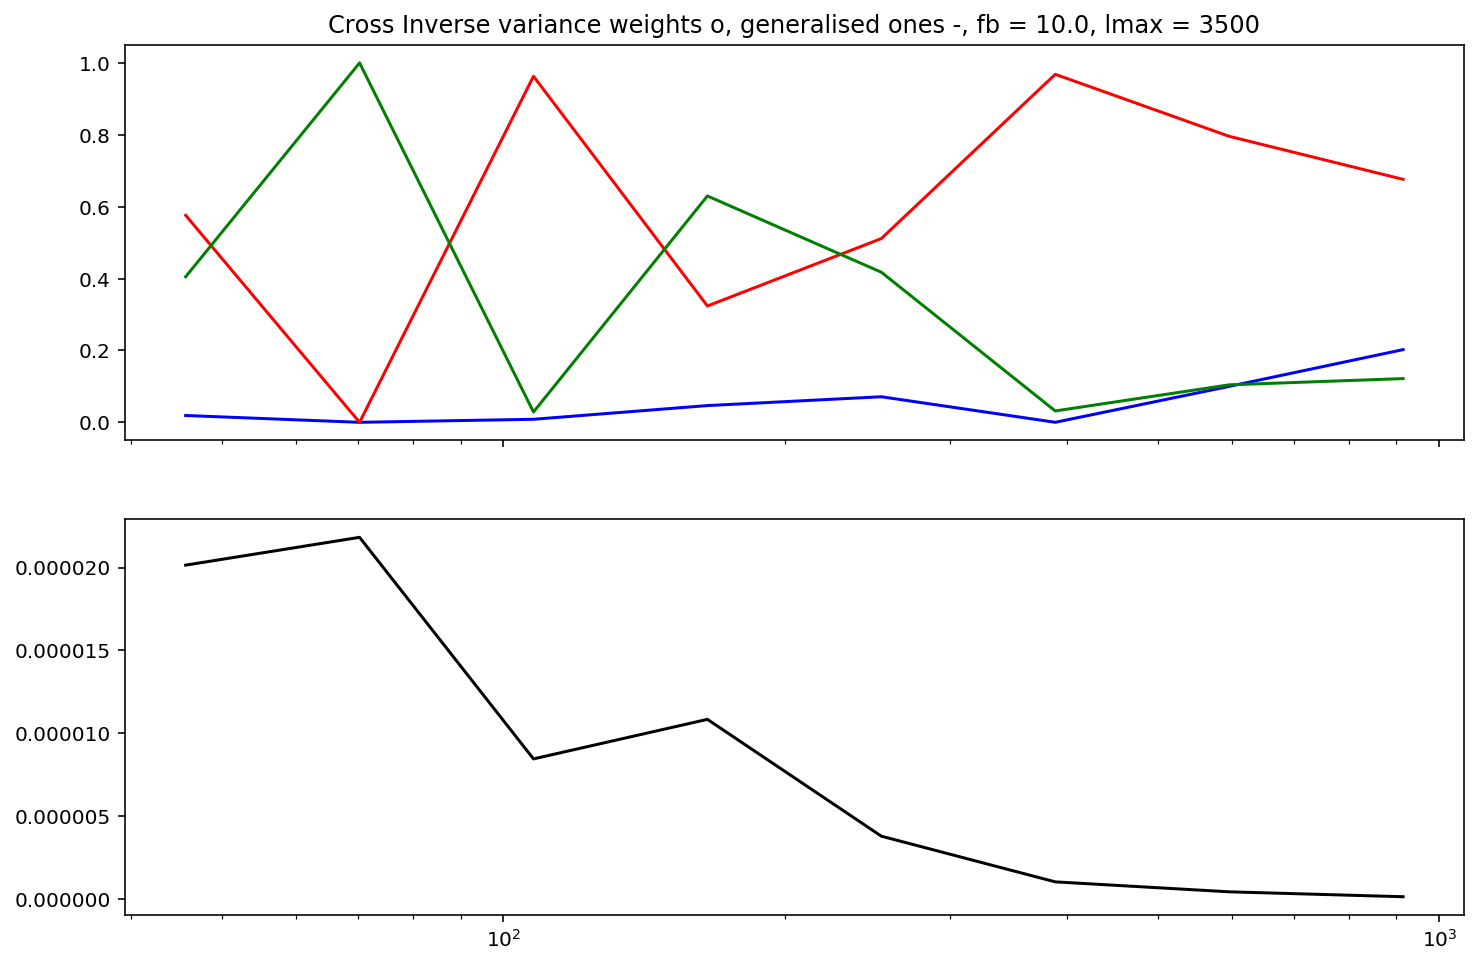

h3500s3500b3500
100.0
Total auto 2.2380571975896824
Total cross 1.8872032915305776
Total auto 3.6630488313781764
Total cross 0.9211900845805014


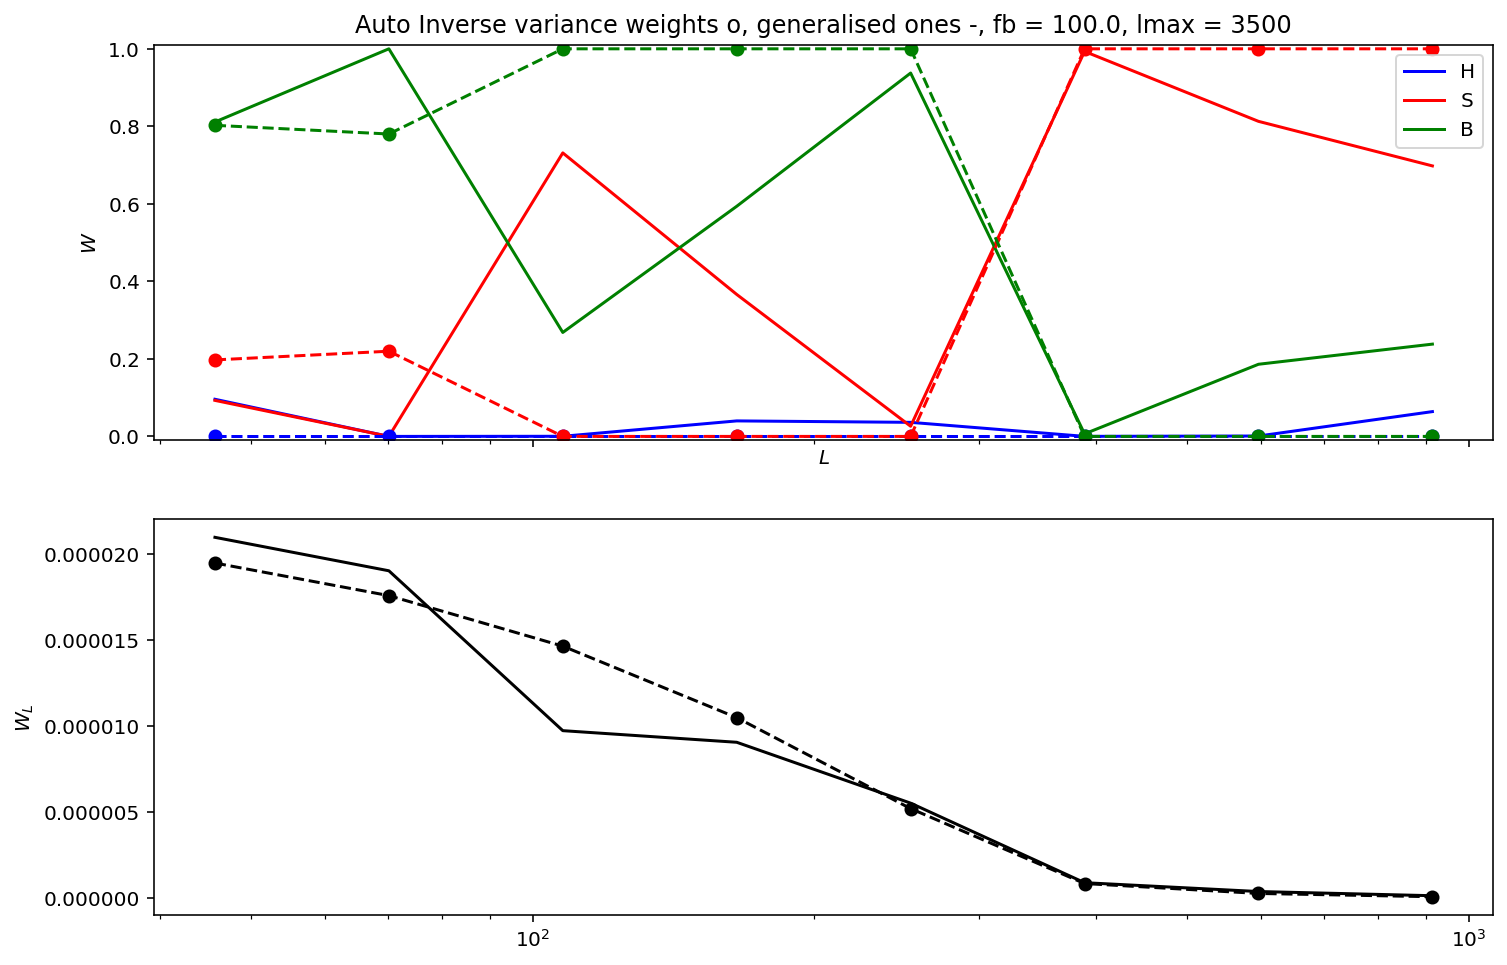

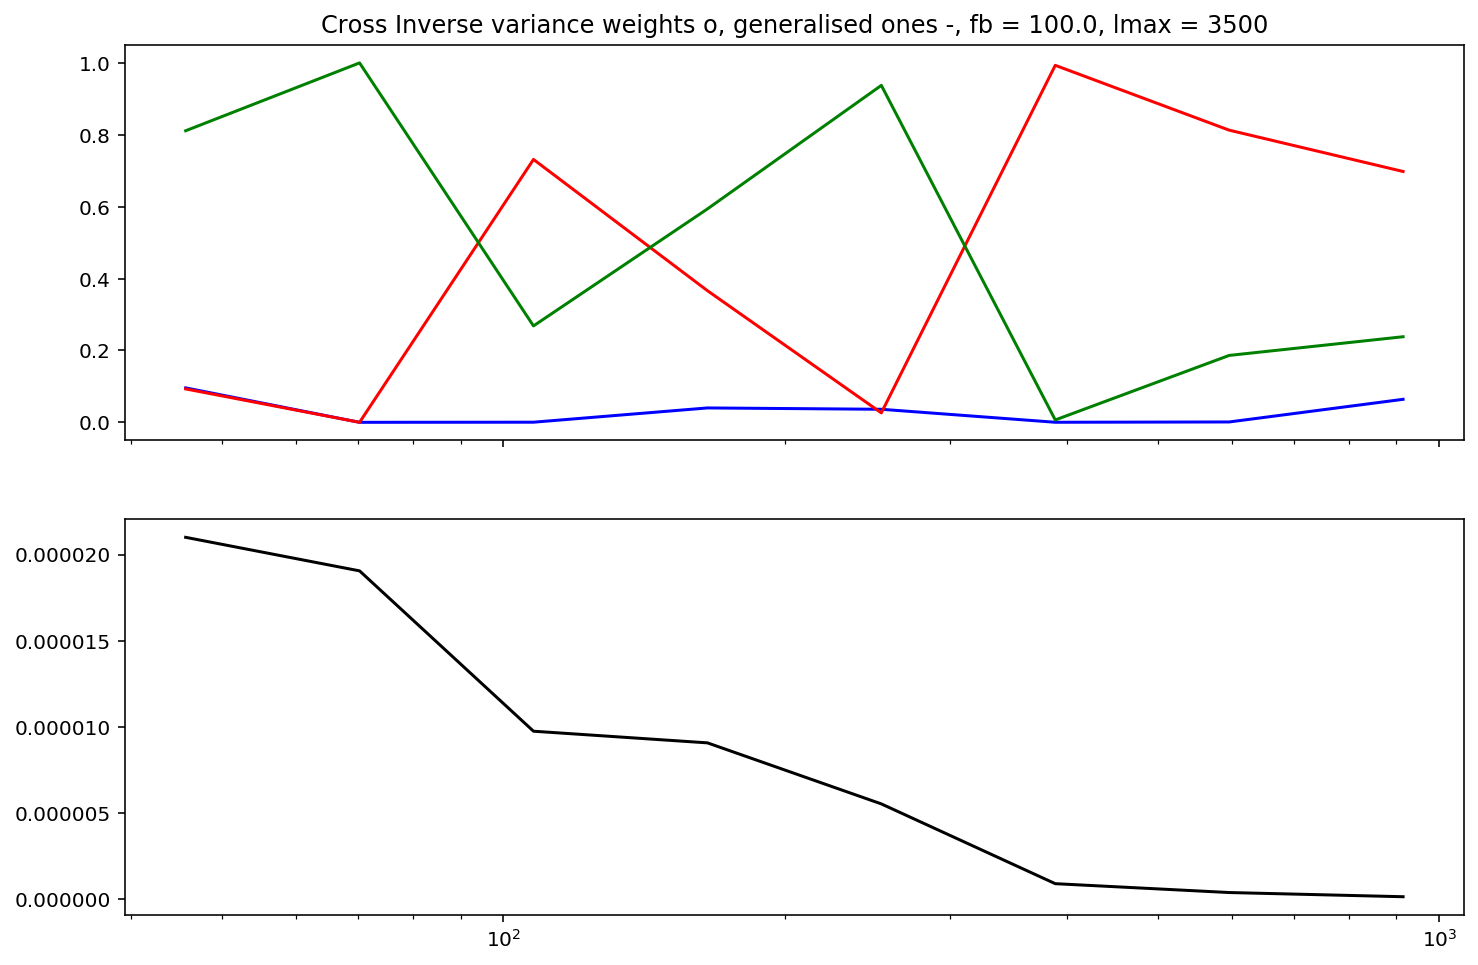

In [174]:
for fb in fbs:
    fig, ax = plt.subplots(nrows = 2, sharex = True)
    ax[0].set_title(f'Auto Inverse variance weights o, generalised ones -, fb = {fb}, lmax = {lmax}')
    
    fig2, ax2 = plt.subplots(nrows = 2, sharex = True)

    ax2[0].set_title(f'Cross Inverse variance weights o, generalised ones -, fb = {fb}, lmax = {lmax}')
    
    for fgnamefile in [fgnamefiles[0]]:
        lmax_directory = f'h{lmax}s{lmax}b{lmax}'
        
        print(lmax_directory)

        invvariance = False


        print(fb)
        
        ells, w1, w2, w3, wl, w1c, w2c, w3c, wlc =  w_get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        auto, cross = get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        auton, crossn = get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        autob, crossb = get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        totals_auto += [auto]
        totals_cross += [cross]
        
        noises_auto += [auton]
        noises_cross += [crossn]
        
        biases_auto += [autob]
        biases_cross += [crossb]
        
        
        

        
        ax[0].plot(ells, w1, color = 'blue', label = 'H')
        ax[0].plot(ells, w2, color = 'red', label = 'S')
        ax[0].plot(ells, w3, color = 'green', label = 'B')

        ax[1].plot(ells, wl, color = 'black')
        
        ax2[0].plot(ells, w1, color = 'blue', label = 'H')
        ax2[0].plot(ells, w2, color = 'red', label = 'S')
        ax2[0].plot(ells, w3, color = 'green', label = 'B')

        ax2[1].plot(ells, wl, color = 'black')

        invvariance = True

        ells, w1, w2, w3, wl, w1c, w2c, w3c, wlc =  w_get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)

        ax[0].plot(ells, w1, color = 'blue', ls = '--', marker = 'o')
        ax[0].plot(ells, w2, color = 'red', ls = '--', marker = 'o')
        ax[0].plot(ells, w3, color = 'green', ls = '--', marker = 'o')

        ax[1].plot(ells, wl, color = 'black', ls = '--', marker = 'o')




    ax[0].set_ylabel('$W$')
    ax[1].set_ylabel('$W_L$')
    ax[0].set_xlabel('$L$')
    ax[0].set_yscale('linear')
    ax[0].set_ylim(-0.01, 1.01)
    ax[-1].set_xscale('log')
    
    ax2[-1].set_xscale('log')

    ax[0].legend()
    plt.show()

Text(0, 0.5, 'Total')

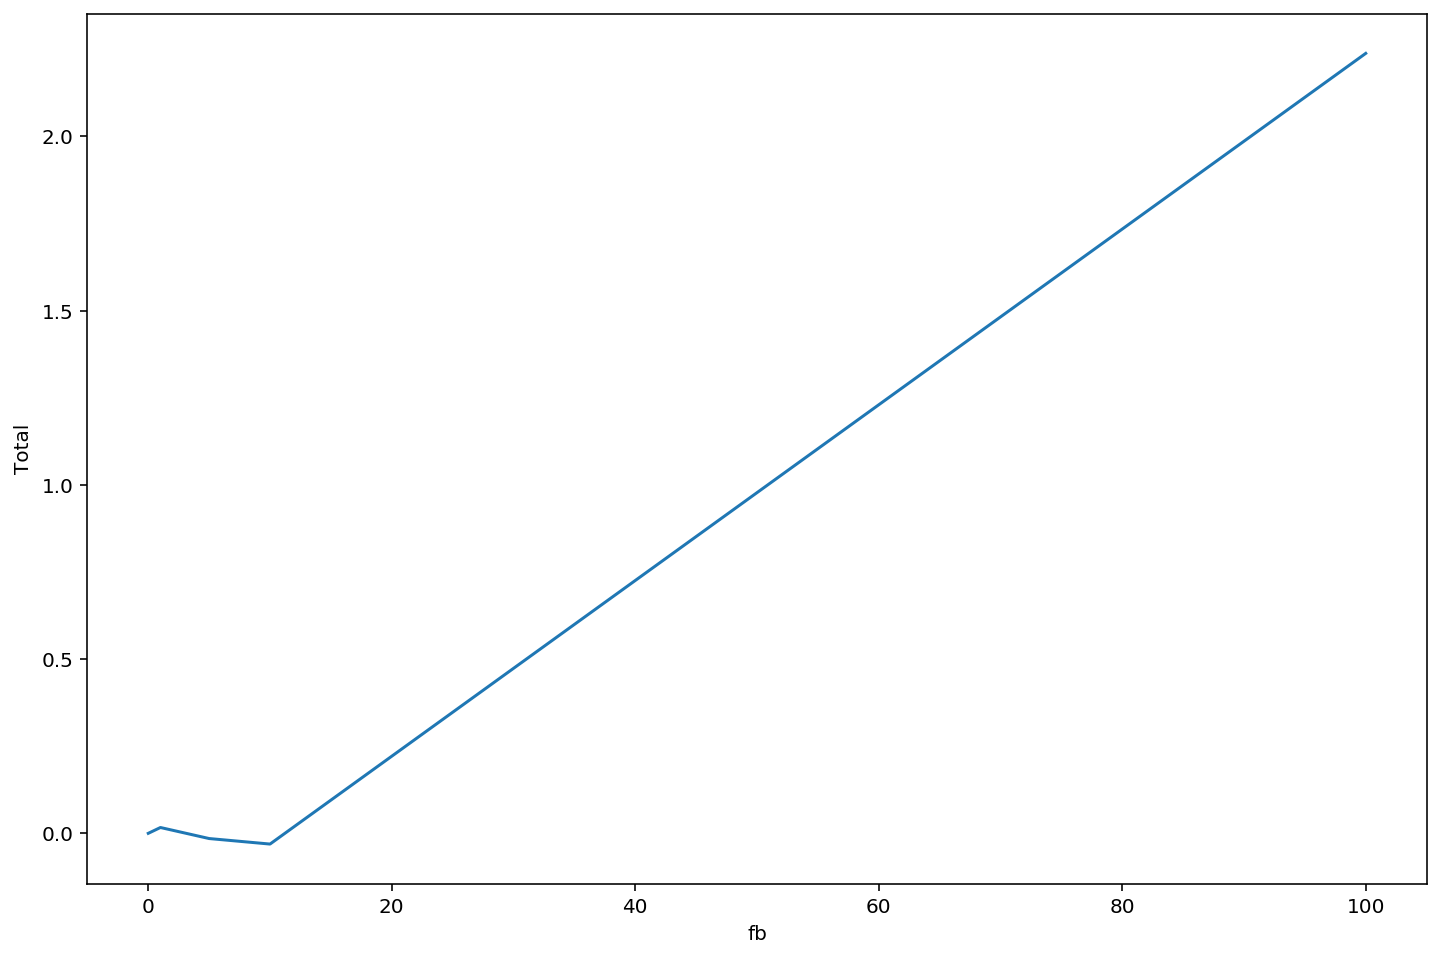

In [170]:
plt.plot(fbs, totals_auto)
plt.xlabel('fb')
plt.ylabel('Total')

Text(0, 0.5, 'Noise')

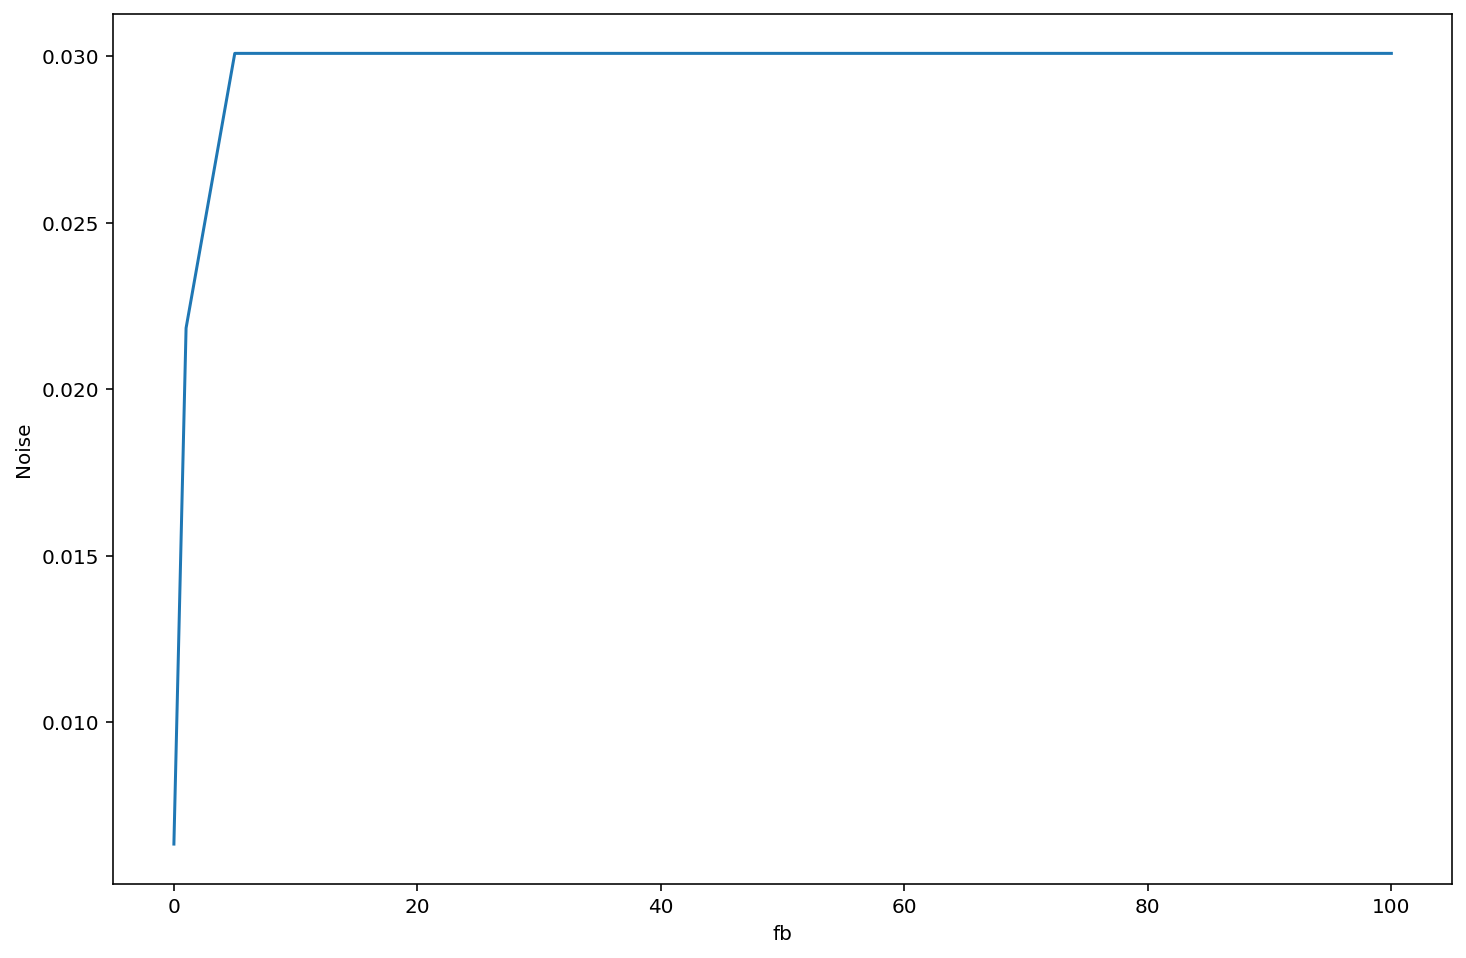

In [175]:
plt.plot(fbs, noises_auto)
plt.xlabel('fb')
plt.ylabel('Noise')

Text(0, 0.5, 'Bias')

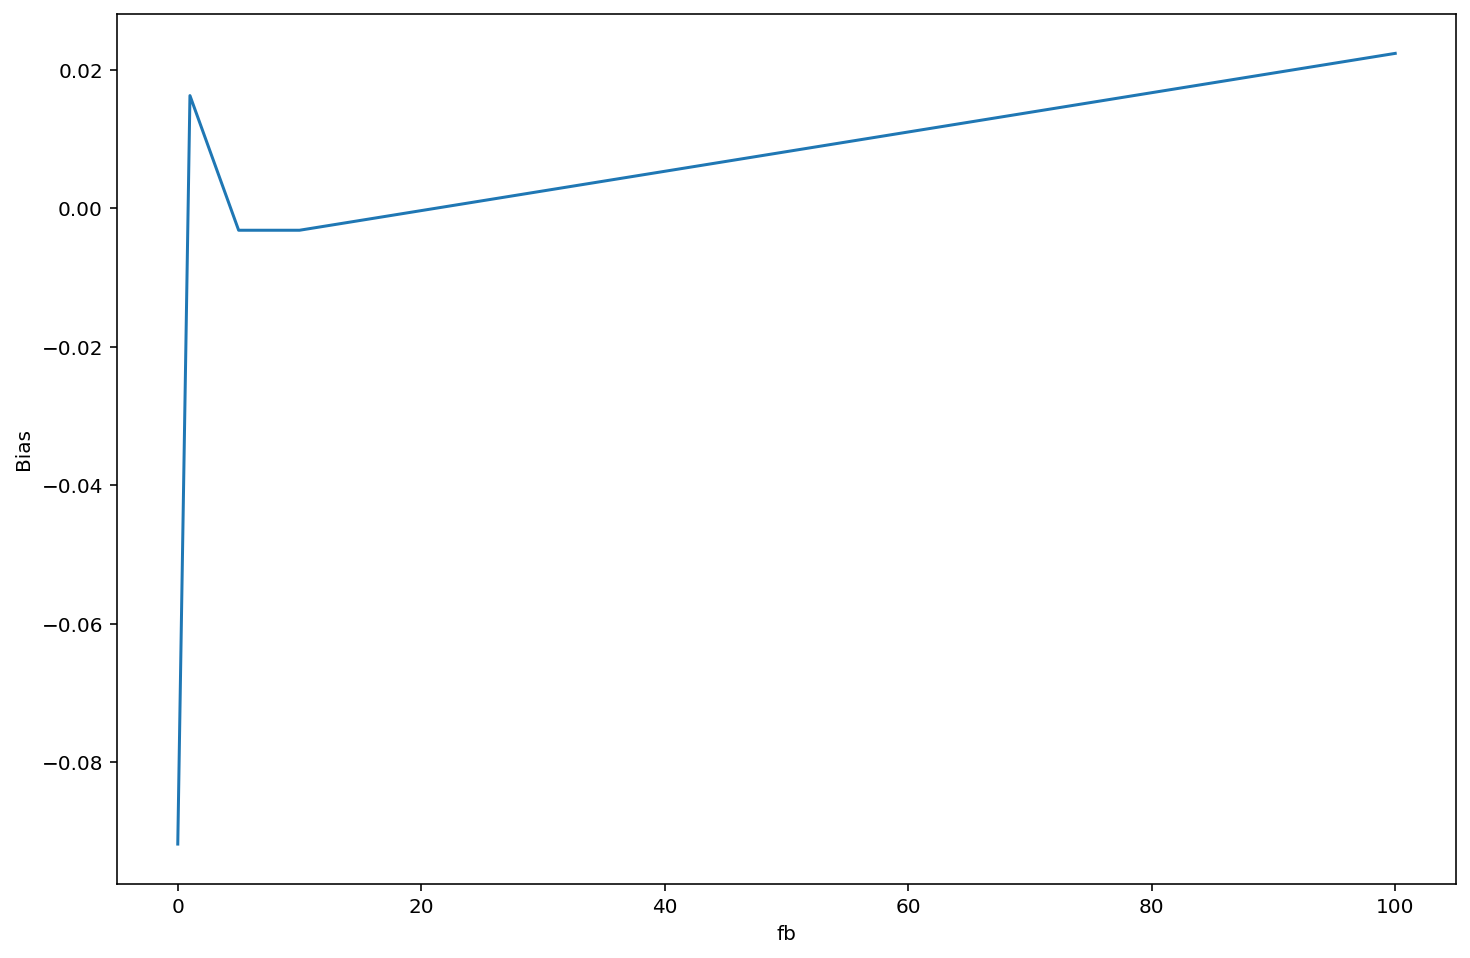

In [177]:
plt.plot(fbs, biases_auto)
plt.xlabel('fb')
plt.ylabel('Bias')

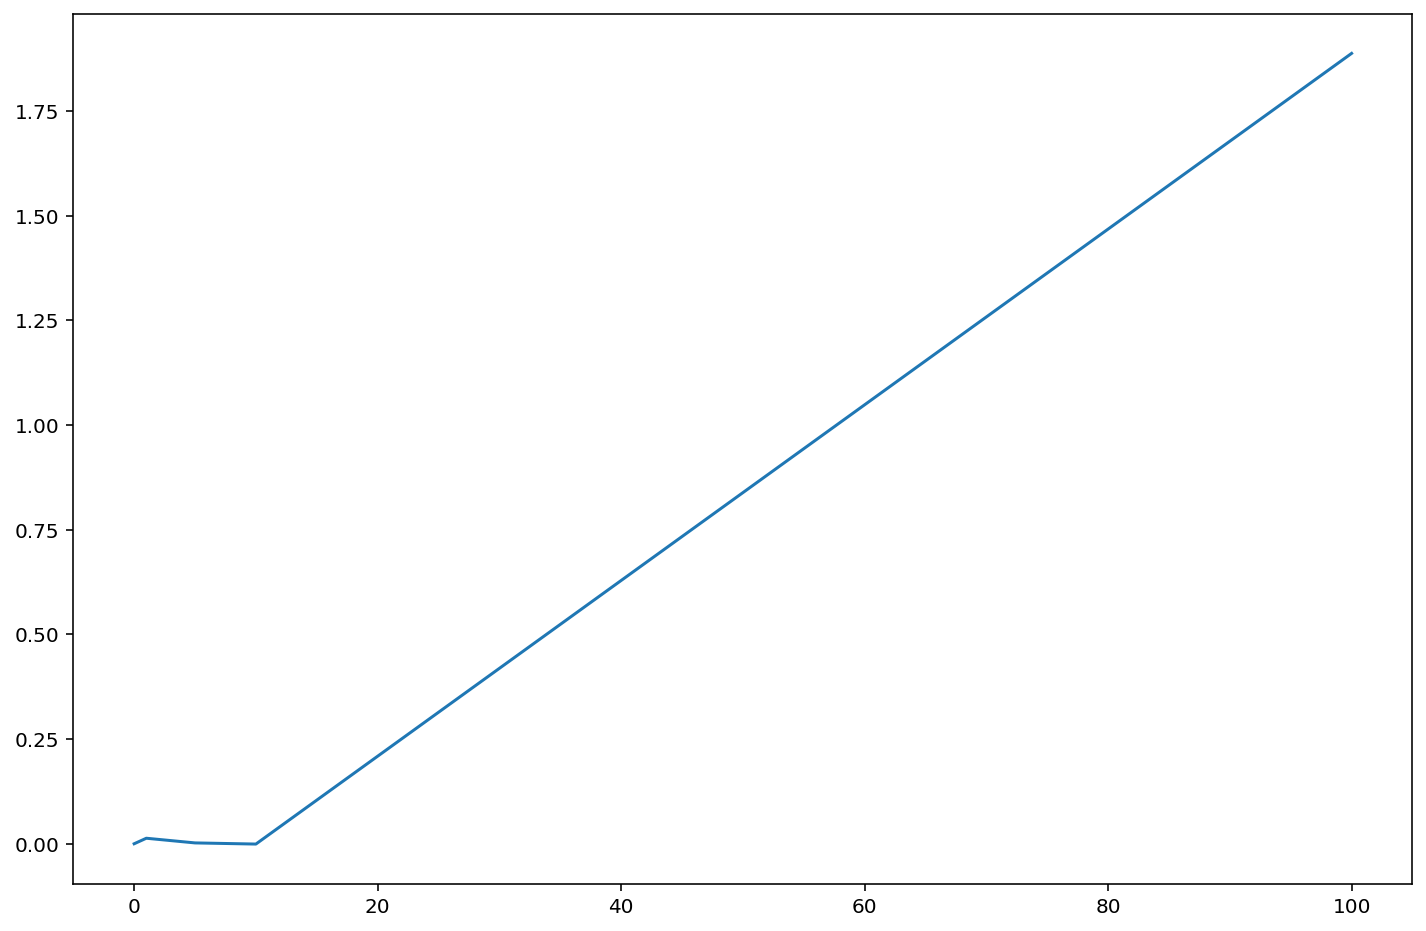

In [171]:
plt.plot(fbs, totals_cross)

In [107]:
min(autos, key = autos.get)

'h4000s4500b4000'

In [110]:
autos['h4000s4500b4000']

-0.007031717557891617

In [111]:
autos['h2000s2000b2000']

-0.0003286623674444945

In [47]:
bh = 3500

In [122]:
results = pathlib.Path('results/')

In [52]:
Res = best.Res(0, 0)

In [101]:
get_directory_lmax = lambda h, s, b: f'h{h}s{s}b{b}'

In [56]:
matrix = np.load(results/get_directory_lmax(2500, 2500, 2500)/'inversevariance/w_auto_fb_1.0.npy')
ells = matrix[0, :]
w1, w2, w3, w = matrix[1, :], matrix[2, :], matrix[3, :], matrix[4, :]

matrix = np.load(results/get_directory_lmax(2500, 2500, 2500)/'w_cross_fb_1.0.npy')
w1c, w2c, w3c, wc = matrix[1, :], matrix[2, :], matrix[3, :], matrix[4, :]

NameError: name 'results' is not defined

In [57]:
plt.plot(ells, w1, color = 'blue', label = 'h')
#plt.plot(ells, w1c, color = 'blue', ls = '--')

plt.plot(ells, w2, color = 'red', label = 's')
#plt.plot(ells, w2c, color = 'red', ls = '--')

plt.plot(ells, w3, color = 'green', label = 'b')
#plt.plot(ells, w3c, color = 'green', ls = '--')

plt.legend()

NameError: name 'ells' is not defined

In [58]:
plt.plot(ells, w, color = 'black')
plt.plot(ells, wc, color = 'black', ls = '--')

NameError: name 'ells' is not defined

In [107]:
import re

re.findall(r'\d+', 'h3000s2000b3000')

['3000', '2000', '3000']

In [108]:
P

PosixPath('output/h4500s4500b4500')

In [115]:
path = pathlib.Path('output')
all_lmaxes_directories =  [x.name for x in path.iterdir() if x.is_dir()]
len(all_lmaxes_directories)

128